### aim to predict the escalation of users using lstm and compare with other baseline classfiers

In [3]:
import os
import sys
import git
import pickle
import numpy as np

In [4]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [5]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [6]:
## insert the escalation dir
sys.path.insert(0, os.path.join(top_dir,"src","preprocess","escalation"))

In [7]:
%load_ext autoreload
%autoreload 2
import os
import sys

In [8]:
## importing the library function
module_path = os.path.abspath(top_dir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preprocess.escalation import driver
from sklearn.linear_model import LogisticRegression
import pandas as pd

Using TensorFlow backend.
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [10]:
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")

In [11]:
## we taking data from juul and weed and not use the pattern
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
# ## filter the juul data to capture just the regualr users
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## we keep only the regular usrs
first_data = first_data.loc[first_data.userID.isin(regular_users)]

## we look at weed first and juul first tweets
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [11]:
## so will train the classfier on the bucket data

In [12]:
## bucket the users in bucket :
#1 2015 - [2015-2018] 
#2 2015- 2016 - [17 - 18]
#3 2015 - 2017 - [18]

### looking at sequence of scores in year based interval

## Year level

In [10]:
## lok at the prediction accuracy fo classfier for different range intervals
## 2015 - 
## 2015 -16
## 2015 - 17
## juul_data and first_data
## lstm - sequence, without
## svm
## xgboost ..done

In [12]:
import util
import driver
import preprocessing
import lstm as lstm_module
import baselines
import pickle
import matplotlib.pyplot as plt
import pandas as pd

### preparing data

In [13]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [14]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [15]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [15]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [17]:
def get_year_data(year, first_data, juul_data):
    data = juul_data[(juul_data.tweetCreatedAt.dt.year >= year - 1) & ((juul_data.tweetCreatedAt.dt.year) <= year)]
    all_users = data.userID.unique()  # all users in that year
    check_data = first_data[first_data.userID.isin(all_users)]  ## users we need to check
    selected_data = (check_data[
        (check_data.weed_first.dt.year > year) | (pd.isnull(check_data.weed_first))])  ## juul before
    selected_users = selected_data["userID"]  ## total juul before
    poly_users = selected_data["userID"][selected_data.weed_first.dt.year == (year + 1)]
    print("total_users", len(selected_users))
    print("users that will change", len(poly_users))
    users_lbl = pd.DataFrame(selected_users, columns=["userID"])
    users_lbl["label"] = 0
    users_lbl.loc[users_lbl.userID.isin(poly_users), "label"] = 1
    final_data = data[data.userID.isin(selected_users)]  ## filter data by juul before users
    print("total data",len(final_data))
    print("***********")
    return ((year, final_data, users_lbl))

In [25]:
## gathering data in different range of intervals
# bucket_data = []
# bucket_data.append(preprocessing.get_year_data(2015,first_data,juul_data))
# bucket_data.append(preprocessing.get_year_data(2016,first_data,juul_data))
# bucket_data.append(preprocessing.get_year_data(2017,first_data,juul_data))

year 2015
users that will change 97
total users 1049
length of data 2944
year 2016
users that will change 313
total users 1636
length of data 6475
year 2017
users that will change 9525
total users 40236
length of data 111735


In [18]:
## gathering data in different range of intervals
bucket_data = []
bucket_data.append(get_year_data(2015,first_data,juul_data))
bucket_data.append(get_year_data(2016,first_data,juul_data))
bucket_data.append(get_year_data(2017,first_data,juul_data))

total_users 1140
users that will change 97
total data 2131
***********
total_users 2861
users that will change 313
total data 6806
***********
total_users 41902
users that will change 9497
total data 60896
***********


In [303]:
len(juul_data.loc[juul_data.tweetCreatedAt.dt.year == 2017])

163154

## Capture text features



  0%|          | 0/1049 [00:00<?, ?it/s]

100%|██████████| 1049/1049 [00:00<00:00, 45483.28it/s]

  0%|          | 0/1049 [00:00<?, ?it/s]

 29%|██▉       | 306/1049 [00:00<00:00, 3059.29it/s]

 56%|█████▌    | 583/1049 [00:00<00:00, 2965.65it/s]

 77%|███████▋  | 807/1049 [00:00<00:00, 2665.01it/s]

100%|██████████| 1049/1049 [00:00<00:00, 2616.40it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

100%|██████████| 839/839 [00:00<00:00, 184909.94it/s]

train-test split
max_length 60
preparing the tokenizer
vocalb 4707
creating glove embeddign matrix



 77%|███████▋  | 31062/40236 [00:27<00:03, 2326.17it/s]

encoding the data
X-train (839, 60)
X-test (210, 60)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 60, 100)           470700    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 631,902
Trainable params: 631,902
Non-trainable params: 0
_________________________________________________________________
None
training the model with balance dataset


/home/xavlock2345/twitter_juul/src/preprocess/escalation/driver.py:99: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  verbose=1, batch_size=32, class_weight=weight, )


Train on 1141 samples, validate on 381 samples
Epoch 1/20
1141/1141 [==============================] - 7s 6ms/step - loss: 1.6355 - acc: 0.6529 - val_loss: 1.5558 - val_acc: 0.1864
Epoch 2/20
1141/1141 [==============================] - 5s 4ms/step - loss: 0.8878 - acc: 0.6950 - val_loss: 1.0508 - val_acc: 0.3228
Epoch 3/20
1141/1141 [==============================] - 5s 4ms/step - loss: 0.5889 - acc: 0.7590 - val_loss: 0.6086 - val_acc: 0.7795
Epoch 4/20
1141/1141 [==============================] - 5s 4ms/step - loss: 0.4124 - acc: 0.8335 - val_loss: 0.4954 - val_acc: 0.7848
Epoch 5/20
1141/1141 [==============================] - 5s 4ms/step - loss: 0.3148 - acc: 0.8668 - val_loss: 0.2754 - val_acc: 0.8819
Epoch 6/20
1141/1141 [==============================] - 5s 4ms/step - loss: 0.2729 - acc: 0.8896 - val_loss: 0.2186 - val_acc: 0.8819
Epoch 7/20
1141/1141 [==============================] - 5s 4ms/step - loss: 0.2135 - acc: 0.9176 - val_loss: 0.1768 - val_acc: 0.9029
Epoch 8/20
1141

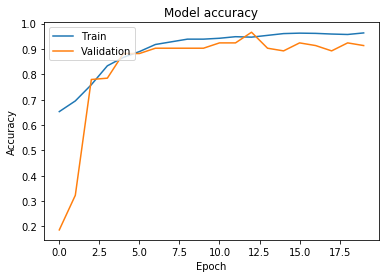

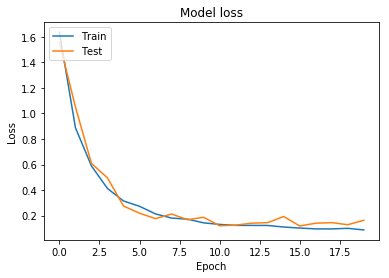

generating classfication report
Accuracy: 88.571428
  Classification Report of train data:
              precision    recall  f1-score   support

          0       0.92      0.96      0.94       191
          1       0.27      0.16      0.20        19

avg / total       0.86      0.89      0.87       210
 

first getting cross val scores
Train on 1038 samples, validate on 347 samples
Epoch 1/20
  32/1038 [..............................] - ETA: 4s - loss: 0.0959 - acc: 0.9688

/home/xavlock2345/twitter_juul/src/preprocess/escalation/lstm.py:163: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  verbose=1, batch_size=32, class_weight=None, )


1038/1038 [==============================] - 5s 4ms/step - loss: 0.1021 - acc: 0.9499 - val_loss: 0.4520 - val_acc: 0.8905
Epoch 2/20
1038/1038 [==============================] - 5s 5ms/step - loss: 0.0942 - acc: 0.9538 - val_loss: 0.4763 - val_acc: 0.9020
Epoch 3/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0934 - acc: 0.9509 - val_loss: 0.4161 - val_acc: 0.8934
Epoch 4/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0840 - acc: 0.9624 - val_loss: 0.5074 - val_acc: 0.8790
Epoch 5/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0959 - acc: 0.9489 - val_loss: 0.4747 - val_acc: 0.8761
Epoch 6/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0806 - acc: 0.9566 - val_loss: 0.5133 - val_acc: 0.8934
Epoch 7/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0814 - acc: 0.9624 - val_loss: 0.4738 - val_acc: 0.8905
Epoch 8/20
1038/1038 [==============================] - 5s 4ms/step - los

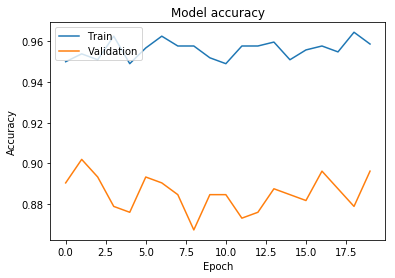

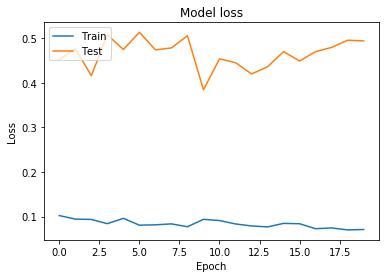

fold = 0
  Classification Report:
              precision    recall  f1-score   support

          0       0.95      0.94      0.95       191
          1       0.93      0.94      0.94       156

avg / total       0.94      0.94      0.94       347
 

Train on 1038 samples, validate on 347 samples
Epoch 1/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0880 - acc: 0.9509 - val_loss: 0.4818 - val_acc: 0.8963
Epoch 2/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0843 - acc: 0.9586 - val_loss: 0.4776 - val_acc: 0.8905
Epoch 3/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0849 - acc: 0.9538 - val_loss: 0.5149 - val_acc: 0.8963
Epoch 4/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0939 - acc: 0.9528 - val_loss: 0.4074 - val_acc: 0.8847
Epoch 5/20
1038/1038 [==============================] - 5s 4ms/step - loss: 0.0833 - acc: 0.9547 - val_loss: 0.4221 - val_acc: 0.8847
Epoch 6/20
1038/1038 [=========

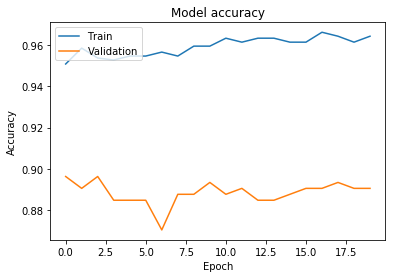

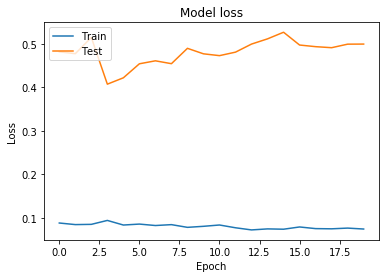

fold = 1
  Classification Report:
              precision    recall  f1-score   support

          0       0.99      0.94      0.97       191
          1       0.93      0.99      0.96       156

avg / total       0.96      0.96      0.96       347
 

Train on 1039 samples, validate on 347 samples
Epoch 1/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0654 - acc: 0.9644 - val_loss: 0.5190 - val_acc: 0.8876
Epoch 2/20
1039/1039 [==============================] - 5s 4ms/step - loss: 0.0628 - acc: 0.9663 - val_loss: 0.5197 - val_acc: 0.8905
Epoch 3/20
 224/1039 [=====>........................] - ETA: 3s - loss: 0.0701 - acc: 0.9554

In [ ]:
# oversampling
dimension = 100
epoch = 20
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores = []
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    # lstm model
    lstm_score, lstm_pred, lstm_model, keras_tkzr, max_len= driver.run_lstm(
                                        train_data["tweetText"],test_data["tweetText"],Y_train, Y_test,
                                        dimension,epoch,cross_splits=5,option="over",cross_val= True)
    
    # baseline models
    baseline_models, tfidf, svd =  driver.run_text_features(train_data["tweetText"], test_data["tweetText"], 
                                                            Y_train, Y_test,option="over",
                                                            svd=True,cross_val=True)
    
    svm_scores.append(baseline_models['svm'][1])
    rf_scores.append(baseline_models['rf'][1])
    xgb_scores.append(baseline_models['xgb'][1])
    lstm_scores.append(lstm_score)
    Y_tests.append(Y_test)

In [ ]:
# dump_scores
scores_over = {"svm_scores" : svm_scores,
               "rf_scores" : rf_scores,
               "lstm" : lstm_scores,
               "xgb" : xgb_scores}

# with open(os.path.join(model_dir,"text_over_scores.pkl"),"wb") as f:
#     pickle.dump(scores_over,f)

## plotting

In [374]:
scores_over = pickle.load(open(os.path.join(model_dir,"text_over_scores.pkl"),"rb"))

In [377]:
svm_scores = scores_over["svm_scores"]
rf_scores = scores_over["rf_scores"]
lstm_scores = scores_over["lstm"]
xgb_scores = scores_over["xgb"]

In [378]:
from sklearn.metrics import precision_recall_fscore_support
maj_scores_neg = []
maj_scores_pos = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos,average=None)[2][0]
    maj_scores_pos.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg,average=None)[2][0]
    maj_scores_neg.append(maj_neg) 

length of Y_test 210
positives in Y_test 19
length of Y_test 328
positives in Y_test 52
length of Y_test 8048
positives in Y_test 1861


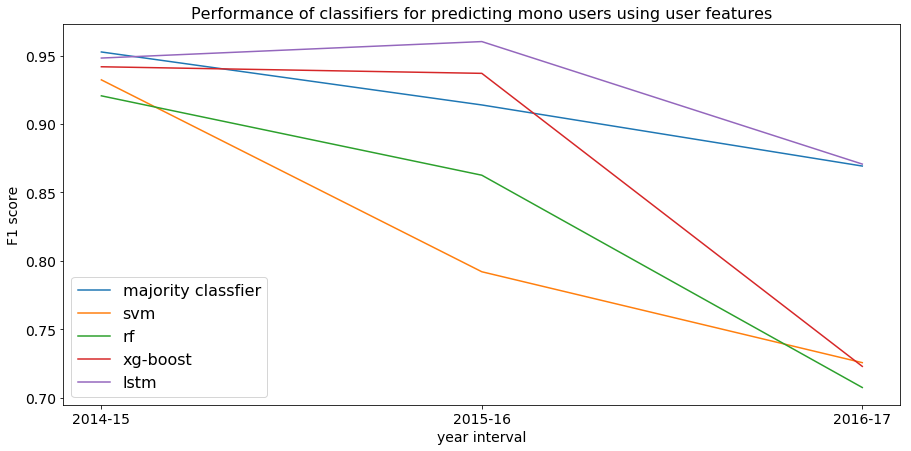

In [385]:
## oversampling  mono -- should have differnt name so that the plots dont get lost
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
lstm = [ele[0] for ele in lstm_scores]
# maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
# plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority classfier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using user features",fontsize=16)
plt.ylabel("F1 score",fontsize=14)
plt.xlabel("year interval",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

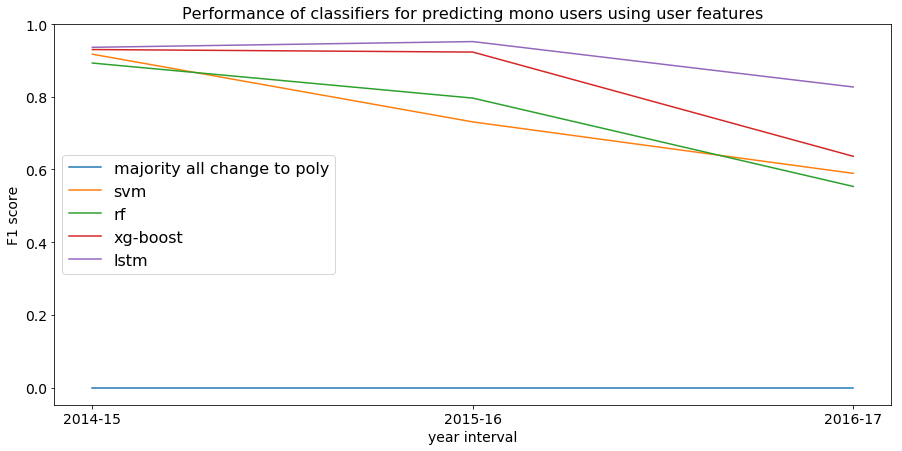

In [386]:
## oversampling  poly
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
lstm = [ele[1] for ele in lstm_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
# maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
# plt.plot(years,maj_score_neg,label="majority classfier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using user features",fontsize=16)
plt.ylabel("F1 score",fontsize=14)
plt.xlabel("year interval",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [77]:
xgb_scores

[array([0.94181006, 0.93002008]),
 array([0.93699789, 0.92302377]),
 array([0.72290262, 0.63615109])]

100%|██████████| 839/839 [00:00<00:00, 164586.36it/s]


train-test split
max_length 60
preparing the tokenizer
vocalb 4707
creating glove embeddign matrix
encoding the data
X-train (839, 60)
X-test (210, 60)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 60, 100)           470700    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 402       
Total params: 631,902
Trainable params: 631,902
Non-trainable params: 0
_________________________________________________________________
None
first getting cross val scores
Train on 628 samples, validate on 210 sa

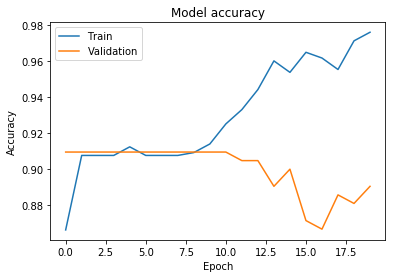

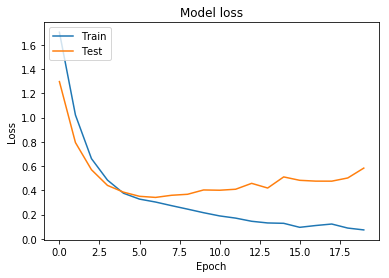

fold = 0
  Classification Report:
              precision    recall  f1-score   support

          0       0.91      0.97      0.94       191
          1       0.29      0.10      0.15        20

avg / total       0.85      0.89      0.87       211
 

Train on 628 samples, validate on 210 samples
Epoch 1/20
628/628 [==============================] - 5s 8ms/step - loss: 0.2338 - acc: 0.9347 - val_loss: 0.3844 - val_acc: 0.9048
Epoch 2/20
628/628 [==============================] - 5s 8ms/step - loss: 0.1856 - acc: 0.9411 - val_loss: 0.3825 - val_acc: 0.9048
Epoch 3/20
628/628 [==============================] - 5s 8ms/step - loss: 0.1648 - acc: 0.9443 - val_loss: 0.3980 - val_acc: 0.9048
Epoch 4/20
628/628 [==============================] - 5s 8ms/step - loss: 0.1362 - acc: 0.9490 - val_loss: 0.4059 - val_acc: 0.8952
Epoch 5/20
628/628 [==============================] - 5s 8ms/step - loss: 0.1384 - acc: 0.9490 - val_loss: 0.4473 - val_acc: 0.8857
Epoch 6/20
628/628 [======================

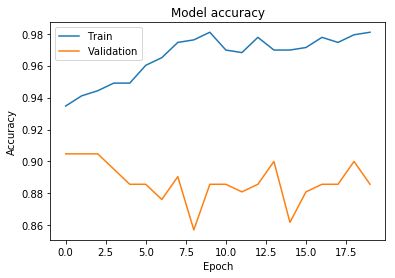

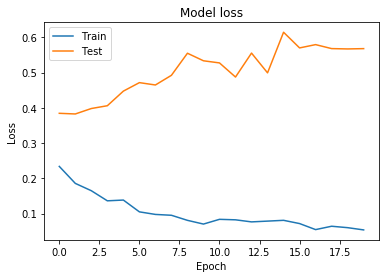

fold = 1
  Classification Report:
              precision    recall  f1-score   support

          0       0.98      0.98      0.98       191
          1       0.84      0.80      0.82        20

avg / total       0.97      0.97      0.97       211
 

Train on 630 samples, validate on 210 samples
Epoch 1/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0643 - acc: 0.9778 - val_loss: 0.6554 - val_acc: 0.8952
Epoch 2/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0724 - acc: 0.9778 - val_loss: 0.5635 - val_acc: 0.8905
Epoch 3/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0461 - acc: 0.9841 - val_loss: 0.6229 - val_acc: 0.8762
Epoch 4/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0511 - acc: 0.9825 - val_loss: 0.7217 - val_acc: 0.8714
Epoch 5/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0571 - acc: 0.9857 - val_loss: 0.5842 - val_acc: 0.8810
Epoch 6/20
630/630 [======================

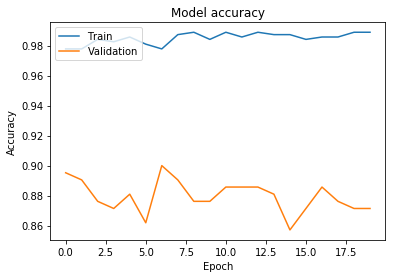

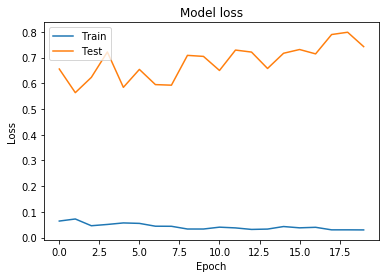

fold = 2
  Classification Report:
              precision    recall  f1-score   support

          0       0.97      0.99      0.98       190
          1       0.87      0.68      0.76        19

avg / total       0.96      0.96      0.96       209
 

Train on 630 samples, validate on 210 samples
Epoch 1/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0745 - acc: 0.9841 - val_loss: 0.7123 - val_acc: 0.8714
Epoch 2/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0618 - acc: 0.9825 - val_loss: 0.6360 - val_acc: 0.8810
Epoch 3/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0558 - acc: 0.9857 - val_loss: 0.6516 - val_acc: 0.8810
Epoch 4/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0459 - acc: 0.9825 - val_loss: 0.6792 - val_acc: 0.8762
Epoch 5/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0485 - acc: 0.9841 - val_loss: 0.6620 - val_acc: 0.8905
Epoch 6/20
630/630 [======================

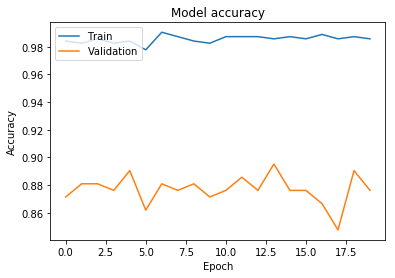

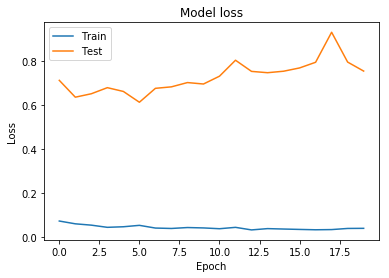

fold = 3
  Classification Report:
              precision    recall  f1-score   support

          0       0.99      0.99      0.99       190
          1       0.94      0.89      0.92        19

avg / total       0.99      0.99      0.99       209
 

Train on 630 samples, validate on 210 samples
Epoch 1/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0470 - acc: 0.9841 - val_loss: 0.0708 - val_acc: 0.9762
Epoch 2/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0374 - acc: 0.9889 - val_loss: 0.0723 - val_acc: 0.9762
Epoch 3/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0346 - acc: 0.9873 - val_loss: 0.0707 - val_acc: 0.9762
Epoch 4/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0358 - acc: 0.9857 - val_loss: 0.0731 - val_acc: 0.9762
Epoch 5/20
630/630 [==============================] - 5s 8ms/step - loss: 0.0344 - acc: 0.9873 - val_loss: 0.0781 - val_acc: 0.9714
Epoch 6/20
630/630 [======================

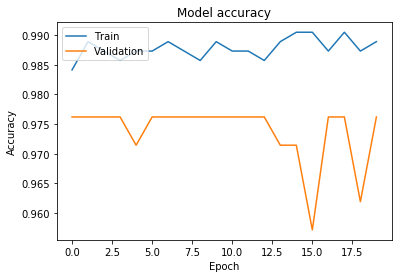

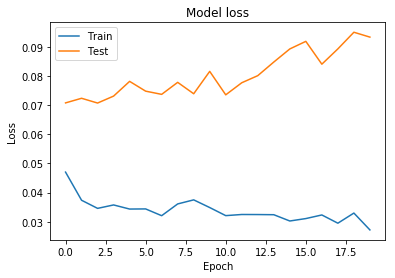

fold = 4
  Classification Report:
              precision    recall  f1-score   support

          0       0.91      0.96      0.93       190
          1       0.00      0.00      0.00        19

avg / total       0.82      0.87      0.85       209
 

*************
0.9651468663950766 0.5304571539865658
training the model with balance dataset
Train on 629 samples, validate on 210 samples
Epoch 1/20


/home/xavlock2345/twitter_juul/src/preprocess/escalation/driver.py:98: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  verbose=1, batch_size=32, class_weight=weight, )


629/629 [==============================] - 5s 8ms/step - loss: 0.0305 - acc: 0.9873 - val_loss: 0.0937 - val_acc: 0.9762
Epoch 2/20
629/629 [==============================] - 5s 8ms/step - loss: 0.0328 - acc: 0.9873 - val_loss: 0.0957 - val_acc: 0.9619
Epoch 3/20
629/629 [==============================] - 5s 8ms/step - loss: 0.0334 - acc: 0.9857 - val_loss: 0.0933 - val_acc: 0.9619
Epoch 4/20
629/629 [==============================] - 5s 8ms/step - loss: 0.0310 - acc: 0.9873 - val_loss: 0.0920 - val_acc: 0.9762
Epoch 5/20
629/629 [==============================] - 5s 8ms/step - loss: 0.0372 - acc: 0.9873 - val_loss: 0.0873 - val_acc: 0.9762
Epoch 6/20
629/629 [==============================] - 5s 8ms/step - loss: 0.0312 - acc: 0.9873 - val_loss: 0.0914 - val_acc: 0.9762
Epoch 7/20
629/629 [==============================] - 5s 8ms/step - loss: 0.0304 - acc: 0.9889 - val_loss: 0.0976 - val_acc: 0.9619
Epoch 8/20
629/629 [==============================] - 5s 8ms/step - loss: 0.0339 - acc:

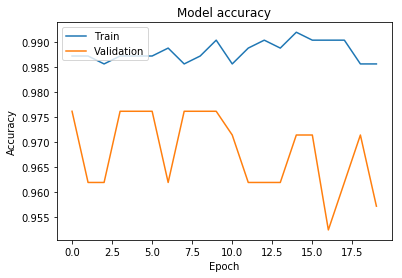

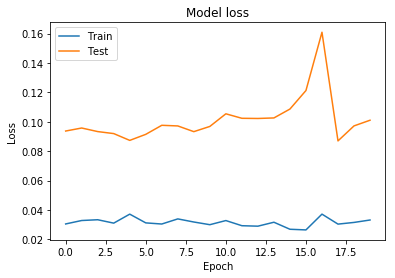

generating classfication report
Accuracy: 84.761905
  Classification Report of train data:
              precision    recall  f1-score   support

          0       0.91      0.92      0.92       191
          1       0.12      0.11      0.11        19

avg / total       0.84      0.85      0.84       210
 

lstm cross val score  0.7478020101908212
job finished
train data length 839
total positives before in train 78
training the models
X_train shape (839, 100)
X_test shape (210, 100)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.94931501 0.03571429] 

random_forest


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-d

rf cross val score mean [0.95152807 0.        ] 

xgBoost


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/prepro

xgb corss val score mean [0.94720679 0.03405797] 

the best model svm
baseline scores calculated


100%|██████████| 1308/1308 [00:00<00:00, 191495.33it/s]


train-test split
max_length 60
preparing the tokenizer
vocalb 6574
creating glove embeddign matrix
encoding the data
X-train (1308, 60)
X-test (328, 60)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 60, 100)           657400    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 402       
Total params: 818,602
Trainable params: 818,602
Non-trainable params: 0
_________________________________________________________________
None
first getting cross val scores


/home/xavlock2345/twitter_juul/src/preprocess/escalation/lstm.py:153: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  verbose=1, batch_size=32, class_weight=None, )


Train on 981 samples, validate on 327 samples
Epoch 1/20
981/981 [==============================] - 11s 11ms/step - loss: 1.6158 - acc: 0.8175 - val_loss: 1.0823 - val_acc: 0.8410
Epoch 2/20
981/981 [==============================] - 8s 8ms/step - loss: 0.8296 - acc: 0.8420 - val_loss: 0.6658 - val_acc: 0.8410
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.5503 - acc: 0.8410 - val_loss: 0.5108 - val_acc: 0.8410
Epoch 4/20
981/981 [==============================] - 8s 8ms/step - loss: 0.4408 - acc: 0.8420 - val_loss: 0.4695 - val_acc: 0.8410
Epoch 5/20
981/981 [==============================] - 8s 8ms/step - loss: 0.4022 - acc: 0.8400 - val_loss: 0.4827 - val_acc: 0.8410
Epoch 6/20
981/981 [==============================] - 8s 8ms/step - loss: 0.3846 - acc: 0.8461 - val_loss: 0.4589 - val_acc: 0.8410
Epoch 7/20
981/981 [==============================] - 8s 8ms/step - loss: 0.3657 - acc: 0.8461 - val_loss: 0.4460 - val_acc: 0.8379
Epoch 8/20
981/981 [========

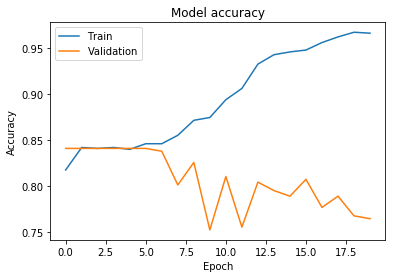

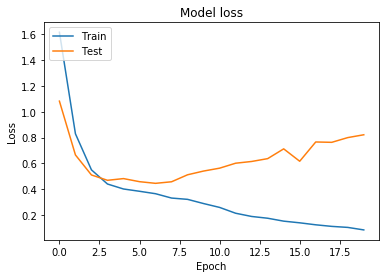

fold = 0
  Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.91      0.88       276
          1       0.21      0.13      0.16        52

avg / total       0.75      0.78      0.76       328
 

Train on 981 samples, validate on 327 samples
Epoch 1/20
981/981 [==============================] - 8s 8ms/step - loss: 0.2649 - acc: 0.9123 - val_loss: 0.5977 - val_acc: 0.7492
Epoch 2/20
981/981 [==============================] - 8s 8ms/step - loss: 0.2247 - acc: 0.9164 - val_loss: 0.5617 - val_acc: 0.7676
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.1922 - acc: 0.9307 - val_loss: 0.6102 - val_acc: 0.7645
Epoch 4/20
981/981 [==============================] - 8s 8ms/step - loss: 0.1632 - acc: 0.9399 - val_loss: 0.6632 - val_acc: 0.7798
Epoch 5/20
981/981 [==============================] - 8s 8ms/step - loss: 0.1370 - acc: 0.9439 - val_loss: 0.7037 - val_acc: 0.7920
Epoch 6/20
981/981 [======================

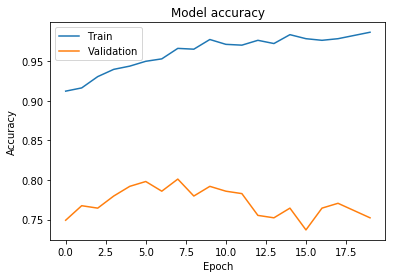

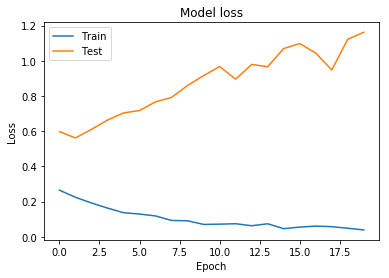

fold = 1
  Classification Report:
              precision    recall  f1-score   support

          0       0.98      0.99      0.98       276
          1       0.94      0.88      0.91        52

avg / total       0.97      0.97      0.97       328
 

Train on 981 samples, validate on 328 samples
Epoch 1/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0847 - acc: 0.9694 - val_loss: 1.0953 - val_acc: 0.7652
Epoch 2/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0763 - acc: 0.9745 - val_loss: 1.0596 - val_acc: 0.7927
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0694 - acc: 0.9766 - val_loss: 0.9704 - val_acc: 0.7927
Epoch 4/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0503 - acc: 0.9857 - val_loss: 1.1185 - val_acc: 0.7439
Epoch 5/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0529 - acc: 0.9806 - val_loss: 1.1164 - val_acc: 0.7713
Epoch 6/20
981/981 [======================

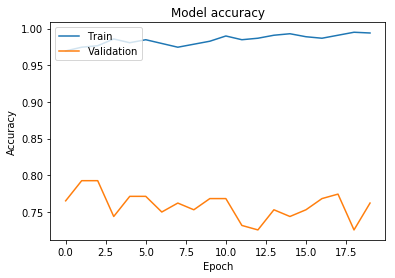

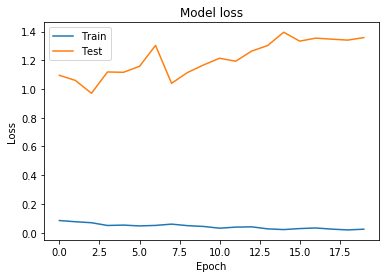

fold = 2
  Classification Report:
              precision    recall  f1-score   support

          0       1.00      0.98      0.99       275
          1       0.91      1.00      0.95        52

avg / total       0.99      0.98      0.98       327
 

Train on 981 samples, validate on 328 samples
Epoch 1/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0358 - acc: 0.9908 - val_loss: 1.2406 - val_acc: 0.7774
Epoch 2/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0400 - acc: 0.9847 - val_loss: 1.2093 - val_acc: 0.7470
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0225 - acc: 0.9918 - val_loss: 1.2191 - val_acc: 0.7988
Epoch 4/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0248 - acc: 0.9918 - val_loss: 1.2764 - val_acc: 0.7713
Epoch 5/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0322 - acc: 0.9878 - val_loss: 1.2299 - val_acc: 0.8018
Epoch 6/20
981/981 [======================

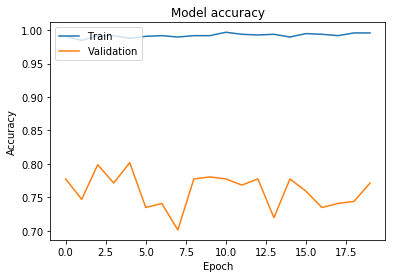

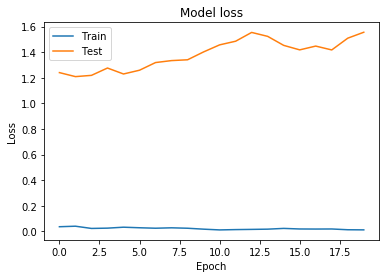

fold = 3
  Classification Report:
              precision    recall  f1-score   support

          0       0.98      1.00      0.99       275
          1       1.00      0.88      0.94        52

avg / total       0.98      0.98      0.98       327
 

Train on 982 samples, validate on 328 samples
Epoch 1/20
982/982 [==============================] - 8s 8ms/step - loss: 0.0127 - acc: 0.9939 - val_loss: 0.0725 - val_acc: 0.9848
Epoch 2/20
982/982 [==============================] - 8s 8ms/step - loss: 0.0119 - acc: 0.9949 - val_loss: 0.0658 - val_acc: 0.9787
Epoch 3/20
982/982 [==============================] - 8s 8ms/step - loss: 0.0159 - acc: 0.9919 - val_loss: 0.0629 - val_acc: 0.9817
Epoch 4/20
982/982 [==============================] - 8s 8ms/step - loss: 0.0076 - acc: 0.9959 - val_loss: 0.0604 - val_acc: 0.9848
Epoch 5/20
982/982 [==============================] - 8s 8ms/step - loss: 0.0140 - acc: 0.9939 - val_loss: 0.0783 - val_acc: 0.9817
Epoch 6/20
982/982 [======================

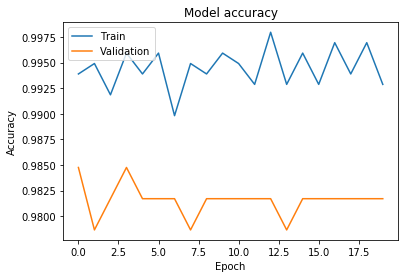

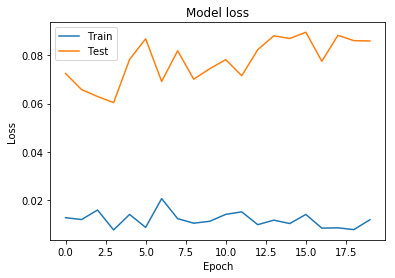

fold = 4
  Classification Report:
              precision    recall  f1-score   support

          0       0.85      0.86      0.86       275
          1       0.21      0.20      0.20        51

avg / total       0.75      0.76      0.75       326
 

*************
0.9393235409300956 0.6341042248106216
training the model with balance dataset
Train on 981 samples, validate on 327 samples
Epoch 1/20


/home/xavlock2345/twitter_juul/src/preprocess/escalation/driver.py:98: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  verbose=1, batch_size=32, class_weight=weight, )


981/981 [==============================] - 8s 8ms/step - loss: 0.0102 - acc: 0.9949 - val_loss: 0.0841 - val_acc: 0.9786
Epoch 2/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0104 - acc: 0.9949 - val_loss: 0.0947 - val_acc: 0.9817
Epoch 3/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0080 - acc: 0.9959 - val_loss: 0.0970 - val_acc: 0.9817
Epoch 4/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0093 - acc: 0.9959 - val_loss: 0.0956 - val_acc: 0.9817
Epoch 5/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0094 - acc: 0.9969 - val_loss: 0.0969 - val_acc: 0.9817
Epoch 6/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0083 - acc: 0.9959 - val_loss: 0.0953 - val_acc: 0.9817
Epoch 7/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0076 - acc: 0.9949 - val_loss: 0.0995 - val_acc: 0.9817
Epoch 8/20
981/981 [==============================] - 8s 8ms/step - loss: 0.0060 - acc:

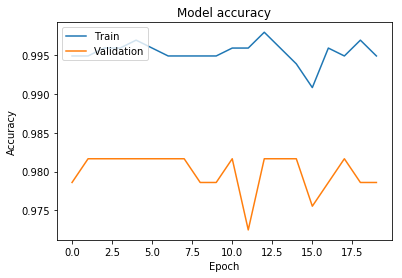

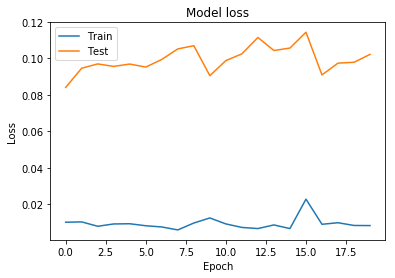

generating classfication report
Accuracy: 76.219512
  Classification Report of train data:
              precision    recall  f1-score   support

          0       0.85      0.87      0.86       276
          1       0.23      0.21      0.22        52

avg / total       0.75      0.76      0.76       328
 

lstm cross val score  0.7867138828703586
job finished
train data length 1308
total positives before in train 207
training the models
X_train shape (1308, 100)
X_test shape (328, 100)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.91299394 0.12019467] 

random_forest


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-d

rf cross val score mean [0.91403971 0.        ] 

xgBoost


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/prepro

xgb corss val score mean [0.90728713 0.13249029] 

the best model xgb
baseline scores calculated


100%|██████████| 32188/32188 [00:00<00:00, 261108.71it/s]

train-test split
max_length 60
preparing the tokenizer


vocalb 18627
creating glove embeddign matrix
encoding the data
X-train (32188, 60)
X-test (8048, 60)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 60, 100)           1862700   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 402       
Total params: 2,023,902
Trainable params: 2,023,902
Non-trainable params: 0
_________________________________________________________________
None
first getting cross val scores


/home/xavlock2345/twitter_juul/src/preprocess/escalation/lstm.py:153: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  verbose=1, batch_size=32, class_weight=None, )


Train on 24141 samples, validate on 8047 samples
Epoch 1/20
24141/24141 [==============================] - 207s 9ms/step - loss: 0.5801 - acc: 0.7700 - val_loss: 0.5115 - val_acc: 0.7712
Epoch 2/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.4843 - acc: 0.7769 - val_loss: 0.4839 - val_acc: 0.7733
Epoch 3/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.4694 - acc: 0.7822 - val_loss: 0.4891 - val_acc: 0.7745
Epoch 4/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.4569 - acc: 0.7857 - val_loss: 0.4867 - val_acc: 0.7697
Epoch 5/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.4421 - acc: 0.7978 - val_loss: 0.5078 - val_acc: 0.7708
Epoch 6/20
24141/24141 [==============================] - 204s 8ms/step - loss: 0.4235 - acc: 0.8065 - val_loss: 0.5145 - val_acc: 0.7643
Epoch 7/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.4039 - acc: 0.8191 - val_loss: 0.5273 - v

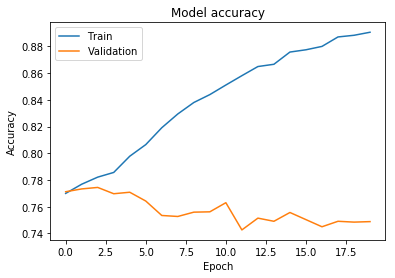

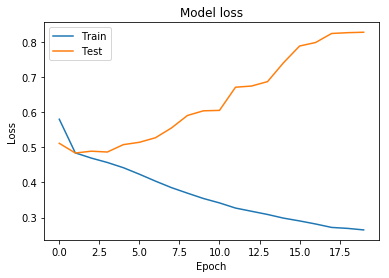

fold = 0
  Classification Report:
              precision    recall  f1-score   support

          0       0.80      0.90      0.85      6186
          1       0.44      0.27      0.33      1862

avg / total       0.72      0.75      0.73      8048
 

Train on 24141 samples, validate on 8048 samples
Epoch 1/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.3878 - acc: 0.8428 - val_loss: 0.5654 - val_acc: 0.7550
Epoch 2/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.3568 - acc: 0.8556 - val_loss: 0.5745 - val_acc: 0.7573
Epoch 3/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.3384 - acc: 0.8621 - val_loss: 0.6135 - val_acc: 0.7547
Epoch 4/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.3249 - acc: 0.8670 - val_loss: 0.6715 - val_acc: 0.7444
Epoch 5/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.3077 - acc: 0.8750 - val_loss: 0.6512 - val_acc: 0.7489
Epoch 6/2

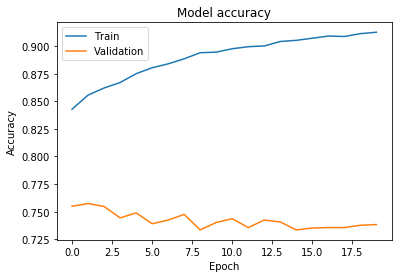

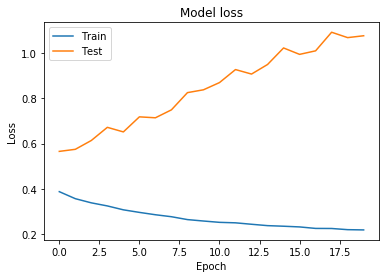

fold = 1
  Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.95      0.90      6186
          1       0.73      0.49      0.59      1861

avg / total       0.83      0.84      0.83      8047
 

Train on 24141 samples, validate on 8048 samples
Epoch 1/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2940 - acc: 0.8853 - val_loss: 0.8272 - val_acc: 0.7423
Epoch 2/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2673 - acc: 0.8928 - val_loss: 0.8589 - val_acc: 0.7440
Epoch 3/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2575 - acc: 0.8971 - val_loss: 0.8786 - val_acc: 0.7453
Epoch 4/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2486 - acc: 0.8996 - val_loss: 0.9105 - val_acc: 0.7406
Epoch 5/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2432 - acc: 0.9005 - val_loss: 0.9274 - val_acc: 0.7425
Epoch 6/2

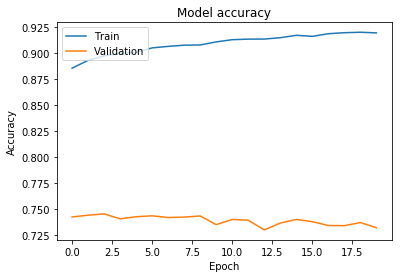

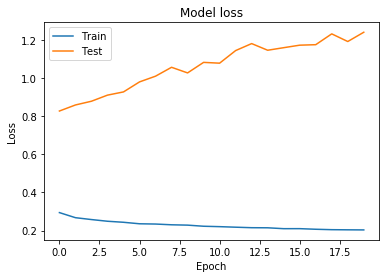

fold = 2
  Classification Report:
              precision    recall  f1-score   support

          0       0.90      0.96      0.93      6186
          1       0.85      0.65      0.73      1861

avg / total       0.89      0.89      0.89      8047
 

Train on 24141 samples, validate on 8048 samples
Epoch 1/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2426 - acc: 0.9057 - val_loss: 1.0264 - val_acc: 0.7394
Epoch 2/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2284 - acc: 0.9102 - val_loss: 1.0853 - val_acc: 0.7332
Epoch 3/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2199 - acc: 0.9126 - val_loss: 1.0938 - val_acc: 0.7372
Epoch 4/20
24141/24141 [==============================] - 203s 8ms/step - loss: 0.2169 - acc: 0.9146 - val_loss: 1.0966 - val_acc: 0.7342
Epoch 5/20
24141/24141 [==============================] - 202s 8ms/step - loss: 0.2120 - acc: 0.9162 - val_loss: 1.1145 - val_acc: 0.7372
Epoch 6/2

In [ ]:
# downsampling **********
dimension = 100
epoch = 20
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores = []
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## lstm model
    lstm_score, lstm_pred, lstm_model, keras_tkzr, max_len= driver.run_lstm(
                                        train_data["tweetText"],test_data["tweetText"],Y_train, Y_test,
                                        dimension,epoch,cross_splits=5,option="down")
    
    # baseline models
    baseline_models, tfidf, svd =  driver.run_text_features(train_data["tweetText"], 
                                            test_data["tweetText"], Y_train, Y_test,option="down")
    
    svm_scores.append(baseline_models['svm'][1])
    rf_scores.append(baseline_models['rf'][1])
    xgb_scores.append(baseline_models['xgb'][1])
    lstm_scores.append(lstm_score)

    Y_tests.append(Y_test)

In [57]:
from sklearn.metrics import precision_recall_fscore_support
maj_scores_neg = []
maj_scores_pos = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos,average=None)[2][0]
    maj_scores_pos.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg,average=None)[2][0]
    maj_scores_neg.append(maj_neg)

length of Y_test 210
positives in Y_test 19
length of Y_test 328
positives in Y_test 52
length of Y_test 8048
positives in Y_test 1861


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
## get distribution of positives in test data..
# dump_scores
import pickle
scores = {"svm_scores" : svm_scores,
               "rf_scores" : rf_scores,
               "lstm" : lstm_scores,
               "xgb" : xgb_scores}

with open(os.path.join(model_dir,"text_under_scores.pkl"),"wb") as f:
    pickle.dump(scores,f)

In [51]:
#### @TODO look at the plots
scores_under = pickle.load(open(os.path.join(model_dir,"text_under_scores.pkl"),"rb"))
svm_scores =  scores_under["svm_scores"]
rf_scores = scores_under["rf_scores"]
xgb_scores = scores_under["xgb"]
lstm_scores = scores_under["lstm"]

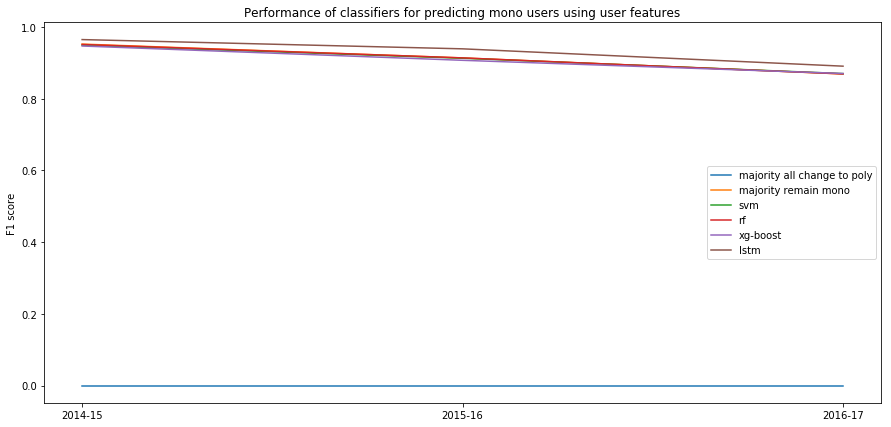

In [63]:
## downsampling mono
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
lstm = [ele[0] for ele in lstm_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using user features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

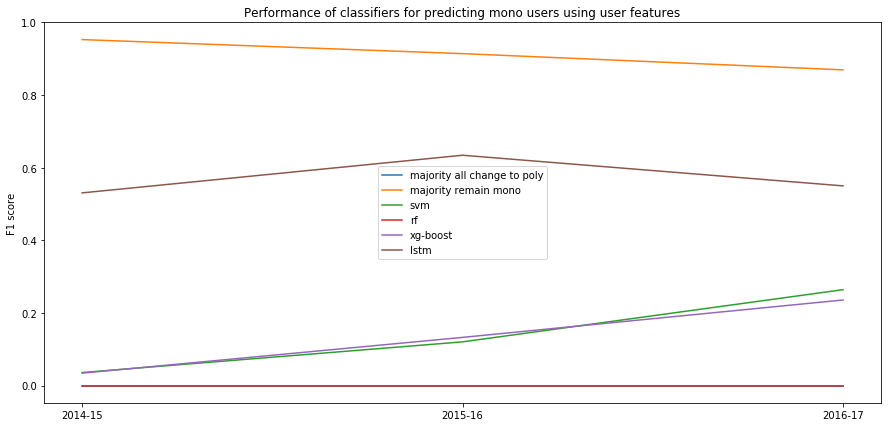

In [64]:
## downsampling poly
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
lstm = [ele[1] for ele in lstm_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using user features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [35]:
def plot_model_coeff(model, k, feature_names):
    coef = model.feature_importances_
    top_coefficients = np.argsort(coef)[-k:]
    plt.figure(figsize=(17, 8))
    plt.bar(np.arange(k), coef[top_coefficients], color="blue")
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(k), feature_names[top_coefficients], rotation=60, ha='right', fontsize=20)
    plt.show()

### plotting feature importances

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
for year,data,users_labelled in bucket_data[1:2]:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
        
#     # baseline models
#     baseline_models, tfidf, svd =  driver.run_text_features(train_data["tweetText"], 
#                                             test_data["tweetText"], Y_train, Y_test,option="over",svd=False)
    train_data = train_data["tweetText"]
    test_data = test_data["tweetText"]
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(train_data)  ## fit on train data

    ## transform train and test data
    X_test = tf_idf.transform(test_data)
    X_train = tf_idf.transform(train_data)
    X_train, Y_train = util.get_oversample(X_train,Y_train)

    X_train = X_train.toarray()  ## because of sparse array
    X_test = X_test.toarray()    ## because of sparse array
    
#     print("svm")
#     svm = LinearSVC(C=1, verbose=1)
#     svm.fit(X_train, Y_train)

#     print("random_forest")
#     rf = RandomForestClassifier(n_estimators=100, max_depth=2,
#                             random_state=0)
#     rf.fit(X_train, Y_train)
    
    print("xgBoost")
#     xgb = XGBClassifier()
#     xgb.fit(X_train, Y_train)
    dtrain = xgb.DMatrix(X_train, label=Y_train,feature_names=tf_idf.get_feature_names())
    xgb_model = xgb.train([],dtrain, verbose_eval=10) #  num_boost_round=60, 
# #                   early_stopping_rounds=50, maximize=False,

100%|██████████| 1636/1636 [00:00<00:00, 1934.98it/s]


train-test split
xgBoost


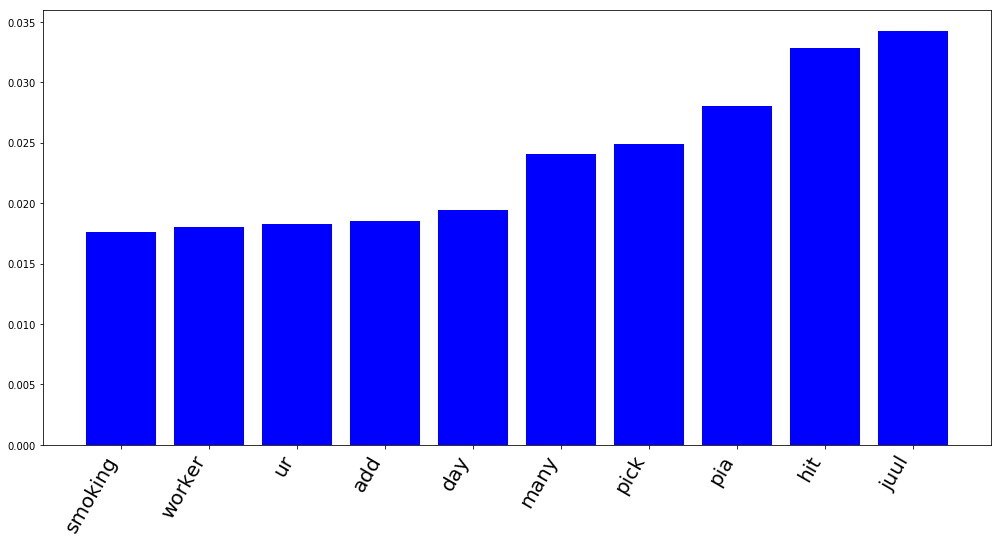

In [38]:
## 2014-15 --rf
plot_model_coeff(rf,10,tf_idf.get_feature_names())

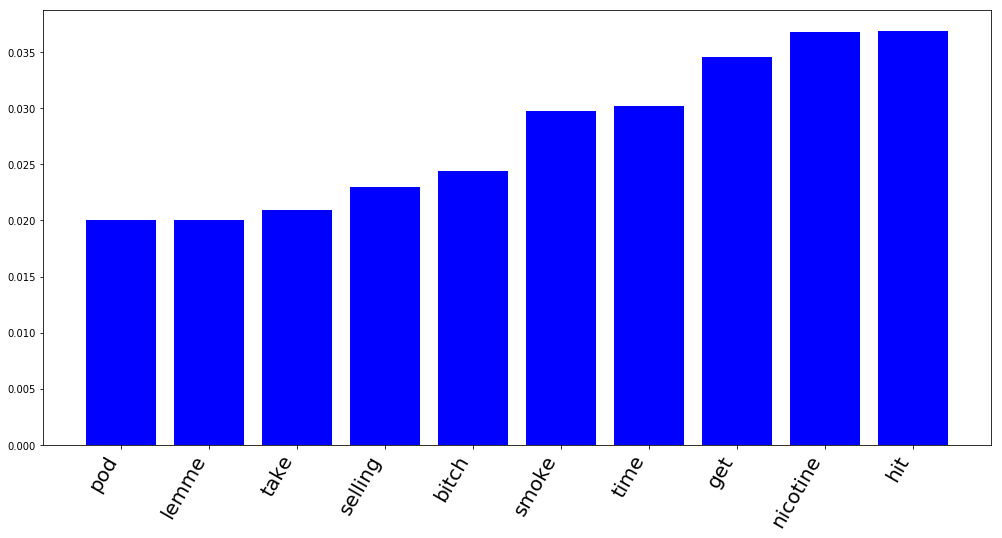

In [45]:
## 2015-16 -- rf
plot_model_coeff(rf,10,tf_idf.get_feature_names())

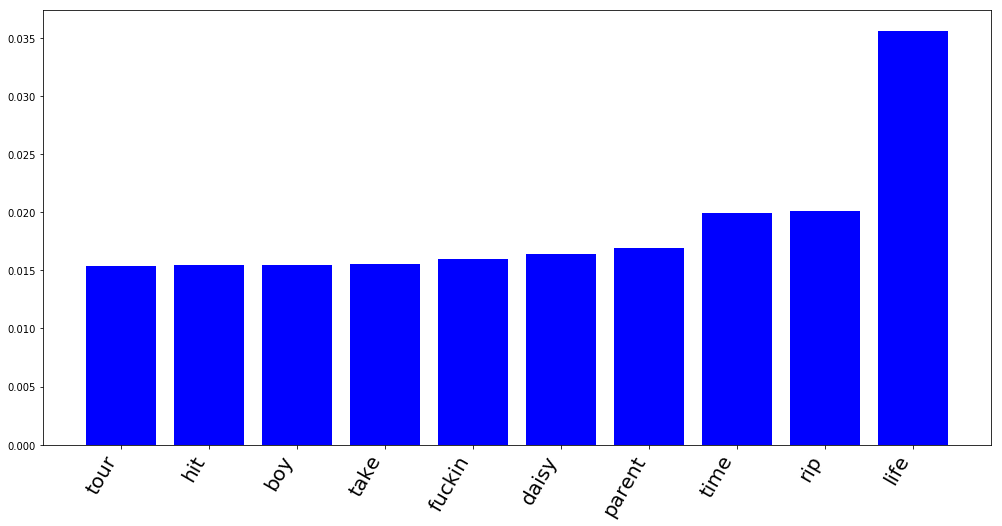

In [42]:
## 2016-17 -- rf
plot_model_coeff(rf,10,tf_idf.get_feature_names())

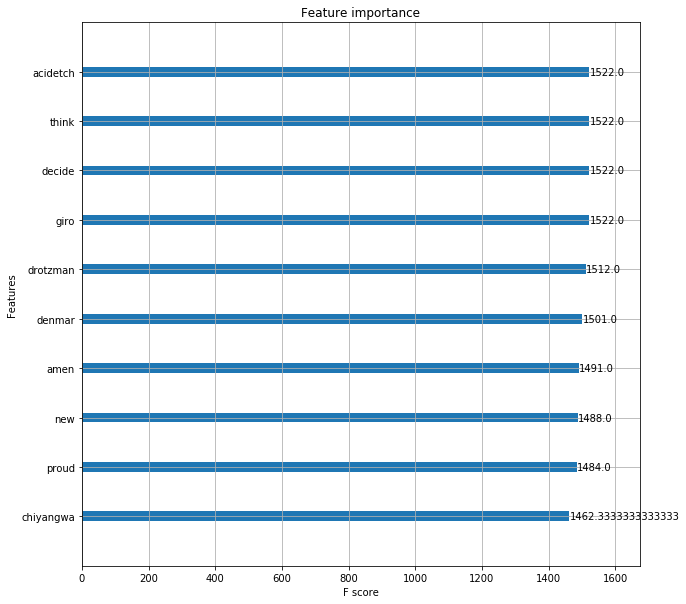

In [26]:
## 2014-15  .. not much intresting
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(10,10),)
plot_importance(xgb_model,importance_type='cover',max_num_features =10,ax=ax) 
plt.show()

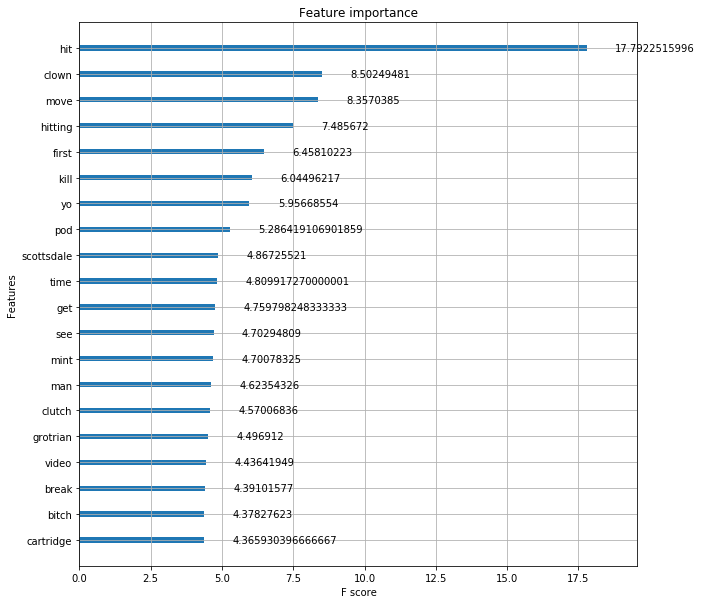

In [55]:
# 2015-16
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(xgb_model,importance_type='gain',max_num_features =20,ax=ax)
plt.show()

In [ ]:
## 2016-17  -- getting hanged..
fontsize=10
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(10,10),)
plot_importance(xgb_model,max_num_features =10,ax=ax,importance_type='gain' )
plt.show()

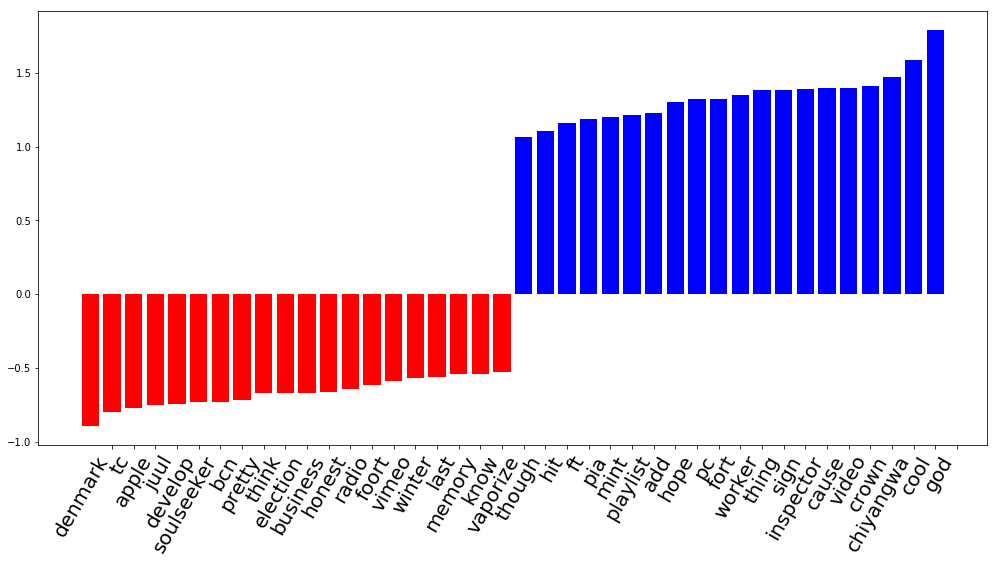

array([ 0.28033782,  0.27798611, -0.01364001, ..., -0.03396265,
        0.06855672,  0.06855672])

In [27]:
# 2014-15 -- svm
util.plot_coeff(20,svm_,tfidf.get_feature_names())

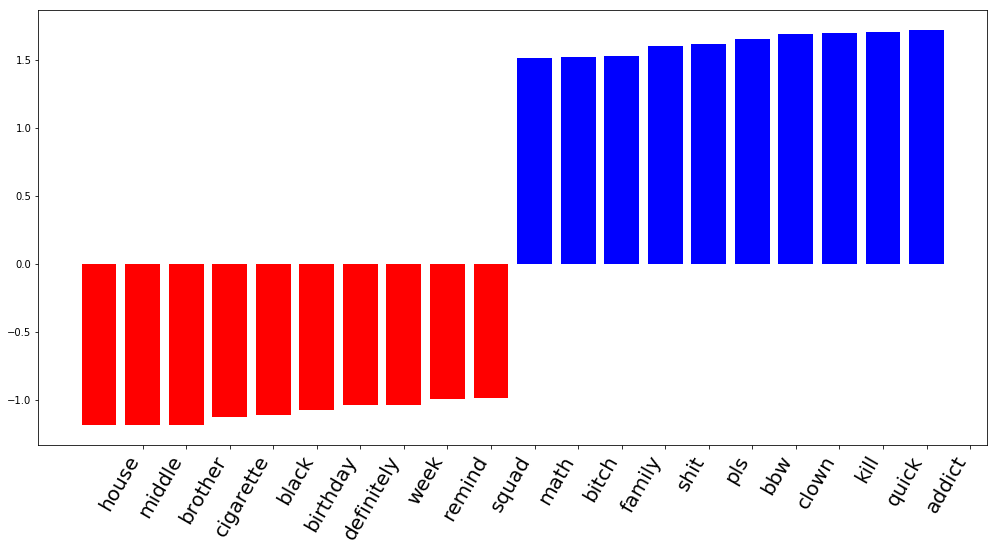

array([-0.23134392,  0.23366771, -0.05897826, ..., -0.0895967 ,
       -0.07892998, -0.02808024])

In [48]:
# 2015-16
util.plot_coeff(10,svm,tf_idf.get_feature_names())

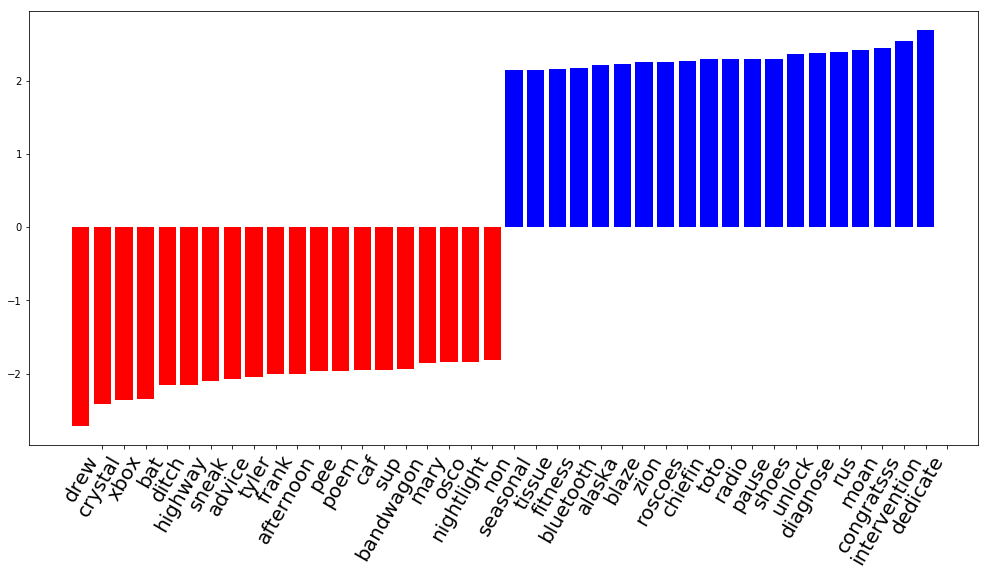

array([-1.47458857,  0.02193746,  0.        , ...,  0.53290239,
        0.02032167,  0.        ])

In [22]:
# 2016-17
util.plot_coeff(20,svm,tf_idf.get_feature_names())

## capture user features

In [43]:
svm_scores = []
rf_scores = []
xgb_scores = []
maj_scores = []
Y_tests = []
for year,data,users_labelled in bucket_data:
    print("************")
    print("preparing the data")
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    all_models = driver.run_user_features(train_data, test_data, Y_train, Y_test,"over") ## oversampled data
    
    
    ## user predictions
    svm_scores.append(all_models['svm'][1])
    rf_scores.append(all_models['rf'][1])
    xgb_scores.append(all_models['xgb'][1])
    Y_tests.append(Y_test)


 31%|███       | 320/1049 [00:00<00:00, 3194.42it/s]

************
preparing the data



100%|██████████| 1049/1049 [00:00<00:00, 2635.44it/s]

train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:56: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


before sampling postives in train  78 total lenggth: 839
after sampling postives in train  761 total lenggth: 1522
training the models
X_train shape (1522, 8)
X_test shape (210, 8)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.68195355 0.5811003 ] 

random_forest
rf cross val score mean [0.7244896  0.71061249] 

xgBoost


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/prepro

xgb corss val score mean [0.86529947 0.8608604 ] 

the best model xgb
baseline scores calculated
************
preparing the data



100%|██████████| 1636/1636 [00:00<00:00, 1933.68it/s]

train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:56: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


before sampling postives in train  207 total lenggth: 1308
after sampling postives in train  1101 total lenggth: 2202
training the models
X_train shape (2202, 8)
X_test shape (328, 8)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.68436096 0.64627141] 

random_forest
rf cross val score mean [0.69387112 0.66920739] 

xgBoost


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/prepro

xgb corss val score mean [0.78999859 0.79464818] 

the best model xgb
baseline scores calculated
************
preparing the data



100%|██████████| 40236/40236 [00:17<00:00, 2326.44it/s]

train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:56: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


before sampling postives in train  7445 total lenggth: 32188
after sampling postives in train  24743 total lenggth: 49486
training the models
X_train shape (49486, 8)
X_test shape (8048, 8)
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean [0.70431981 0.64841852] 

random_forest
rf cross val score mean [0.6998628  0.65864189] 

xgBoost


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/prepro

xgb corss val score mean [0.7082579  0.69652754] 

the best model xgb
baseline scores calculated


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
## get distribution of positives in test data..
# dump_scores
import pickle
scores = {"svm_scores" : svm_scores,
               "rf_scores" : rf_scores,
               "lstm" : lstm_scores,
               "xgb" : xgb_scores}

# with open(os.path.join(model_dir,"user_scores.pkl"),"wb") as f:
#     pickle.dump(scores,f)

In [22]:
user_scores = pickle.load(open(os.path.join(model_dir,"user_scores.pkl"),"rb"))

In [51]:
user_scores["xgb"]

[array([0.86529947, 0.8608604 ]),
 array([0.78999859, 0.79464818]),
 array([0.7082579 , 0.69652754])]

In [24]:
for scores in user_scores["xgb"]:
    print(scores.mean())

0.8630799355370784
0.7923233821683502
0.7023927183606827


### Plotting

### oversampling

In [388]:
user_scores = pickle.load(open(os.path.join(model_dir,"user_scores.pkl"),"rb"))

In [390]:
svm_scores =  user_scores["svm_scores"]
rf_scores = user_scores["rf_scores"]
xgb_scores = user_scores["xgb"]
lstm_scores = user_scores["lstm"]

In [22]:
from sklearn.metrics import precision_recall_fscore_support
maj_scores_neg = []
maj_scores_pos = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos,average=None)[2][0]
    maj_scores_pos.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg,average=None)[2][0]
    maj_scores_neg.append(maj_neg) 

length of Y_test 210
positives in Y_test 19
length of Y_test 328
positives in Y_test 52
length of Y_test 8048
positives in Y_test 1861


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


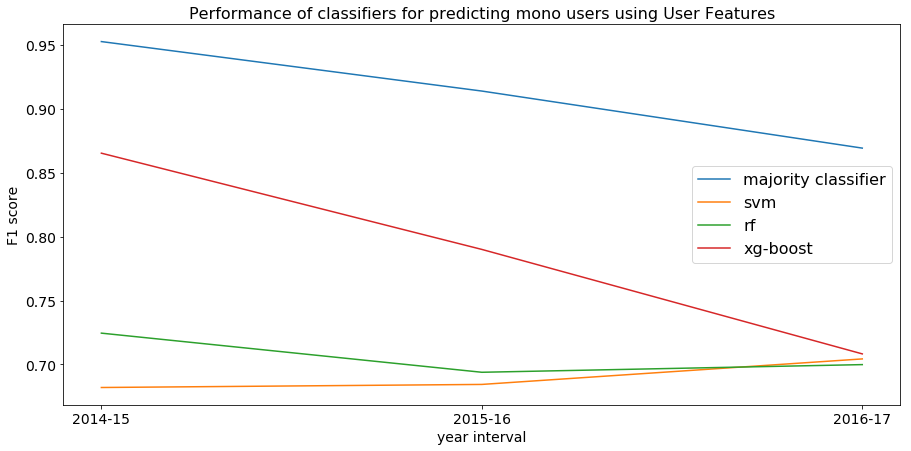

In [396]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
# maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
# plt.plot(years,maj_score_pos,label="majority classfier")
plt.plot(years,maj_score_neg,label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features",fontsize=16)
plt.ylabel("F1 score",fontsize=14)
plt.xlabel("year interval",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

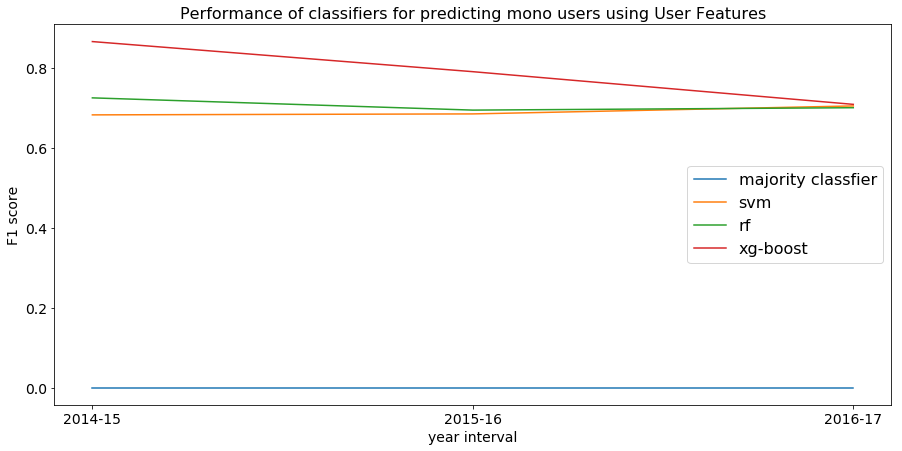

In [397]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
# maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority classfier")
# plt.plot(years,maj_score_neg,label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features",fontsize=16)
plt.ylabel("F1 score",fontsize=14)
plt.xlabel("year interval",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

### undersampling..

In [28]:
from sklearn.metrics import precision_recall_fscore_support
maj_scores_neg = []
maj_scores_pos = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos,average=None)[2][0]
    maj_scores_pos.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg,average=None)[2][0]
    maj_scores_neg.append(maj_neg) 

length of Y_test 210
positives in Y_test 19
length of Y_test 328
positives in Y_test 52
length of Y_test 8048
positives in Y_test 1861


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


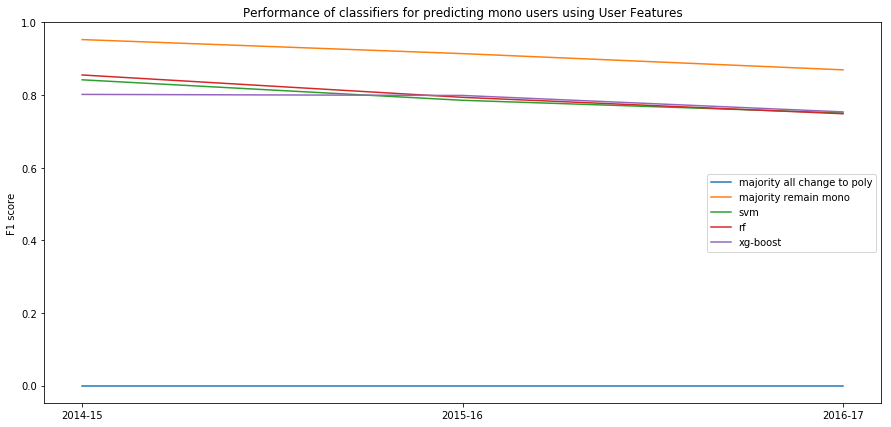

In [29]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

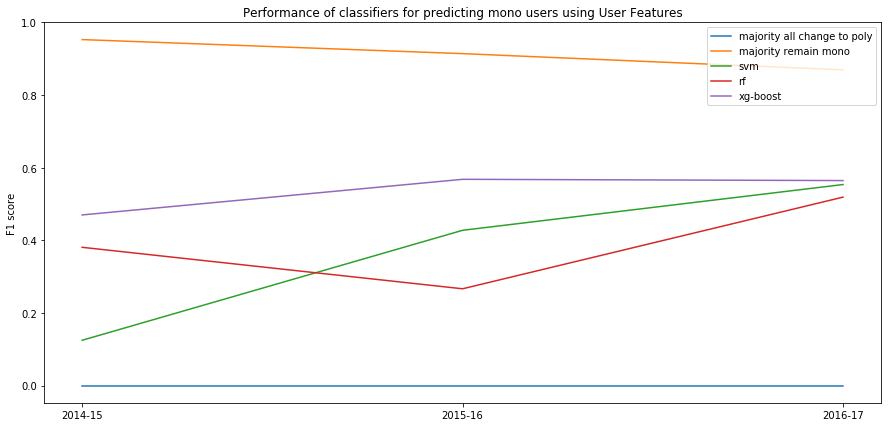

In [30]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [14]:
## using spectral clustering
# clustering = SpectralClustering(n_clusters=100,assign_labels="discretize",random_state=0, n_init=10, n_jobs=-1).fit(X)
# ## all the words are coming into one cluster
# len(cluster_dict[0]) ## 5761

In [260]:
data = juul_data[juul_data.tweetCreatedAt.dt.year == 2017]
all_users = data.userID.unique()

In [227]:
len(final_data.userID.unique())

1049

In [267]:
_ = get_year_data(2017,first_data,juul_data)

40680
total_users 40680
users that will change 9396


# combining user and text features

In [ ]:
## using k-1 fold algorithm for calculating cross val score for ensemble model
## making predictions on kth fold and passing it to the next stage for 2nd stage ensemble

# new ensemble way -- cross validated

In [32]:
import util
import driver
import preprocessing
import lstm as lstm_module
import baselines
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
def get_baseline_models():
    svm = LinearSVC(C=1, verbose=1)
    rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                                random_state=0)
    xgb = XGBClassifier()
    
    models = {
        "svm":svm,
        "rf":rf,
        "xgb":xgb
                 }
    return models

In [22]:
def get_cross_val_pred(model,X,Y,n_splits):
    y_preds = []
    for train, test in kFold.split(X, Y):
        model.fit(X[train], Y[train])
        y_preds.append(model.predict(X[test]))
    return y_preds

# combining All of the features for ml models

In [69]:
# Algorithm
# Split the train set in k folds
# Fit a first stage model on k-1 folds and predict the kth fold
# Repeat 2) to predict each fold

## preparing the data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
ml_models = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
        
    _,final_data = preprocessing.prepare_user_features(total_data)
        
    final_data["Text"] = total_data["tweetText"]
    Y_final = Y
    
    fold_scores = {"svm":[],"rf":[],"xgb":[]}
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y_final)):
        print("at split",split)
        Y_test =  Y_final[test_ind]
        Y_train = Y_final[train_ind]
        
        test_data = final_data.iloc[test_ind]
        train_data = final_data.iloc[train_ind]
        
        ## preapre text features
        X_train_svd,tf_idf, svd = encode_text_svd(train_data["Text"])
        X_test_svd = get_encoded_text_svd(test_data["Text"], tf_idf, svd)
        
        ## prepare user features
        X_train_text = train_data.loc[:, train_data.columns  !="Text"]
        X_test_text = test_data.loc[:, test_data.columns != "Text"]
        
        ## combine both of the features
        X_train = np.hstack((X_train_svd,X_train_text))
        X_test = np.hstack((X_test_svd,X_test_text))
        
        # oversample the data
        X_train, Y_train = util.get_oversample(X_train,Y_train)
        models = get_baseline_models()
        for name,model in models.items(): 
            model.fit(X_train,Y_train)
            y_pred = model.predict(X_test)
            print(name,"user Classification report \n",classification_report(y_pred,Y_test))
            score = (precision_recall_fscore_support(Y_test, y_pred, average=None)[2])
            fold_scores[name].append(score)
        ## getting lstm prediction
    for name,scores in fold_scores.items():
        score1 = np.mean([ele[0] for ele in scores])
        score2 = np.mean([ele[1] for ele in scores])
        fold_scores[name] = np.array([score1,score2])
        print(name,fold_scores[name])
    final_scores.append(fold_scores)
    Y_tests.append(Y_test)

100%|██████████| 1140/1140 [00:00<00:00, 2299.45it/s]


train-test split
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.77      0.94      0.84       171
          1       0.45      0.16      0.23        58

avg / total       0.69      0.74      0.69       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.80      0.94      0.86       178
          1       0.45      0.18      0.25        51

avg / total       0.72      0.77      0.73       229



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.93      0.92      0.93       211
          1       0.20      0.22      0.21        18

avg / total       0.88      0.87      0.87       229

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.71      0.94      0.81       159
          1       0.50      0.14      0.22        70

avg / total       0.65      0.69      0.63       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.80      0.93      0.86       180
          1       0.35      0.14      0.20        49

avg / total       0.70      0.76      0.72       229



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.93      0.93      0.93       208
          1       0.30      0.29      0.29        21

avg / total       0.87      0.87      0.87       229

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.93      0.88       184
          1       0.37      0.16      0.22        44

avg / total       0.74      0.79      0.75       228

rf user Classification report 
              precision    recall  f1-score   support

          0       0.87      0.92      0.89       196
          1       0.21      0.12      0.16        32

avg / total       0.77      0.81      0.79       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.96      0.92      0.94       217
          1       0.11      0.18      0.13        11

avg / total       0.92      0.89      0.90       228

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.84      0.95      0.89       185
          1       0.47      0.21      0.30        42

avg / total       0.77      0.81      0.78       227

rf user Classification report 
              precision    recall  f1-score   support

          0       0.79      0.95      0.86       172
          1       0.58      0.20      0.30        55

avg / total       0.74      0.77      0.73       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.92      0.93      0.92       205
          1       0.26      0.23      0.24        22

avg / total       0.85      0.86      0.86       227

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.79      0.94      0.86       176
          1       0.42      0.16      0.23        51

avg / total       0.71      0.76      0.72       227

rf user Classification report 
              precision    recall  f1-score   support

          0       0.84      0.93      0.88       187
          1       0.32      0.15      0.20        40

avg / total       0.74      0.79      0.76       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.93      0.92      0.92       212
          1       0.05      0.07      0.06        15

avg / total       0.87      0.86      0.87       227

svm [0.85543324 0.23977341]
rf [0.87193173 0.22279391]
xgb [0.92934864 0.18785371]


100%|██████████| 2861/2861 [00:01<00:00, 1858.39it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.92      0.77       367
          1       0.51      0.16      0.24       206

avg / total       0.60      0.64      0.58       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.68      0.94      0.79       368
          1       0.63      0.20      0.30       205

avg / total       0.66      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.91      0.86       458
          1       0.35      0.19      0.25       115

avg / total       0.72      0.77      0.74       573

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.93      0.79       382
          1       0.56      0.18      0.28       191

avg / total       0.65      0.68      0.62       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.93      0.78       368
          1       0.62      0.19      0.29       205

avg / total       0.65      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.93      0.87       454
          1       0.46      0.24      0.32       119

avg / total       0.75      0.78      0.76       573

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.94      0.78       359
          1       0.65      0.19      0.30       214

avg / total       0.66      0.66      0.60       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.95      0.76       343
          1       0.71      0.20      0.31       230

avg / total       0.67      0.65      0.58       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.80      0.92      0.86       446
          1       0.41      0.20      0.27       127

avg / total       0.72      0.76      0.73       573

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.71      0.94      0.81       385
          1       0.65      0.22      0.32       186

avg / total       0.69      0.71      0.65       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.93      0.78       364
          1       0.60      0.18      0.28       207

avg / total       0.64      0.66      0.59       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.92      0.87       448
          1       0.45      0.23      0.30       123

avg / total       0.74      0.77      0.74       571

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.94      0.75       339
          1       0.66      0.18      0.28       232

avg / total       0.64      0.63      0.56       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.94      0.73       325
          1       0.69      0.17      0.28       246

avg / total       0.64      0.61      0.54       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.75      0.91      0.83       421
          1       0.40      0.17      0.24       150

avg / total       0.66      0.72      0.67       571

svm [0.77953105 0.28220597]
rf [0.76838755 0.29020664]
xgb [0.85591966 0.27562166]


100%|██████████| 41902/41902 [00:15<00:00, 2791.02it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.86      0.74      4816
          1       0.66      0.35      0.46      3565

avg / total       0.65      0.65      0.62      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.84      0.75      5141
          1       0.58      0.34      0.43      3240

avg / total       0.63      0.65      0.62      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.87      0.74      4776
          1       0.68      0.36      0.47      3605

avg / total       0.66      0.65      0.62      8381

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4944
          1       0.63      0.35      0.45      3437

avg / total       0.64      0.65      0.62      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.68      0.84      0.75      5283
          1       0.55      0.34      0.42      3098

avg / total       0.63      0.65      0.63      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4905
          1       0.65      0.35      0.46      3476

avg / total       0.65      0.65      0.62      8381

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.85      0.74      5001
          1       0.61      0.35      0.44      3379

avg / total       0.64      0.65      0.62      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.85      0.75      5115
          1       0.59      0.34      0.43      3265

avg / total       0.64      0.65      0.62      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4919
          1       0.64      0.35      0.45      3461

avg / total       0.65      0.65      0.62      8380

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4875
          1       0.65      0.35      0.45      3505

avg / total       0.65      0.65      0.62      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.68      0.84      0.75      5250
          1       0.55      0.34      0.42      3130

avg / total       0.63      0.65      0.63      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.87      0.74      4791
          1       0.66      0.35      0.46      3589

avg / total       0.65      0.64      0.62      8380

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.86      0.74      4885
          1       0.64      0.35      0.45      3495

avg / total       0.64      0.65      0.62      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.84      0.75      5196
          1       0.56      0.33      0.42      3184

avg / total       0.63      0.65      0.62      8380

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.86      0.74      4858
          1       0.64      0.35      0.45      3522

avg / total       0.64      0.64      0.6

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [70]:
from sklearn.metrics import precision_recall_fscore_support
maj_mono = []
maj_poly = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos)[2][1]
    maj_poly.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg)[2][0]
    maj_mono.append(maj_neg)

length of Y_test 227
positives in Y_test 19
length of Y_test 571
positives in Y_test 62
length of Y_test 8380
positives in Y_test 1899


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


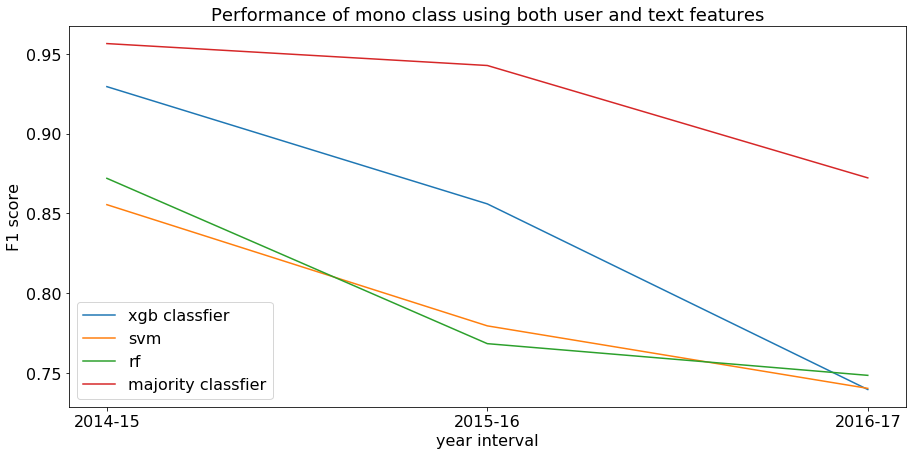

In [71]:
svm_scores = []
rf_scores = []
xgb_scores = []
all_mono = [score for score in maj_mono]
for scores in final_scores:
    svm_scores.append(scores["svm"][0])
    rf_scores.append(scores["rf"][0])
    xgb_scores.append(scores["xgb"][0])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_mono,label="majority classfier")
plt.title("Performance of mono class using both user and text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

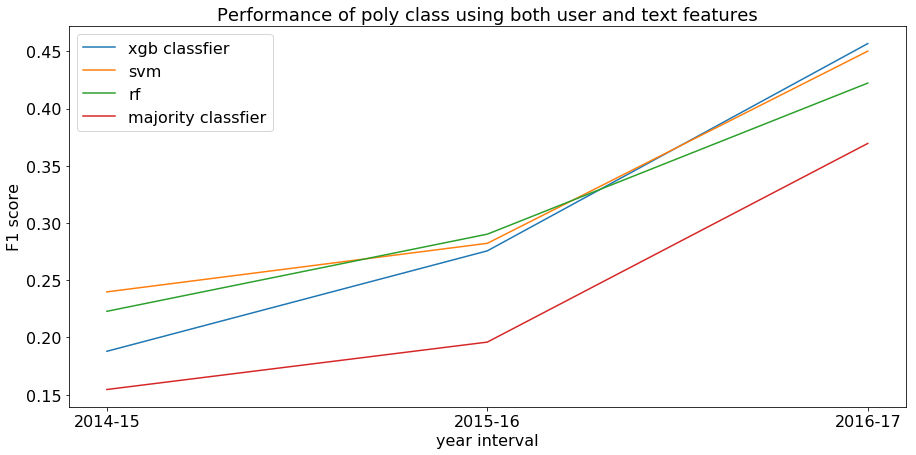

In [72]:
svm_scores = []
rf_scores = []
xgb_scores = []
all_poly = [score for score in maj_poly]
for scores in final_scores:
    svm_scores.append(scores["svm"][1])
    rf_scores.append(scores["rf"][1])
    xgb_scores.append(scores["xgb"][1])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_poly,label="majority classfier")
plt.title("Performance of poly class using both user and text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [75]:
poly_scores =  { "svm" : svm_scores,
           "rf" : rf_scores,
           "xgb" : xgb_scores,
}
print(poly_scores)

{'svm': [0.2397734141996437, 0.28220597148961035, 0.45012865403771213], 'rf': [0.22279391007780242, 0.2902066380649208, 0.4222217254754927], 'xgb': [0.18785370887764605, 0.27562165995001314, 0.45674065579971845]}


In [79]:
for model, score in poly_scores.items():
    print(model,np.mean(score))

svm 0.32403601324232206
rf 0.31174075787273864
xgb 0.30673867487579254


In [77]:
import pickle

with open(os.path.join(model_dir,"user_text_oversample.pkl"),"wb") as f:
    pickle.dump(final_scores,f)

In [78]:
final_scores

[{'svm': array([0.85543324, 0.23977341]),
  'rf': array([0.87193173, 0.22279391]),
  'xgb': array([0.92934864, 0.18785371])},
 {'svm': array([0.77953105, 0.28220597]),
  'rf': array([0.76838755, 0.29020664]),
  'xgb': array([0.85591966, 0.27562166])},
 {'svm': array([0.74038666, 0.45012865]),
  'rf': array([0.7485409 , 0.42222173]),
  'xgb': array([0.73967439, 0.45674066])}]

### predicting features of the model

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
final_models = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    

    _,final_data = preprocessing.prepare_user_features(total_data)
    
    ## adding text to final data
    final_data["Text"] = total_data["tweetText"]
    
    ## train-test split
    train_data,test_data,Y_train,Y_test = train_test_split(final_data, Y, test_size=0.20, 
                                                     random_state=4,shuffle=True, stratify=Y)
    
    
    ## preapre text features
    X_train_svd,tf_idf, svd = encode_text_svd(train_data["Text"])
    X_test_svd = get_encoded_text_svd(test_data["Text"], tf_idf, svd)

    ## prepare user features
    X_train_text = train_data.loc[:, train_data.columns  !="Text"]
    X_test_text = test_data.loc[:, test_data.columns != "Text"]

    ## combine both of the features
    X_train = np.hstack((X_train_svd,X_train_text))  ## first text and then user features
    X_test = np.hstack((X_test_svd,X_test_text))
    
    ## oversampling
    X_train,Y_train = util.get_oversample(X_train,Y_train)
    ml_models = {"svm":[],"rf":[],"xgb":[]}
    
    ml_models = {}
    models = get_baseline_models()
    for name,model in models.items(): 
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print(name,"user Classification report \n",classification_report(y_pred,Y_test))
        ml_models[name] = model 
    final_models.append(ml_models)

100%|██████████| 1140/1140 [00:00<00:00, 2427.45it/s]


train-test split
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.72      0.93      0.81       162
          1       0.42      0.12      0.19        66

avg / total       0.64      0.70      0.63       228

rf user Classification report 
              precision    recall  f1-score   support

          0       0.77      0.94      0.85       172
          1       0.42      0.14      0.21        56

avg / total       0.68      0.74      0.69       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.94      0.92      0.93       213
          1       0.11      0.13      0.12        15

avg / total       0.88      0.87      0.88       228



100%|██████████| 2861/2861 [00:01<00:00, 1902.00it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.68      0.94      0.79       371
          1       0.63      0.20      0.30       202

avg / total       0.67      0.68      0.62       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.94      0.78       366
          1       0.63      0.19      0.30       207

avg / total       0.66      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.77      0.91      0.83       433
          1       0.37      0.16      0.23       140

avg / total       0.67      0.73      0.69       573



100%|██████████| 41902/41902 [00:15<00:00, 2681.34it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.86      0.75      4983
          1       0.64      0.36      0.46      3398

avg / total       0.65      0.66      0.63      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.70      0.83      0.76      5429
          1       0.53      0.34      0.41      2952

avg / total       0.64      0.66      0.64      8381

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.87      0.75      4928
          1       0.65      0.36      0.46      3453

avg / total       0.66      0.66      0.63      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


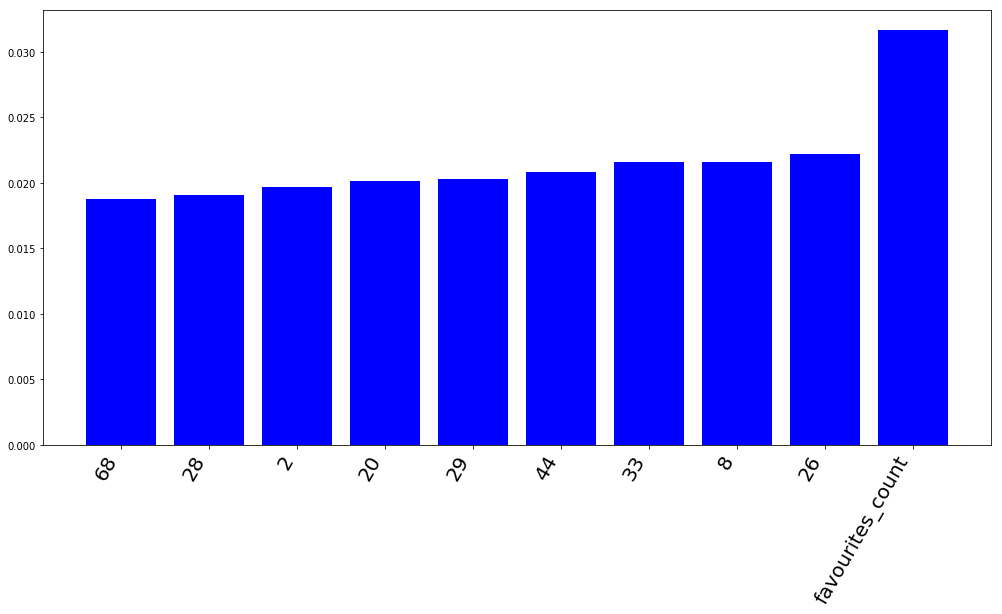

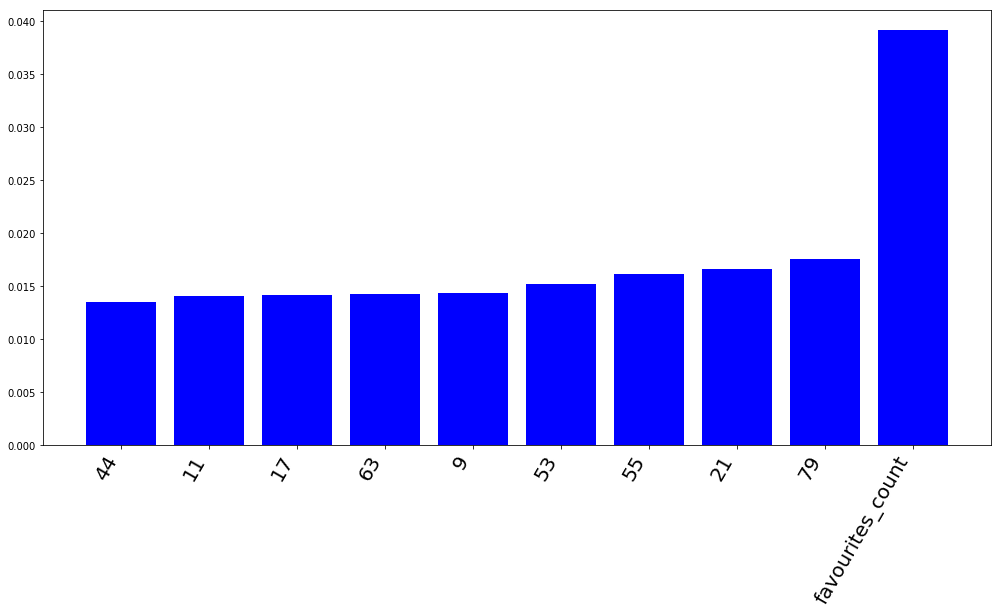

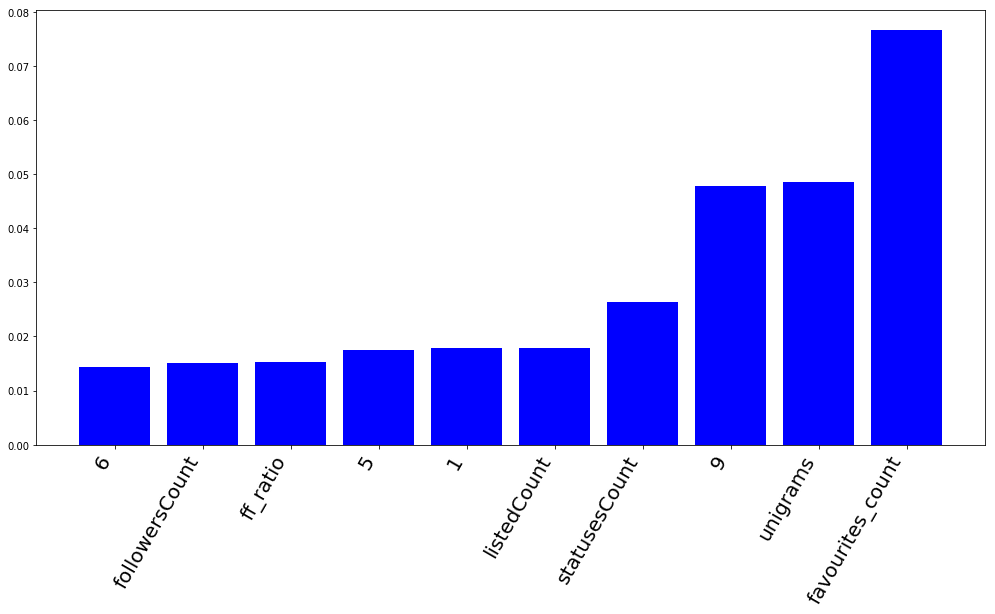

In [104]:
user_columns = list(final_data.loc[:, final_data.columns != "Text"].columns)
text_feat = [str(i) for i in range(100)]
columns = text_feat + user_columns

for model in final_models:
    xgb_ = model["xgb"]
    plot_model_coeff(xgb_,10,columns)

## capturing the text features

In [62]:
##  transform the data based on trained tfidf and svd
def get_encoded_text_svd(test_data, tf_idf, svd):
    X_test = tf_idf.transform(test_data)
    X_test = svd.transform(X_test)  ## reduce the dimensionality
    return X_test

In [63]:
## @ param : text data 
## @ return : svd transformed data
## vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
def encode_text_svd(data):
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    tf_idf.fit(data)  ## fit on train data
    temp_data = tf_idf.transform(data)
    svd.fit(temp_data)
    final_data = (svd.transform(temp_data))
    return (final_data,tf_idf, svd)
#     final_data = pd.DataFrame(text_data)

In [64]:
embedding_file = os.path.join(embeddings_dir, "glove.twitter.27B.100d.txt")
## prepare the tokenizer
# @return encoded data, max len , vocalb size and embeddign matrix
def prepare_lstm_data(data,dimension):
    max_len = util.get_max_length(data)
    if max_len > 60:
        max_len = 60
    print("max_length", max_len)
    keras_tkzr = lstm_module.fit_tokenizer(data)
    vocalb_size = len(keras_tkzr.word_index) + 1
    print("vocalb", vocalb_size)

    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = util.get_embedding_matrix(vocalb_size, dimension, util.embedding_file,
                                                 keras_tkzr)  ## tokenizer contains the vocalb info
    ## encoding the docs
    print("encoding the data")
    X = lstm_module.get_encoded_data(data, keras_tkzr, max_len)

    print("X-train", X.shape)
    
    return (X,keras_tkzr,max_len,vocalb_size,embedding_matrix)

100%|██████████| 911/911 [00:00<00:00, 230153.65it/s]


train-test split
final_data (1140, 1) Y 1140
at split 0
max_length 38
preparing the tokenizer
vocalb 3617
creating glove embeddign matrix
encoding the data
X-train (911, 38)
y 1668   1668
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 38)                0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 38, 100)           361700    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 402       
Total params: 522,902
Trainable params: 522,902
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
            

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.94      0.92      0.93       213
          1       0.15      0.19      0.17        16

avg / total       0.88      0.87      0.88       229

Train on 1251 samples, validate on 417 samples
Epoch 1/20
1251/1251 [==============================] - 10s 8ms/step - loss: 1.6009 - acc: 0.6579 - val_loss: 1.5049 - val_acc: 0.0695
Epoch 2/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.8258 - acc: 0.6962 - val_loss: 1.0494 - val_acc: 0.3333
Epoch 3/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.5274 - acc: 0.7794 - val_loss: 0.6602 - val_acc: 0.6906
Epoch 4/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3948 - acc: 0.8337 - val_loss: 0.5084 - val_acc: 0.7962
Epoch 5/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.2987 - acc: 0.8817 - val_loss: 0.3000 - val_acc: 0.8897
Epoch 6/20
1251/1251 [============

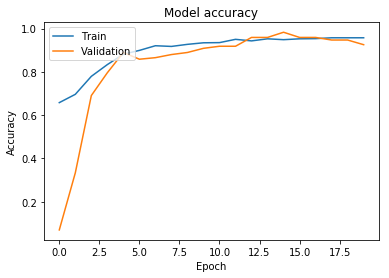

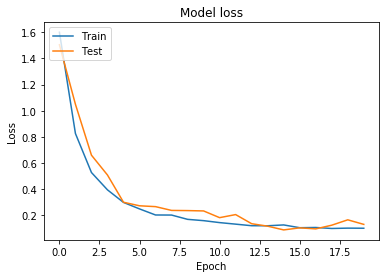

100%|██████████| 911/911 [00:00<00:00, 241515.13it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.95      0.93       209
          1       0.21      0.15      0.18        20

avg / total       0.86      0.88      0.87       229
 

at split 1
max_length 38
preparing the tokenizer
vocalb 3597
creating glove embeddign matrix


encoding the data
X-train (911, 38)
y 1668   1668
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 38)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 38, 100)           359700    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 402       
Total params: 520,902
Trainable params: 520,902
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.72      0.94      0.81       160
          1       0.50      0.14      0.22

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.93      0.92      0.93       211
          1       0.20      0.22      0.21        18

avg / total       0.88      0.87      0.87       229

Train on 1251 samples, validate on 417 samples
Epoch 1/20
1251/1251 [==============================] - 10s 8ms/step - loss: 1.5989 - acc: 0.6619 - val_loss: 1.3385 - val_acc: 0.3861
Epoch 2/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.8326 - acc: 0.7002 - val_loss: 0.9863 - val_acc: 0.4173
Epoch 3/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.5358 - acc: 0.7818 - val_loss: 0.5929 - val_acc: 0.7290
Epoch 4/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3813 - acc: 0.8489 - val_loss: 0.4085 - val_acc: 0.7962
Epoch 5/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3096 - acc: 0.8713 - val_loss: 0.2673 - val_acc: 0.8849
Epoch 6/20
1251/1251 [============

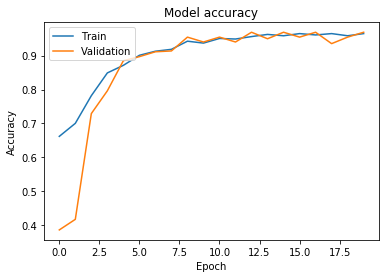

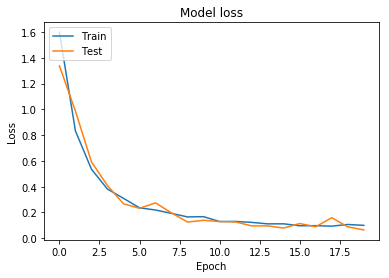

100%|██████████| 912/912 [00:00<00:00, 165128.65it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.91      0.92       209
          1       0.18      0.20      0.19        20

avg / total       0.86      0.85      0.85       229
 

at split 2
max_length 38
preparing the tokenizer
vocalb 3614
creating glove embeddign matrix


encoding the data
X-train (912, 38)
y 1668   1668
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 38)                0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 38, 100)           361400    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 402       
Total params: 522,602
Trainable params: 522,602
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.90      0.85       187
          1       0.05      0.02      0.03

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.95      0.91      0.93       217
          1       0.00      0.00      0.00        11

avg / total       0.90      0.87      0.88       228

Train on 1251 samples, validate on 417 samples
Epoch 1/20
1251/1251 [==============================] - 11s 9ms/step - loss: 1.6045 - acc: 0.6523 - val_loss: 1.3638 - val_acc: 0.0504
Epoch 2/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.8300 - acc: 0.6994 - val_loss: 1.0474 - val_acc: 0.4436
Epoch 3/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.5228 - acc: 0.7978 - val_loss: 0.8436 - val_acc: 0.6235
Epoch 4/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3921 - acc: 0.8497 - val_loss: 0.3633 - val_acc: 0.9137
Epoch 5/20
1251/1251 [==============================] - 4s 3ms/step - loss: 0.3123 - acc: 0.8729 - val_loss: 0.2388 - val_acc: 0.9257
Epoch 6/20
1251/1251 [============

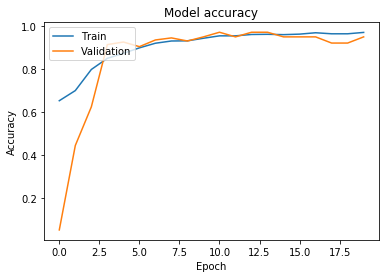

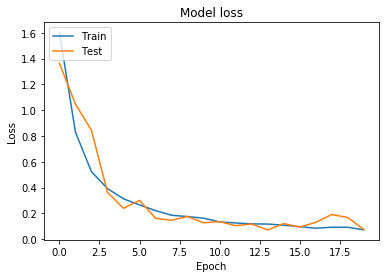

100%|██████████| 913/913 [00:00<00:00, 217480.67it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.94      0.93       209
          1       0.14      0.11      0.12        19

avg / total       0.86      0.87      0.86       228
 

at split 3
max_length 44
preparing the tokenizer
vocalb 3784
creating glove embeddign matrix


encoding the data
X-train (913, 44)
y 1670   1670
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 44)                0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 44, 100)           378400    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 402       
Total params: 539,602
Trainable params: 539,602
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.79      0.93      0.85       178
          1       0.32      0.12      0.18

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.88      0.92      0.90       200
          1       0.16      0.11      0.13        27

avg / total       0.80      0.82      0.81       227

Train on 1252 samples, validate on 418 samples
Epoch 1/20
1252/1252 [==============================] - 12s 9ms/step - loss: 1.6041 - acc: 0.6446 - val_loss: 1.5327 - val_acc: 0.0000e+00
Epoch 2/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.8175 - acc: 0.7021 - val_loss: 0.9845 - val_acc: 0.4713
Epoch 3/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.5197 - acc: 0.8003 - val_loss: 0.6283 - val_acc: 0.7656
Epoch 4/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3984 - acc: 0.8315 - val_loss: 0.3032 - val_acc: 0.9043
Epoch 5/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3058 - acc: 0.8810 - val_loss: 0.2377 - val_acc: 0.9211
Epoch 6/20
1252/1252 [========

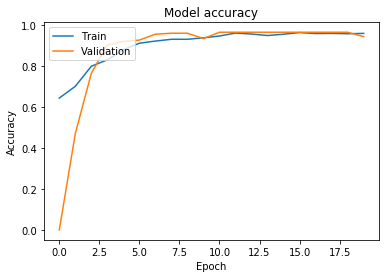

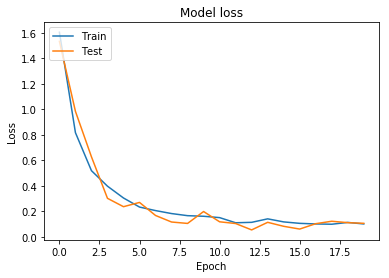

100%|██████████| 913/913 [00:00<00:00, 235120.01it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.92      0.94      0.93       208
          1       0.20      0.16      0.18        19

avg / total       0.86      0.88      0.87       227
 

at split 4
max_length 39
preparing the tokenizer
vocalb 3631
creating glove embeddign matrix


encoding the data
X-train (913, 39)
y 1670   1670
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 39)                0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 39, 100)           363100    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 402       
Total params: 524,302
Trainable params: 524,302
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.92      0.86       184
          1       0.21      0.09      0.13

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.91      0.92      0.92       207
          1       0.11      0.10      0.10        20

avg / total       0.84      0.85      0.84       227

Train on 1252 samples, validate on 418 samples
Epoch 1/20
1252/1252 [==============================] - 11s 9ms/step - loss: 1.6106 - acc: 0.6605 - val_loss: 1.4369 - val_acc: 0.1699
Epoch 2/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.8407 - acc: 0.7021 - val_loss: 1.0911 - val_acc: 0.3708
Epoch 3/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.5406 - acc: 0.7931 - val_loss: 0.6659 - val_acc: 0.7273
Epoch 4/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3883 - acc: 0.8395 - val_loss: 0.3938 - val_acc: 0.8517
Epoch 5/20
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3146 - acc: 0.8722 - val_loss: 0.2907 - val_acc: 0.8995
Epoch 6/20
1252/1252 [============

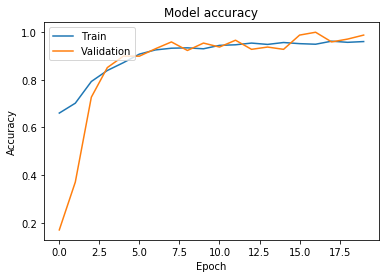

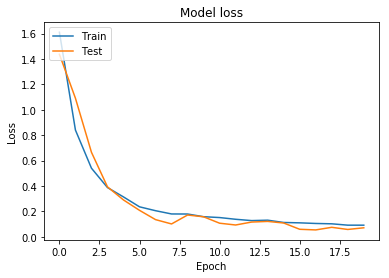

  0%|          | 0/2861 [00:00<?, ?it/s]

  Classification Report lstm:
              precision    recall  f1-score   support

          0       0.91      0.90      0.91       208
          1       0.05      0.05      0.05        19

avg / total       0.84      0.83      0.84       227
 

svm [0.84860914 0.14853195]
rf [0.84479998 0.1353039 ]
xgb [0.92093646 0.12203837]
lstm [0.92504389 0.1429259 ]


100%|██████████| 2288/2288 [00:00<00:00, 210566.48it/s]


train-test split
final_data (2861, 1) Y 2861
at split 0
max_length 40
preparing the tokenizer
vocalb 7134
creating glove embeddign matrix
encoding the data
X-train (2288, 40)
y 4076   4076
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 40, 100)           713400    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 402       
Total params: 874,602
Trainable params: 874,602
Non-trainable params: 0
_________________________________________________________________
None
[LibLinear]svm user Classification report 
           

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.83      0.89      0.86       472
          1       0.21      0.13      0.16       101

avg / total       0.72      0.76      0.74       573

Train on 3057 samples, validate on 1019 samples
Epoch 1/20
3057/3057 [==============================] - 17s 6ms/step - loss: 1.1427 - acc: 0.6627 - val_loss: 1.0498 - val_acc: 0.1079
Epoch 2/20
3057/3057 [==============================] - 10s 3ms/step - loss: 0.5780 - acc: 0.7053 - val_loss: 0.8406 - val_acc: 0.4907
Epoch 3/20
3057/3057 [==============================] - 10s 3ms/step - loss: 0.4784 - acc: 0.7697 - val_loss: 0.6653 - val_acc: 0.6006
Epoch 4/20
3057/3057 [==============================] - 10s 3ms/step - loss: 0.3872 - acc: 0.8247 - val_loss: 0.5569 - val_acc: 0.6948
Epoch 5/20
3057/3057 [==============================] - 10s 3ms/step - loss: 0.3025 - acc: 0.8724 - val_loss: 0.3898 - val_acc: 0.8479
Epoch 6/20
3057/3057 [=======

In [ ]:
## check with lstm

## preparing the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()
dimension = 100
epoch = 20
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
        
    ## combining all of user and text data
    final_data = pd.DataFrame()
    final_data["Text"] = pd.DataFrame(total_data["tweetText"])
    print("final_data",final_data.shape,"Y",len(Y))
    
    
    fold_scores = {"svm":[],"rf":[],"xgb":[],"lstm":[]}
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y)):
        print("at split",split)
        Y_test =  Y[test_ind]
        Y_train = Y[train_ind]
        
        test_data = final_data.iloc[test_ind]
        train_data = final_data.iloc[train_ind]
        
        ## preparing train,test lstm
        X_train_lstm,keras_tkzr,max_len,vocalb_size,embedding_matrix = prepare_lstm_data(train_data["Text"],dimension)
        X_test_lstm = lstm_module.get_encoded_data(test_data["Text"],keras_tkzr,max_len)
        
        ## preparing train,test tf_idf svd
        X_train_svd,tf_idf, svd = encode_text_svd(train_data["Text"])
        X_test_svd = get_encoded_text_svd(test_data["Text"], tf_idf, svd)
        
        ## oversample the train data
        X_train_svd, Y_train_ = util.get_oversample(X_train_svd,Y_train)
        X_train_lstm, Y_train = util.get_oversample(X_train_lstm,Y_train)
        
        print("y",len(Y_train)," ",len(Y_train_))
        
        ## preparing the models
        models = get_baseline_models()
        lstm_model = lstm_module.create_model(max_len,vocalb_size,100,embedding_matrix)
        for name,model in models.items(): 
            model.fit(X_train_svd,Y_train)
            y_pred = model.predict(X_test_svd)
            print(name,"user Classification report \n",classification_report(y_pred,Y_test))
            score = (precision_recall_fscore_support(y_pred, Y_test, average=None)[2])
            fold_scores[name].append(score)
        
        ## getting lstm prediction
        history = lstm_model.fit(X_train_lstm,Y_train,validation_split=0.25, nb_epoch=epoch,verbose=1, batch_size=32)
        lstm_module.training_plot(history) ## plotting the training history lstm
        lstm_pred_ = lstm_model.predict(X_test_lstm)
        lstm_pred = [np.argmax(value) for value in lstm_pred_]  ## sigmoid
        print('  Classification Report lstm:\n', classification_report(Y_test, lstm_pred), '\n')
        score = (precision_recall_fscore_support(Y_test, lstm_pred, average=None)[2])
        fold_scores["lstm"].append(score)
    
    for name,scores in fold_scores.items():
        score1 = np.mean([ele[0] for ele in scores])
        score2 = np.mean([ele[1] for ele in scores])
        fold_scores[name] = np.array([score1,score2])
        print(name,fold_scores[name])
    final_scores.append(fold_scores)
    Y_tests.append(Y_test)

In [29]:
final_scores
import pickle

with open(os.path.join(model_dir,"text_oversample.pkl"),"wb") as f:
    pickle.dump(final_scores,f)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xavlock2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## plot the text features

In [36]:
from sklearn.metrics import precision_recall_fscore_support
maj_mono = []
maj_poly = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos)[2][1]
    maj_poly.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg)[2][0]
    maj_mono.append(maj_neg)

length of Y_test 227
positives in Y_test 19
length of Y_test 384
positives in Y_test 54
length of Y_test 8135
positives in Y_test 1879


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


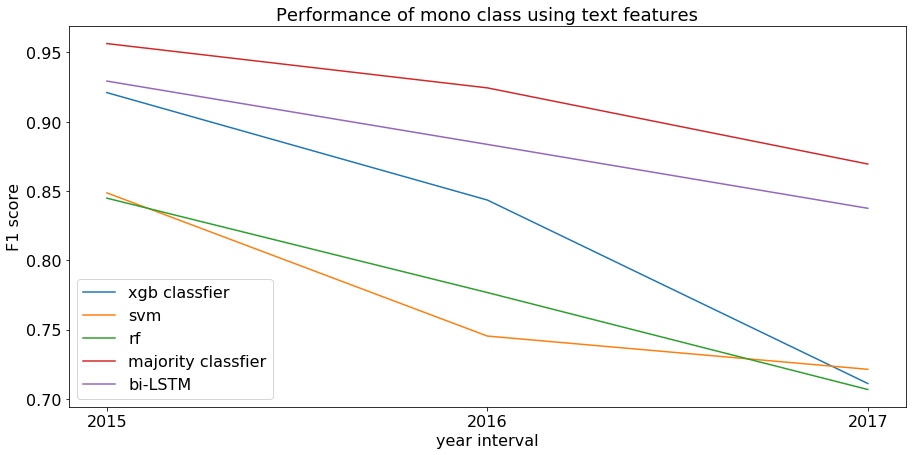

In [37]:
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores= []
all_mono = [score for score in maj_mono]
for scores in final_scores:
    svm_scores.append(scores["svm"][0])
    rf_scores.append(scores["rf"][0])
    xgb_scores.append(scores["xgb"][0])
    lstm_scores.append(scores["lstm"][0])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2015","2016","2017"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_mono,label="majority classfier")
plt.plot(years,lstm_scores,label="bi-LSTM")
plt.title("Performance of mono class using text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

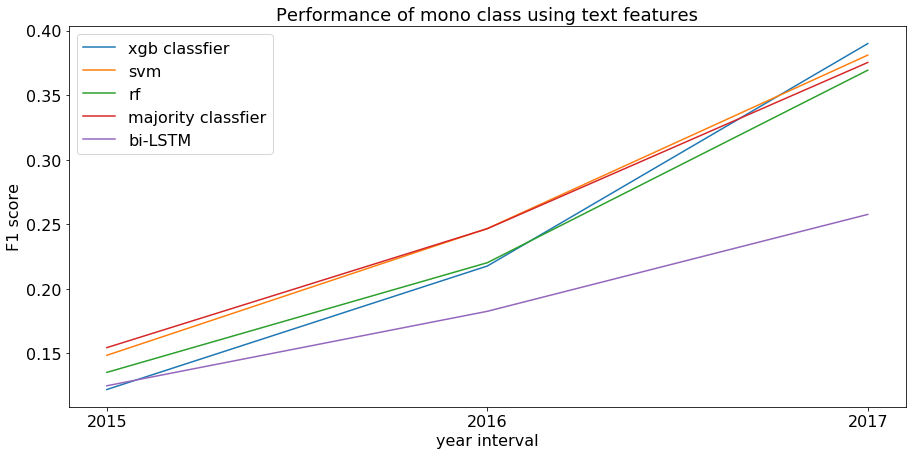

In [38]:
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores= []
all_poly = [score for score in maj_poly]
for scores in final_scores:
    svm_scores.append(scores["svm"][1])
    rf_scores.append(scores["rf"][1])
    xgb_scores.append(scores["xgb"][1])
    lstm_scores.append(scores["lstm"][1])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2015","2016","2017"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_poly,label="majority classfier")
plt.plot(years,lstm_scores,label="bi-LSTM")
plt.title("Performance of mono class using text features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## relevance of text features

In [393]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
final_models = []
vectorizer = []
for year,data,users_labelled in bucket_data[:2]:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
    train_data,test_data,Y_train,Y_test = train_test_split(total_data, Y, test_size=0.20, 
                                                     random_state=4,shuffle=True, stratify=Y)
    
    ## preparing train,test tf_idf svd
    X_train,tf_idf, svd = encode_text_svd(train_data["tweetText"])
    X_test = get_encoded_text_svd(test_data["tweetText"], tf_idf, svd)

    ## oversample the train data
    X_train, Y_train = util.get_oversample(X_train,Y_train)
    
    ml_models = {"svm":[],"rf":[],"xgb":[]}
    
    models = get_baseline_models()
    for name,model in models.items(): 
        model.fit(X_train,Y_train)
        ml_models[name] = model 
    vectorizer.append(tf_idf)
    final_models.append(ml_models)



  0%|          | 0/1140 [00:00<?, ?it/s]

100%|██████████| 1140/1140 [00:00<00:00, 64827.83it/s]

  0%|          | 0/1140 [00:00<?, ?it/s]

 41%|████      | 470/1140 [00:00<00:00, 4633.27it/s]

 71%|███████   | 806/1140 [00:00<00:00, 4159.84it/s]

100%|██████████| 1140/1140 [00:00<00:00, 4182.71it/s]

train-test split
text_data (1140, 4121) Y 61860
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.92      0.92      0.92       210
          1       0.11      0.11      0.11        18

avg / total       0.86      0.86      0.86       228





  0%|          | 0/1925 [00:00<?, ?it/s]

100%|██████████| 1925/1925 [00:00<00:00, 56862.61it/s]

  0%|          | 0/1925 [00:00<?, ?it/s]

rf user Classification report 
              precision    recall  f1-score   support

          0       0.87      0.93      0.90       196
          1       0.26      0.16      0.20        32

avg / total       0.79      0.82      0.80       228





 20%|█▉        | 378/1925 [00:00<00:00, 3773.79it/s]

 36%|███▌      | 686/1925 [00:00<00:00, 3534.70it/s]

 59%|█████▊    | 1127/1925 [00:00<00:00, 3754.07it/s]

 79%|███████▊  | 1513/1925 [00:00<00:00, 3776.93it/s]

 94%|█████████▍| 1805/1925 [00:00<00:00, 2473.33it/s]

100%|██████████| 1925/1925 [00:00<00:00, 2991.40it/s]

train-test split
text_data (1925, 6086) Y 61860
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.87      0.87      0.87       330
          1       0.20      0.20      0.20        55

avg / total       0.77      0.77      0.77       385

rf user Classification report 
              precision    recall  f1-score   support

          0       0.84      0.87      0.85       318
          1       0.24      0.19      0.21        67

avg / total       0.73      0.75      0.74       385



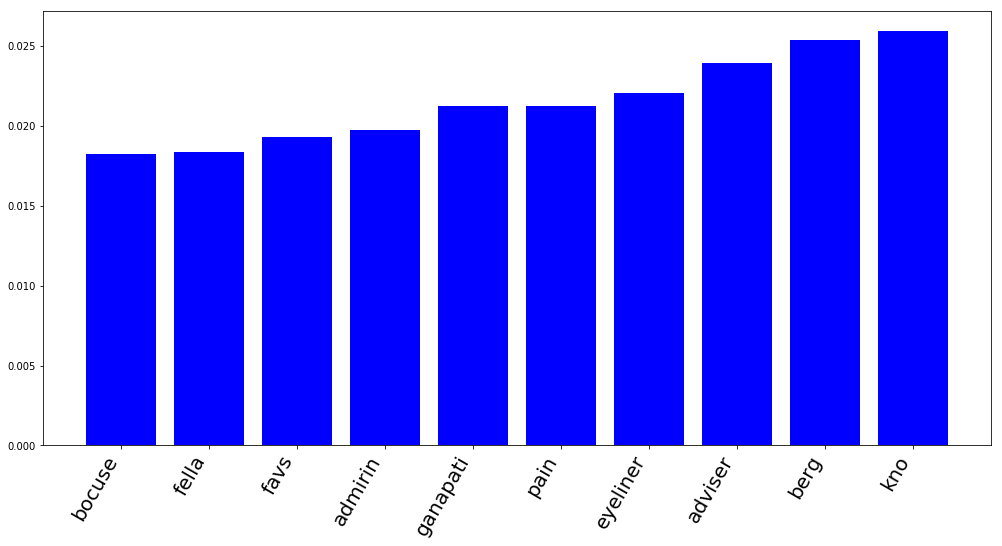

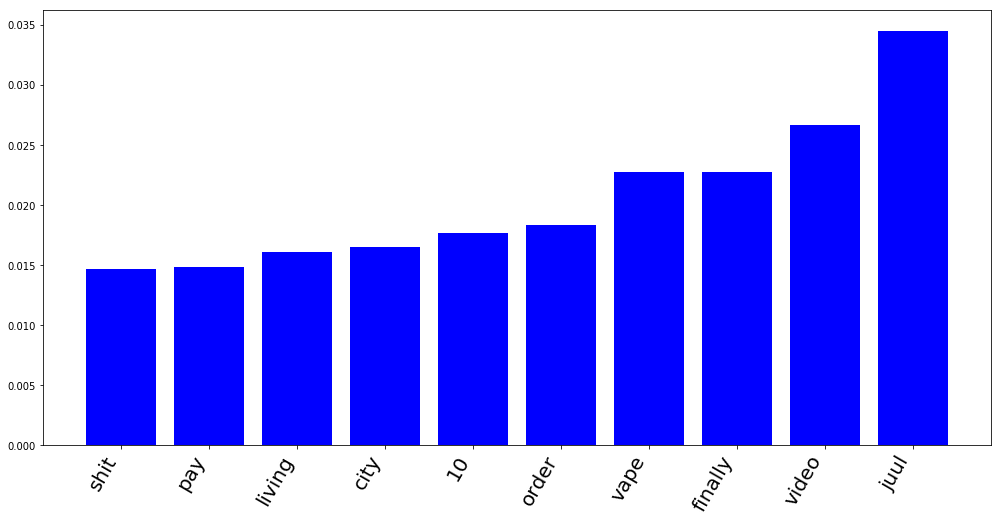

In [395]:
for model,tf_idf in zip(final_models,vectorizer):
    xgb_ = model["rf"]
    plot_model_coeff(xgb_,10,list(tf_idf.get_feature_names()))

## predicting with the user features

In [39]:
# Algorithm
# Split the train set in k folds
# Fit a first stage model on k-1 folds and predict the kth fold
# Repeat 2) to predict each fold

## preparing the data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
    # vectorize the text
#     tf_idf.fit(total_data["tweetText"])  ## fit on train data
#     temp_data = tf_idf.transform(total_data["tweetText"])
#     svd.fit(temp_data)
#     text_data = (svd.transform(temp_data))
    
    _,final_data = preprocessing.prepare_user_features(total_data)
    
#     print("text_data",text_data.shape,"Y",len(Y_text))
    print("final_data",final_data.shape,"Y",len(Y))
    
    ## combining all of user and text data
#     final_data = pd.DataFrame(text_data)
#     final_data = pd.concat([text_data.reset_index(drop=True), user_data.reset_index(drop=True)], axis= 1)
    Y_final = Y
    
    
    fold_scores = {"svm":[],"rf":[],"xgb":[]}
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y_final)):
        print("at split",split)
        X_test = final_data.iloc[test_ind].values
        Y_test =  Y_final[test_ind]
        
        Y_train = Y_final[train_ind]
        X_train = final_data.iloc[train_ind].values
        X_train, Y_train = util.get_oversample(X_train,Y_train)
        
        models = get_baseline_models()
        for name,model in models.items(): 
            model.fit(X_train,Y_train)
            y_pred = model.predict(X_test)
            print(name,"user Classification report \n",classification_report(y_pred,Y_test))
            score = (precision_recall_fscore_support(Y_test, y_pred, average=None)[2])
            fold_scores[name].append(score)
        ## getting lstm prediction
    for name,scores in fold_scores.items():
        score1 = np.mean([ele[0] for ele in scores])
        score2 = np.mean([ele[1] for ele in scores])
        fold_scores[name] = np.array([score1,score2])
        print(name,fold_scores[name])
    final_scores.append(fold_scores)
    Y_tests.append(Y_test)

100%|██████████| 1140/1140 [00:00<00:00, 2407.47it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

final_data (1140, 7) Y 1140
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.95      0.77       141
          1       0.65      0.15      0.24        88

avg / total       0.64      0.64      0.56       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.93      0.74       137
          1       0.55      0.12      0.20        92

avg / total       0.59      0.61      0.52       229

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.85      0.92      0.88       194
          1       0.20      0.11      0.15        35

avg / total       0.75      0.79      0.77       229

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.94      0.72       130
          1       0.60      0.12      0.20   

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


rf user Classification report 
              precision    recall  f1-score   support

          0       0.57      0.94      0.71       128
          1       0.60      0.12      0.20       101

avg / total       0.59      0.58      0.49       229

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.93      0.87       181
          1       0.40      0.17      0.24        48

avg / total       0.72      0.77      0.73       229

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.93      0.73       135
          1       0.53      0.11      0.18        93

avg / total       0.57      0.60      0.51       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.96      0.79       146
          1       0.68      0.16      0.26        82

avg / total       0.68      0.67      0.60       228

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.85      0.94      0.89       189
          1       0.37      0.18      0.24        39

avg / total       0.77      0.81      0.78       228

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.95      0.77       142
          1       0.63      0.14      0.23        85

avg / total       0.64      0.65      0.57       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


rf user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.96      0.78       142
          1       0.68      0.15      0.25        85

avg / total       0.67      0.66      0.58       227

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.82      0.91      0.87       187
          1       0.16      0.07      0.10        40

avg / total       0.71      0.77      0.73       227

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.53      0.97      0.69       115
          1       0.79      0.13      0.23       112

avg / total       0.66      0.56      0.46       227



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.97      0.74       128
          1       0.79      0.15      0.25        99

avg / total       0.68      0.61      0.53       227

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.81      0.92      0.86       183
          1       0.26      0.11      0.16        44

avg / total       0.71      0.77      0.73       227

svm [0.7353543  0.21615394]
rf [0.75120421 0.23128774]
xgb [0.8739523  0.17651061]


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
100%|██████████| 2861/2861 [00:01<00:00, 1941.85it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

final_data (2861, 7) Y 2861
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.97      0.70       287
          1       0.86      0.19      0.31       286

avg / total       0.70      0.58      0.50       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.95      0.74       324
          1       0.75      0.19      0.30       249

avg / total       0.67      0.62      0.55       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.95      0.78       358
          1       0.70      0.20      0.32       215

avg / total       0.68      0.67      0.61       573

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.95      0.72       309
          1       0.78      0.19      0.30       264

avg / total       0.67      0.60      0.53       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.95      0.69       293
          1       0.76      0.17      0.28       280

avg / total       0.65      0.57      0.49       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.93      0.79       377
          1       0.59      0.19      0.29       196

avg / total       0.65      0.68      0.62       573

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.57      0.97      0.72       298
          1       0.87      0.20      0.33       275

avg / total       0.71      0.60      0.53       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.54      0.96      0.69       286
          1       0.83      0.18      0.30       287

avg / total       0.68      0.57      0.49       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.94      0.80       373
          1       0.67      0.21      0.32       200

avg / total       0.68      0.69      0.63       573

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.95      0.70       294
          1       0.77      0.17      0.28       277

avg / total       0.66      0.57      0.50       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.56      0.94      0.70       302
          1       0.69      0.16      0.26       269

avg / total       0.62      0.57      0.49       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.94      0.80       374
          1       0.65      0.20      0.31       197

avg / total       0.68      0.69      0.63       571

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.51      0.96      0.66       270
          1       0.81      0.17      0.28       301

avg / total       0.66      0.54      0.46       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.52      0.96      0.67       277
          1       0.81      0.17      0.28       294

avg / total       0.67      0.55      0.47       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.94      0.76       348
          1       0.66      0.18      0.29       223

avg / total       0.65      0.64      0.58       571

svm [0.69912021 0.2986523 ]
rf [0.69883429 0.28380518]
xgb [0.78604579 0.30365046]


100%|██████████| 41902/41902 [00:15<00:00, 2768.64it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

final_data (41902, 7) Y 41902
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.87      0.72      4577
          1       0.68      0.34      0.45      3804

avg / total       0.64      0.63      0.60      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4100
          1       0.71      0.31      0.44      4281

avg / total       0.63      0.58      0.55      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.87      0.73      4615
          1       0.69      0.35      0.46      3766

avg / total       0.65      0.64      0.61      8381

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.71      4624
          1       0.66      0.33      0.44      3757

avg / total       0.63      0.62      0.59      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4150
          1       0.68      0.31      0.42      4231

avg / total       0.62      0.58      0.55      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4712
          1       0.65      0.34      0.44      3669

avg / total       0.64      0.63      0.60      8381

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4664
          1       0.65      0.33      0.44      3716

avg / total       0.63      0.63      0.60      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.86      0.69      4356
          1       0.67      0.32      0.43      4024

avg / total       0.62      0.60      0.57      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.63      0.86      0.73      4783
          1       0.64      0.34      0.44      3597

avg / total       0.63      0.63      0.60      8380

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.72      4608
          1       0.66      0.33      0.44      3772

avg / total       0.64      0.62      0.59      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4113
          1       0.70      0.31      0.43      4267

avg / total       0.62      0.58      0.55      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4660
          1       0.66      0.34      0.45      3720

avg / total       0.64      0.63      0.60      8380

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.71      4611
          1       0.65      0.33      0.43      3769

avg / total       0.63      0.62      0.59      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.52      0.87      0.65      3908
          1       0.73      0.31      0.43      4472

avg / total       0.63      0.57      0.54      8380

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.87      0.72      4647
          1       0.67      0.34      0.45      3733

avg / total       0.64      0.63      0.6

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


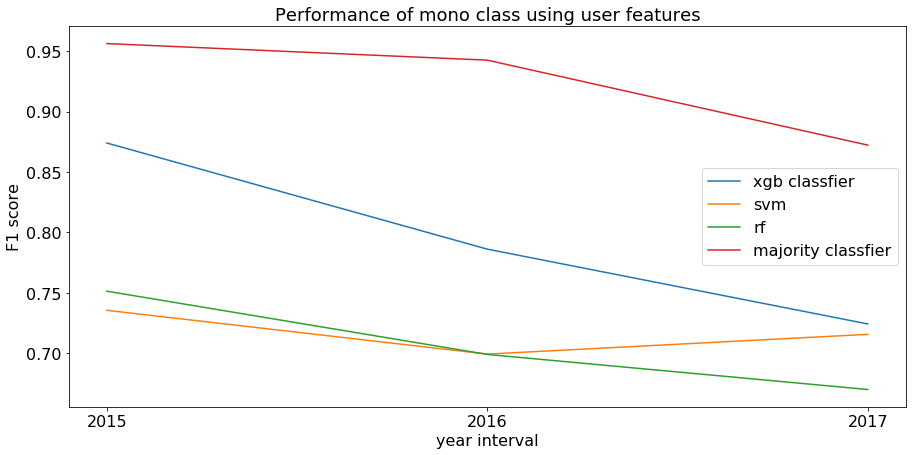

In [40]:
svm_scores = []
rf_scores = []
xgb_scores = []
all_mono = [score for score in maj_mono]
for scores in final_scores:
    svm_scores.append(scores["svm"][0])
    rf_scores.append(scores["rf"][0])
    xgb_scores.append(scores["xgb"][0])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2015","2016","2017"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_mono,label="majority classfier")
plt.title("Performance of mono class using user features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

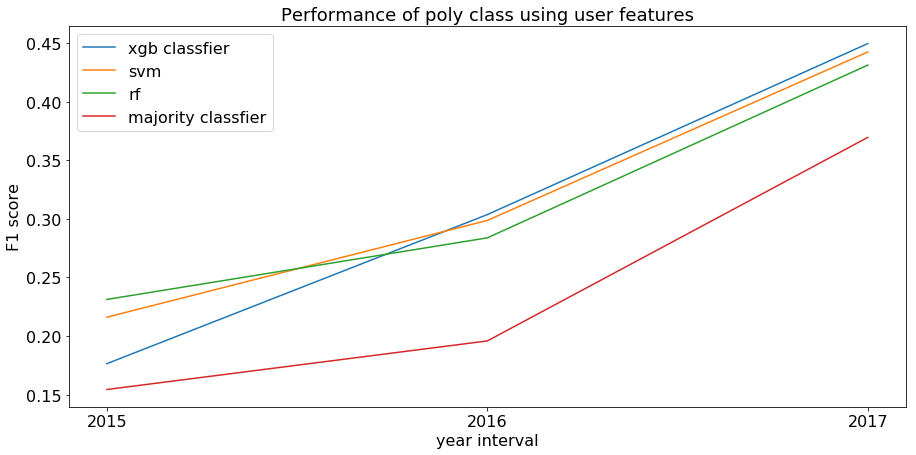

In [41]:
svm_scores = []
rf_scores = []
xgb_scores = []
all_poly = [score for score in maj_poly]
for scores in final_scores:
    svm_scores.append(scores["svm"][1])
    rf_scores.append(scores["rf"][1])
    xgb_scores.append(scores["xgb"][1])
## plotting user features
plt.figure(figsize=(15,7))
years = ["2015","2016","2017"]
plt.plot(years,xgb_scores,label="xgb classfier")
plt.plot(years,svm_scores,label="svm")
plt.plot(years,rf_scores,label="rf")
plt.plot(years,all_poly,label="majority classfier")
plt.title("Performance of poly class using user features",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [46]:
poly_scores =  { "svm" : svm_scores,
           "rf" : rf_scores,
           "xgb" : xgb_scores,
}
print(poly_scores)

{'svm': [0.21615394118761877, 0.2986522996698243, 0.44236961584393847], 'rf': [0.23128774191528773, 0.2838051795742852, 0.43115868775006555], 'xgb': [0.17651060948616557, 0.30365045808222507, 0.4495033095077442]}


In [47]:
for model, score in poly_scores.items():
    print(model,np.mean(score))

svm 0.3190586189004605
rf 0.31541720307987947
xgb 0.30988812569204494


In [44]:
import pickle

with open(os.path.join(model_dir,"user_oversample.pkl"),"wb") as f:
    pickle.dump(final_scores,f)

In [48]:
final_scores

[{'svm': array([0.7353543 , 0.21615394]),
  'rf': array([0.75120421, 0.23128774]),
  'xgb': array([0.8739523 , 0.17651061])},
 {'svm': array([0.69912021, 0.2986523 ]),
  'rf': array([0.69883429, 0.28380518]),
  'xgb': array([0.78604579, 0.30365046])},
 {'svm': array([0.71545435, 0.44236962]),
  'rf': array([0.66977735, 0.43115869]),
  'xgb': array([0.72408211, 0.44950331])}]

## relevance of user features

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
model_scores = {}
final_scores = []
Y_tests = []
final_models = []
vectorizer = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
    _,user_data = preprocessing.prepare_user_features(total_data)
        
    ## combining all of user and text data
    X = user_data.values
    
    X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.20, 
                                                     random_state=4,shuffle=True, stratify=Y)
    
    X_train,Y_train = util.get_oversample(X_train,Y_train)
    ml_models = {"svm":[],"rf":[],"xgb":[]}
    
    ml_models = {}
    models = get_baseline_models()
    for name,model in models.items(): 
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print(name,"user Classification report \n",classification_report(y_pred,Y_test))
        ml_models[name] = model 
    final_models.append(ml_models)

100%|██████████| 1140/1140 [00:00<00:00, 2462.59it/s]


train-test split
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.95      0.72       127
          1       0.68      0.13      0.22       101

avg / total       0.63      0.59      0.50       228

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.95      0.74       133
          1       0.63      0.13      0.21        95

avg / total       0.61      0.61      0.52       228

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.80      0.94      0.87       178
          1       0.47      0.18      0.26        50

avg / total       0.73      0.78      0.74       228



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
100%|██████████| 2861/2861 [00:01<00:00, 1952.18it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.54      0.98      0.70       283
          1       0.89      0.19      0.32       290

avg / total       0.72      0.58      0.50       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.54      0.96      0.69       285
          1       0.81      0.18      0.29       288

avg / total       0.67      0.57      0.49       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.94      0.78       363
          1       0.65      0.20      0.30       210

avg / total       0.66      0.67      0.60       573



100%|██████████| 41902/41902 [00:14<00:00, 2807.81it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4673
          1       0.66      0.34      0.44      3708

avg / total       0.64      0.63      0.60      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.57      0.86      0.68      4308
          1       0.67      0.31      0.43      4073

avg / total       0.62      0.59      0.56      8381

xgb user Classification report 
              precision    recall  f1-score   support

          0       0.63      0.86      0.73      4761
          1       0.65      0.34      0.45      3620

avg / total       0.64      0.64      0.61      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


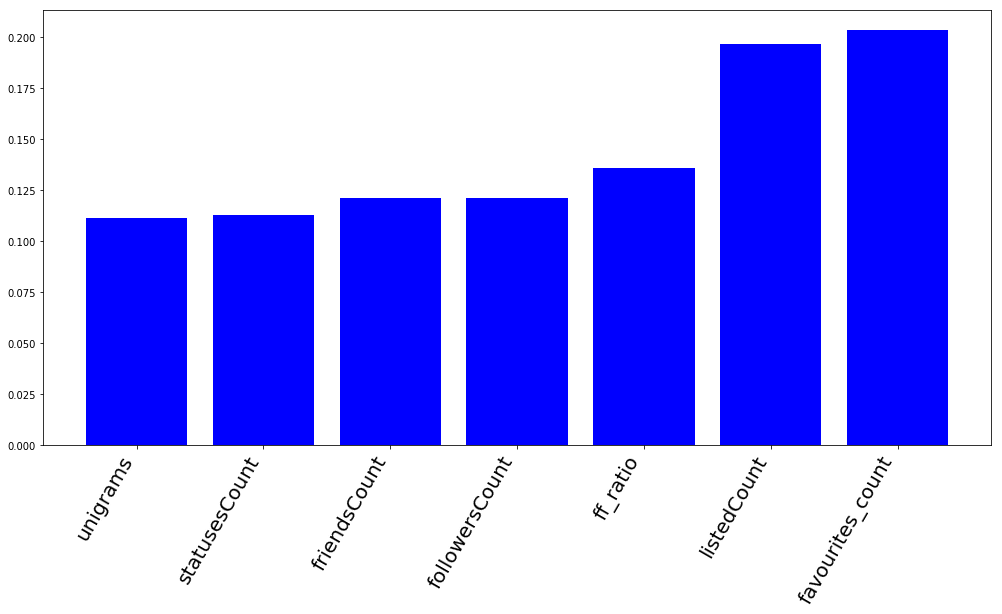

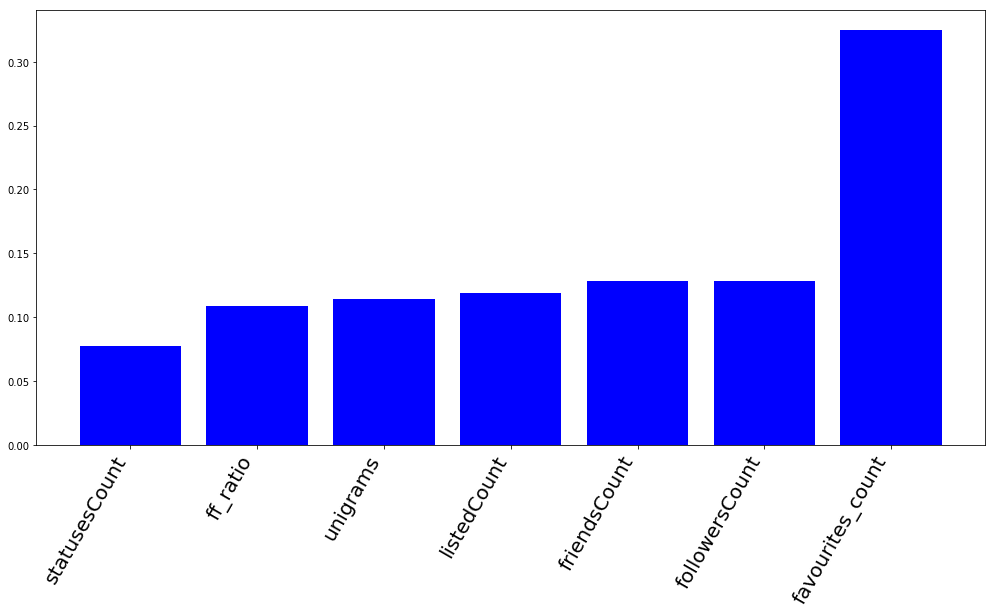

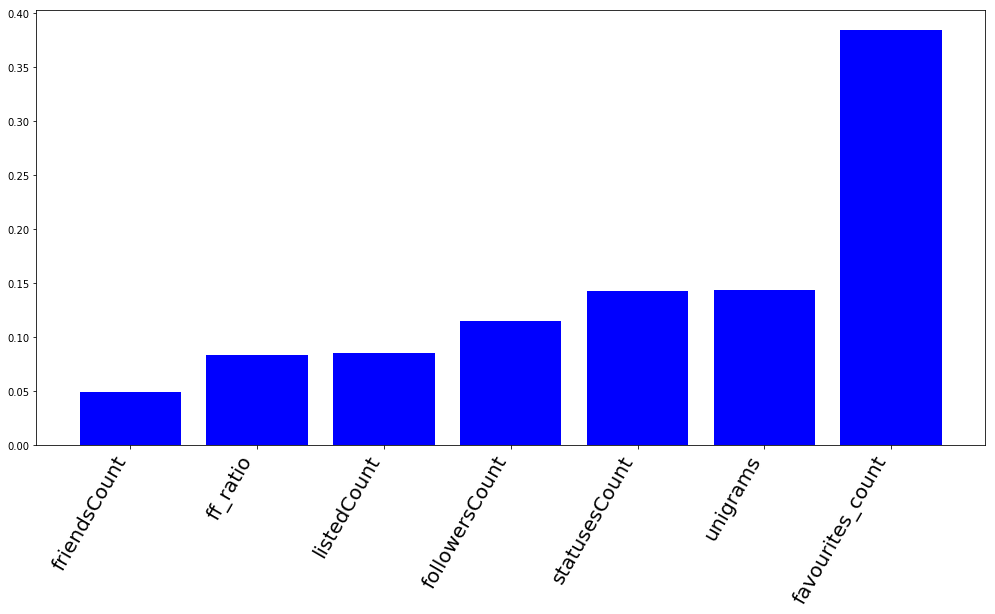

In [51]:
for model in (final_models):
    xgb_ = model["xgb"]
    plot_model_coeff(xgb_,7,list(user_data.columns))

## using the ensemble way

In [109]:
# Algorithm
# Split the train set in k folds
# Fit a first stage model on k-1 folds and predict the kth fold
# Repeat 2) to predict each fold

## preparing the data, taking 6 classfiers without lstm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas()
dimension = 100
epoch = 5
k_splits = 5
data_list = []
kFold = StratifiedKFold(n_splits=k_splits)
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
tf_idf = TfidfVectorizer(sublinear_tf=True)
df_pred_final = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## using k-fold so combine the data
    total_data = train_data.append(test_data)
    total_data = total_data.reset_index(drop=True)
    Y = np.array(list(Y_train) + list(Y_test))
    
    _,final_data = preprocessing.prepare_user_features(total_data)
    
    final_data["Text"] = total_data["tweetText"]
    Y_final = Y
    
    df_pred_temp = pd.DataFrame()
    for split,(train_ind,test_ind) in enumerate(kFold.split(final_data.index,Y_final)):
        print("at split",split)
        Y_test =  Y_final[test_ind]
        Y_train = Y_final[train_ind]
        
        test_data = final_data.iloc[test_ind]
        train_data = final_data.iloc[train_ind]
        
        text_columns = ["Text"]
        
        ## preapre text features , both using same oversamplign strategy
        X_train_text,tf_idf, svd = encode_text_svd(train_data["Text"])
        X_test_text = get_encoded_text_svd(test_data["Text"], tf_idf, svd)
        X_train_text, _ = util.get_oversample(X_train_text,Y_train)  ## oversample
        
        X_train_user = train_data.drop(text_columns,axis=1).values
        X_test_user = test_data.drop(text_columns,axis=1).values
        X_train_user, Y_train = util.get_oversample(X_train_user,Y_train)   ## oversample
        
        models = get_baseline_models()
        df_pred = {}
        for name,model in models.items(): 
            model.fit(X_train_user,Y_train)
            pred1 = model.predict(X_test_user)
            df_pred[(name+"_user")]  = list(pred1) 
            print(name,"user Classification report \n",classification_report(pred1,Y_test))
            
            model.fit(X_train_text,Y_train)
            pred2  = model.predict(X_test_text)
            df_pred[name+"_text"] = list(pred2) 
            print(name,"text Classification report\n",classification_report(pred2,Y_test))
       
        df_pred["Y"] = list(Y_test)
        temp = pd.DataFrame.from_dict(df_pred,orient="columns")
        df_pred_temp = df_pred_temp.append(temp)
    df_pred_final.append(df_pred_temp)

100%|██████████| 1140/1140 [00:00<00:00, 1433.95it/s]


train-test split
at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.95      0.77       141
          1       0.65      0.15      0.24        88

avg / total       0.64      0.64      0.56       229

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.80      0.92      0.86       182
          1       0.30      0.13      0.18        47

avg / total       0.70      0.76      0.72       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.93      0.74       137
          1       0.55      0.12      0.20        92

avg / total       0.59      0.61      0.52       229

rf text Classification report
              precision    recall  f1-score   support

          0       0.72      0.92      0.81       163
          1       0.35      0.11      0.16        66

avg / total     

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.94      0.92      0.93       213
          1       0.15      0.19      0.17        16

avg / total       0.88      0.87      0.88       229

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.94      0.72       130
          1       0.60      0.12      0.20        99

avg / total       0.59      0.59      0.50       229

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.72      0.94      0.81       160
          1       0.50      0.14      0.22        69

avg / total       0.65      0.70      0.64       229

rf user Classification report 
              precision    recall  f1-score   support

          0       0.57      0.94      0.71       128
          1       0.60      0.12      0.20       101

avg / total       0.59      0.58

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.93      0.92      0.93       211
          1       0.20      0.22      0.21        18

avg / total       0.88      0.87      0.87       229

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.93      0.73       135
          1       0.53      0.11      0.18        93

avg / total       0.57      0.60      0.51       228

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.81      0.90      0.85       187
          1       0.05      0.02      0.03        41

avg / total       0.67      0.75      0.71       228

rf user Classification report 
              precision    recall  f1-score   support

          0       0.67      0.96      0.79       146
          1       0.68      0.16      0.26        82

avg / total       0.68      0.67

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.95      0.91      0.93       217
          1       0.00      0.00      0.00        11

avg / total       0.90      0.87      0.88       228

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.95      0.77       142
          1       0.63      0.14      0.23        85

avg / total       0.64      0.65      0.57       227

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.79      0.93      0.85       178
          1       0.32      0.12      0.18        49

avg / total       0.69      0.75      0.71       227

rf user Classification report 
              precision    recall  f1-score   support

          0       0.65      0.96      0.78       142
          1       0.68      0.15      0.25        85

avg / total       0.67      0.66

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.88      0.92      0.90       200
          1       0.16      0.11      0.13        27

avg / total       0.80      0.82      0.81       227

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.53      0.97      0.69       115
          1       0.79      0.13      0.23       112

avg / total       0.66      0.56      0.46       227

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.81      0.92      0.86       184
          1       0.21      0.09      0.13        43

avg / total       0.70      0.76      0.72       227

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.97      0.74       128
          1       0.79      0.15      0.25        99

avg / total       0.68      0.61

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.91      0.92      0.92       207
          1       0.11      0.10      0.10        20

avg / total       0.84      0.85      0.84       227



100%|██████████| 2861/2861 [00:01<00:00, 1870.17it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.97      0.70       287
          1       0.86      0.19      0.31       286

avg / total       0.70      0.58      0.50       573

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.69      0.91      0.78       387
          1       0.44      0.15      0.22       186

avg / total       0.61      0.66      0.60       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.60      0.95      0.74       324
          1       0.75      0.19      0.30       249

avg / total       0.67      0.62      0.55       573

rf text Classification report
              precision    recall  f1-score   support

          0       0.65      0.93      0.77       360
          1       0.59      0.17      0.27       213

avg / total       0.63      0.65 

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.66      0.95      0.78       358
          1       0.70      0.20      0.32       215

avg / total       0.68      0.67      0.61       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.83      0.89      0.86       472
          1       0.21      0.13      0.16       101

avg / total       0.72      0.76      0.74       573

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.95      0.72       309
          1       0.78      0.19      0.30       264

avg / total       0.67      0.60      0.53       573

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.69      0.90      0.78       390
          1       0.40      0.14      0.20       183

avg / total       0.60      0.66      0.60       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.95      0.69       293
          1       0.76      0.17      0.28       280

avg / total       0.65      0.57

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.93      0.79       377
          1       0.59      0.19      0.29       196

avg / total       0.65      0.68      0.62       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.82      0.91      0.86       463
          1       0.32      0.18      0.23       110

avg / total       0.73      0.77      0.74       573

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.57      0.97      0.72       298
          1       0.87      0.20      0.33       275

avg / total       0.71      0.60      0.53       573

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.65      0.92      0.76       365
          1       0.51      0.15      0.24       208

avg / total       0.60      0.64      0.57       573

rf user Classification report 
              precision    recall  f1-score   support

          0       0.54      0.96      0.69       286
          1       0.83      0.18      0.30       287

avg / total       0.68      0.57

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.94      0.80       373
          1       0.67      0.21      0.32       200

avg / total       0.68      0.69      0.63       573



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.80      0.90      0.85       454
          1       0.29      0.15      0.20       119

avg / total       0.69      0.75      0.71       573

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.95      0.70       294
          1       0.77      0.17      0.28       277

avg / total       0.66      0.57      0.50       571

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.71      0.92      0.80       392
          1       0.47      0.16      0.24       179

avg / total       0.63      0.68      0.62       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.56      0.94      0.70       302
          1       0.69      0.16      0.26       269

avg / total       0.62      0.57

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.69      0.94      0.80       374
          1       0.65      0.20      0.31       197

avg / total       0.68      0.69      0.63       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.84      0.90      0.87       477
          1       0.24      0.16      0.19        94

avg / total       0.75      0.78      0.76       571

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.51      0.96      0.66       270
          1       0.81      0.17      0.28       301

avg / total       0.66      0.54      0.46       571

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.61      0.92      0.73       340
          1       0.55      0.15      0.23       231

avg / total       0.59      0.61      0.53       571

rf user Classification report 
              precision    recall  f1-score   support

          0       0.52      0.96      0.67       277
          1       0.81      0.17      0.28       294

avg / total       0.67      0.55

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.64      0.94      0.76       348
          1       0.66      0.18      0.29       223

avg / total       0.65      0.64      0.58       571



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.80      0.90      0.85       451
          1       0.29      0.15      0.20       120

avg / total       0.69      0.74      0.71       571



100%|██████████| 41902/41902 [00:15<00:00, 2720.44it/s]


train-test split


/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]
/home/xavlock2345/twitter_juul/src/preprocess/escalation/preprocessing.py:54: RuntimeWarning: divide by zero encountered in log
  "listedCount"]])
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/xavlock2345/twitter_juul

at split 0
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.87      0.72      4577
          1       0.68      0.34      0.45      3804

avg / total       0.64      0.63      0.60      8381

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.65      0.82      0.73      5137
          1       0.53      0.31      0.39      3244

avg / total       0.60      0.62      0.60      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4100
          1       0.71      0.31      0.44      4281

avg / total       0.63      0.58      0.55      8381

rf text Classification report
              precision    recall  f1-score   support

          0       0.61      0.82      0.70      4812
          1       0.54      0.29      0.37      3569

avg / total       0.58      0.59 

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.87      0.73      4615
          1       0.69      0.35      0.46      3766

avg / total       0.65      0.64      0.61      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.63      0.83      0.71      4906
          1       0.56      0.30      0.39      3475

avg / total       0.60      0.61      0.58      8381

at split 1
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.71      4624
          1       0.66      0.33      0.44      3757

avg / total       0.63      0.62      0.59      8381

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.65      0.82      0.72      5171
          1       0.50      0.30      0.37      3210

avg / total       0.59      0.62      0.59      8381

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4150
          1       0.68      0.31      0.42      4231

avg / total       0.62      0.58

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4712
          1       0.65      0.34      0.44      3669

avg / total       0.64      0.63      0.60      8381



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.62      0.82      0.71      4898
          1       0.54      0.30      0.38      3483

avg / total       0.59      0.60      0.57      8381

at split 2
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4664
          1       0.65      0.33      0.44      3716

avg / total       0.63      0.63      0.60      8380

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.66      0.82      0.73      5200
          1       0.51      0.31      0.38      3180

avg / total       0.60      0.63      0.60      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.58      0.86      0.69      4356
          1       0.67      0.32      0.43      4024

avg / total       0.62      0.60

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.63      0.86      0.73      4783
          1       0.64      0.34      0.44      3597

avg / total       0.63      0.63      0.60      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.64      0.83      0.72      5039
          1       0.54      0.31      0.39      3341

avg / total       0.60      0.62      0.59      8380

at split 3
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.72      4608
          1       0.66      0.33      0.44      3772

avg / total       0.64      0.62      0.59      8380

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.65      0.82      0.72      5111
          1       0.52      0.30      0.38      3269

avg / total       0.60      0.62      0.59      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.55      0.86      0.67      4113
          1       0.70      0.31      0.43      4267

avg / total       0.62      0.58

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.86      0.72      4660
          1       0.66      0.34      0.45      3720

avg / total       0.64      0.63      0.60      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb text Classification report
              precision    recall  f1-score   support

          0       0.63      0.83      0.72      4980
          1       0.54      0.30      0.39      3400

avg / total       0.60      0.61      0.58      8380

at split 4
[LibLinear]svm user Classification report 
              precision    recall  f1-score   support

          0       0.61      0.86      0.71      4611
          1       0.65      0.33      0.43      3769

avg / total       0.63      0.62      0.59      8380

[LibLinear]svm text Classification report
              precision    recall  f1-score   support

          0       0.66      0.82      0.73      5256
          1       0.49      0.30      0.37      3124

avg / total       0.60      0.62      0.60      8380

rf user Classification report 
              precision    recall  f1-score   support

          0       0.52      0.87      0.65      3908
          1       0.73      0.31      0.43      4472

avg / total       0.63      0.57

/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb user Classification report 
              precision    recall  f1-score   support

          0       0.62      0.87      0.72      4647
          1       0.67      0.34      0.45      3733

avg / total       0.64      0.63      0.60      8380

xgb text Classification report
              precision    recall  f1-score   support

          0       0.65      0.82      0.72      5109
          1       0.52      0.30      0.38      3271

avg / total       0.60      0.62      0.59      8380



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [118]:
## get distribution of positives in test data..
# dump_scores
import pickle
with open(os.path.join(model_dir,"ensemble_stage1_pred.pkl"),"wb") as f:
    pickle.dump(df_pred_final,f)

In [138]:
util.get_postives(df_pred_final[0]["Y"])

97

In [205]:
## using xg boost for 2nd level

# We now have the (out-of-folds) prediction of the k folds
# Split these out-of folds predictions in p folds
# Fit a second stage (stacker) model on p-1 folds and predict the pth fold
# Repeat 6) to predict each fold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
p_splits = 5
# model = XGBClassifier()
model = LinearSVC(C=1, verbose=1)
# model = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
ensemble_scores = []
models = []
kFold = StratifiedKFold(n_splits=p_splits)
for data in df_pred_final:
    Y = np.array(list(data["Y"]))
    X = data.loc[:,data.columns != "Y"].values
    
    fold_scores = []
    for split,(train_ind,test_ind) in enumerate(kFold.split(X,Y)): 
        print("at split",split)
        Y_test =  Y[test_ind]
        Y_train = Y[train_ind]
        
        X_test = X[test_ind]
        X_train = X[train_ind]
        
        ## oversample
        X_train, Y_train = util.get_undersample(X_train,Y_train)
        model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        print("classsfication report \n",classification_report(y_pred,Y_test))
        fold_scores.append(precision_recall_fscore_support(y_pred,Y_test,average=None)[2])
    
    score1 = np.mean([ele[0] for ele in fold_scores])
    score2 = np.mean([ele[1] for ele in fold_scores])
    score = np.array([score1,score2])
    ensemble_scores.append(score)
    models.append(model)

at split 0
[LibLinear]classsfication report 
              precision    recall  f1-score   support

          0       0.57      0.94      0.71       128
          1       0.60      0.12      0.20       101

avg / total       0.59      0.58      0.49       229

at split 1
[LibLinear]classsfication report 
              precision    recall  f1-score   support

          0       0.57      0.93      0.71       128
          1       0.55      0.11      0.18       101

avg / total       0.56      0.57      0.47       229

at split 2
[LibLinear]classsfication report 
              precision    recall  f1-score   support

          0       0.63      0.94      0.76       140
          1       0.58      0.12      0.21        88

avg / total       0.61      0.63      0.54       228

at split 3
[LibLinear]classsfication report 
              precision    recall  f1-score   support

          0       0.65      0.96      0.78       142
          1       0.68      0.15      0.25        85

avg / tota

In [116]:
## get distribution of positives in test data..
# dump_scores
import pickle
with open(os.path.join(model_dir,"ensemble_oversample_xgb.pkl"),"wb") as f:
    pickle.dump(ensemble_scores,f)

## plotting scores

In [148]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [149]:
Y_tests = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    Y_tests.append(Y_test)

100%|██████████| 1140/1140 [00:00<00:00, 2327.77it/s]


train-test split


100%|██████████| 2861/2861 [00:01<00:00, 1964.92it/s]


train-test split


100%|██████████| 41902/41902 [00:16<00:00, 2561.65it/s]


train-test split


In [150]:
from sklearn.metrics import precision_recall_fscore_support
maj_mono = []
maj_poly = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos)[2][1]
    maj_poly.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg)[2][0]
    maj_mono.append(maj_neg)

length of Y_test 228
positives in Y_test 19
length of Y_test 573
positives in Y_test 63
length of Y_test 8381
positives in Y_test 1900


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### svm

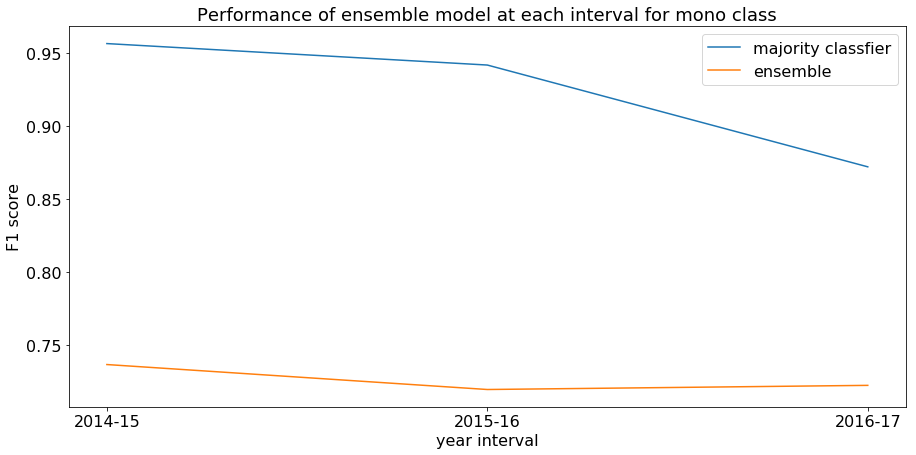

In [207]:
ensemble = [ele[0] for ele in ensemble_scores]
all_mono = [ele for ele in maj_mono]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
# plt.plot(years,maj_score_pos,label="majority classfier")
plt.plot(years,all_mono,label="majority classfier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval for mono class",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("year interval",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

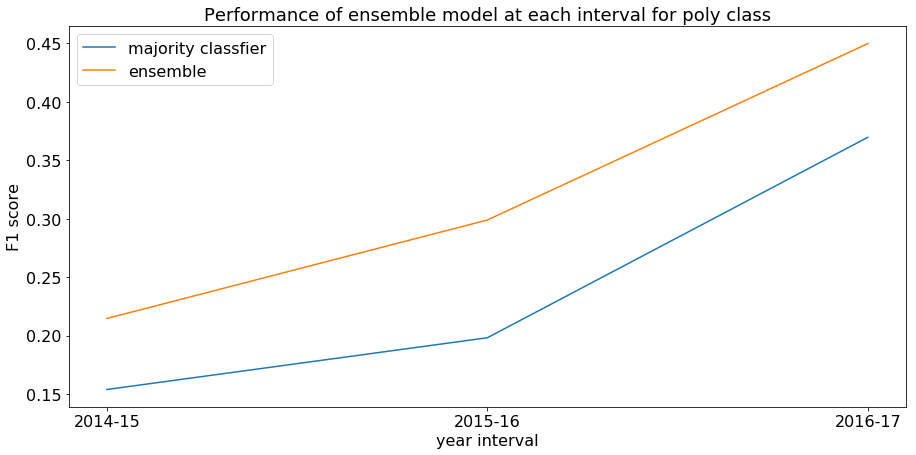

In [208]:
ensemble = [ele[1] for ele in ensemble_scores]
all_poly = [ele for ele in maj_poly]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,all_poly,label="majority classfier")
# plt.plot(years,maj_score_neg,label="majority classfier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval for poly class",fontsize=18)
plt.xlabel("year interval",fontsize=16)
plt.ylabel("F1 score",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [197]:
## plot the coefficients for svm
def plot_coeff_svm(model,k, feature_names):
    coef = (model.coef_.ravel())
    top_coefficients = np.argsort(coef)[-k:]
    plt.figure(figsize=(17, 8))
    plt.bar(np.arange(k), coef[top_coefficients], color="blue")
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(k), feature_names[top_coefficients], rotation=60, ha='right', fontsize=20)
    plt.show()

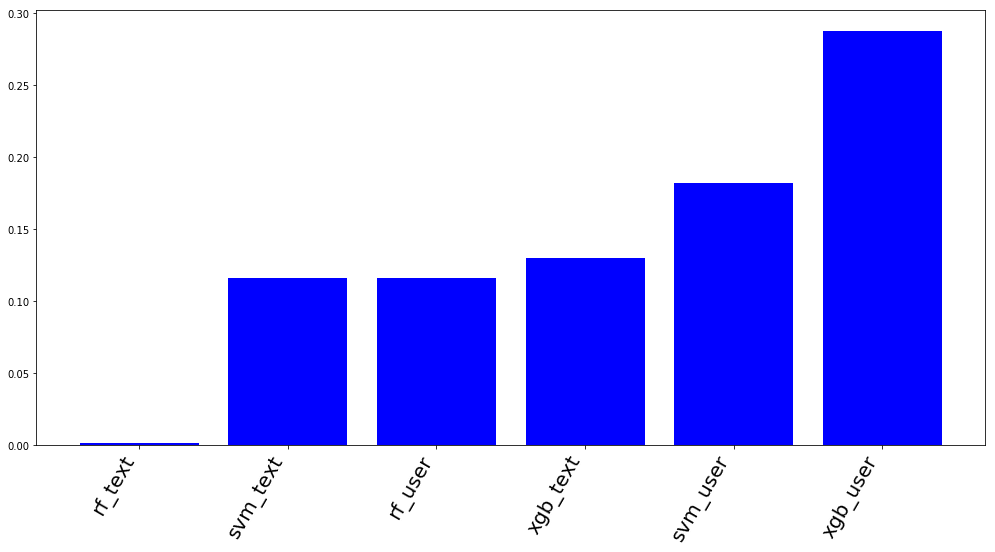

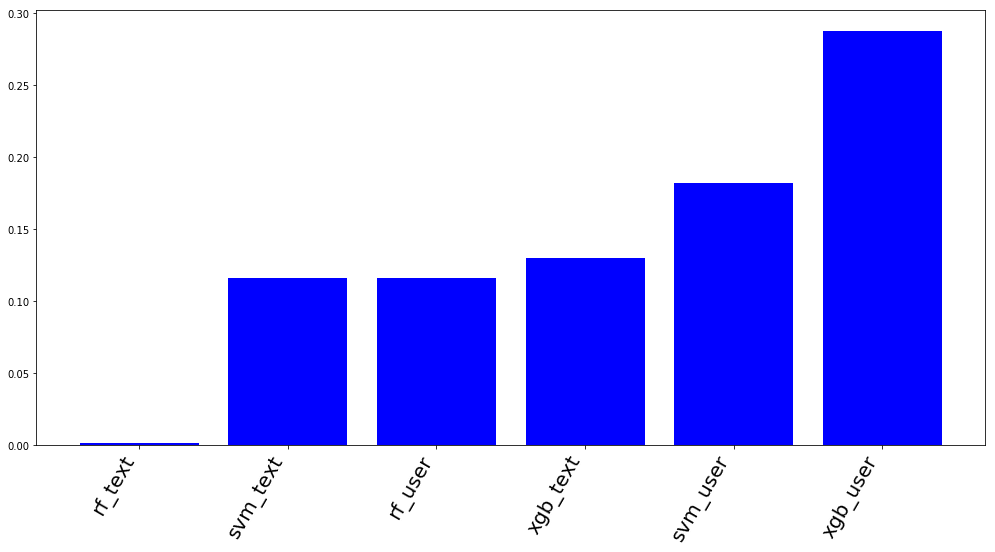

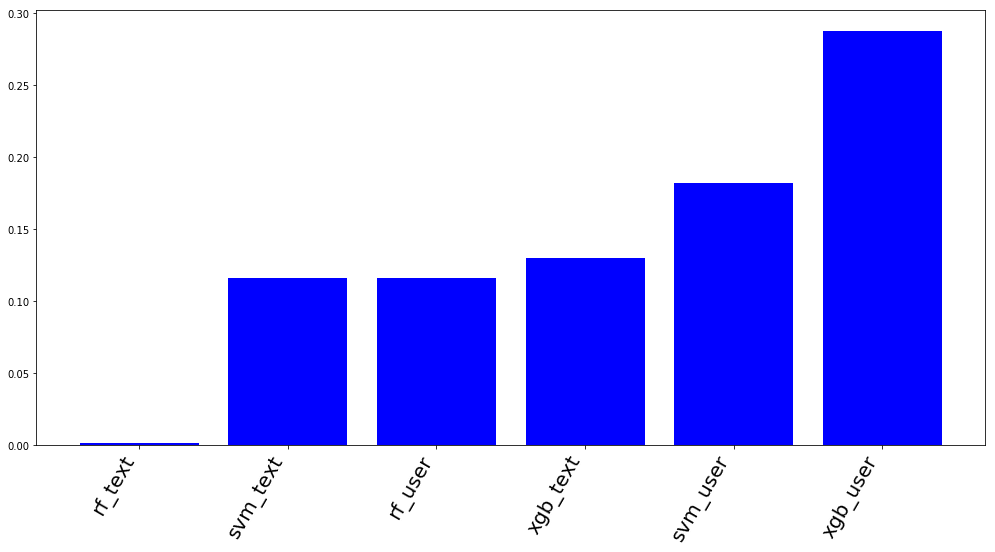

In [202]:
columns = list(df_pred_final[0].loc[:,data.columns != "Y"].columns)
for model in models:
    plot_coeff_svm(6,model,columns)

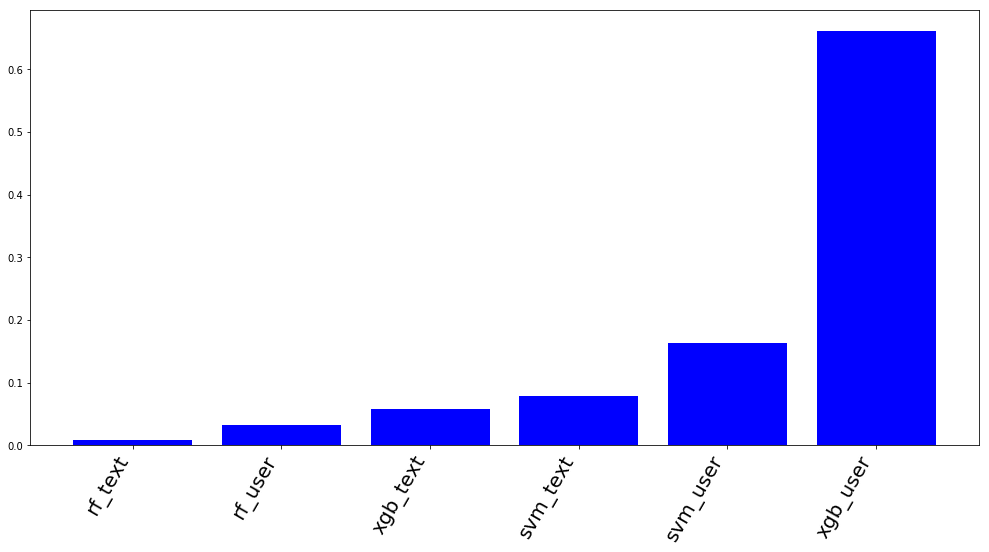

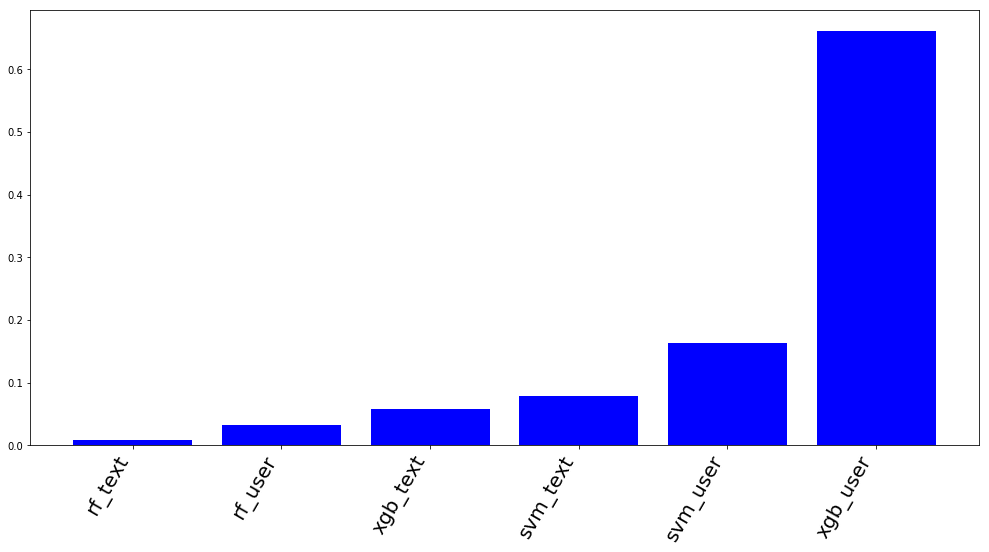

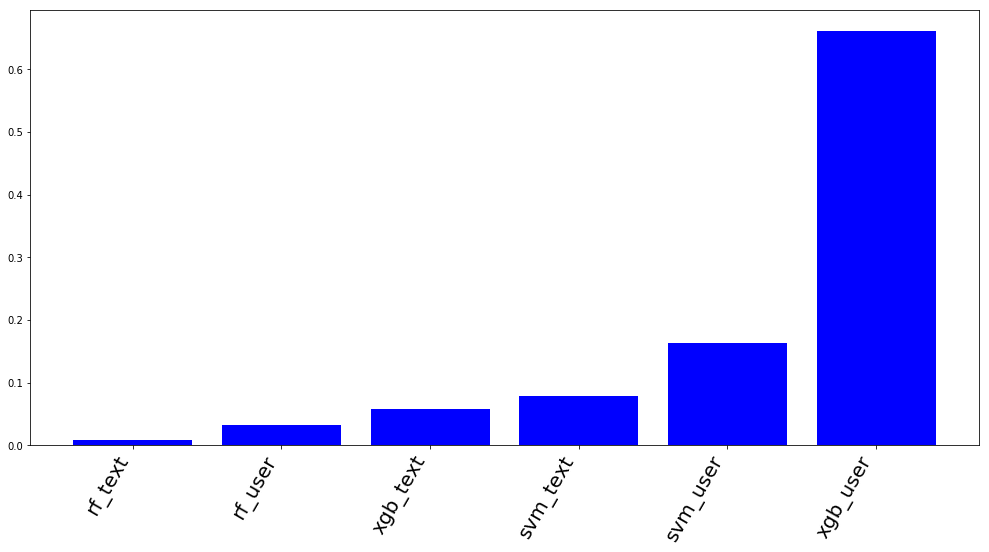

In [188]:
columns = list(df_pred_final[0].loc[:,data.columns != "Y"].columns)
for model in models:
    plot_model_coeff(model,6,columns)

In [189]:
## xgboost
print(np.mean([score[1] for score in ensemble_scores]))
ensemble_scores

0.3100967228040637


[array([0.73254069, 0.18779763]),
 array([0.72259549, 0.29198322]),
 array([0.72127178, 0.45050931])]

In [211]:
## svm
print(np.mean([score[1] for score in ensemble_scores]))
ensemble_scores

0.32109197390655075


[array([0.73682607, 0.21461218]),
 array([0.71973921, 0.29885395]),
 array([0.72257247, 0.44980979])]

In [172]:
## random forest
print(np.mean([score[1] for score in ensemble_scores]))
ensemble_scores

0.3213220349979479


[array([0.7289572 , 0.20848671]),
 array([0.71879912, 0.30425269]),
 array([0.72102573, 0.45122671])]

In [83]:
## get distribution of positives in test data..
# dump_scores
import pickle
# with open(os.path.join(model_dir,"ensemble_scores_maj.pkl"),"wb") as f:
#     pickle.dump(ensemble_scores,f)
    
with open(os.path.join(model_dir,"ensemble_scores_lstm.pkl"),"wb") as f:
    pickle.dump(ensemble_scores,f)
    
print("bufeer will not print")

bufeer will not print


## comparision plot of all models

## logistic regression

In [153]:
from sklearn.model_selection import KFold
def get_cross_val(model, X, Y, n_splits):
    kFold = KFold(n_splits=n_splits)
    scores = []
    for train_index, test_index in kFold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        scores.append(precision_recall_fscore_support(Y_test, y_pred, average=None)[2])
    score1 = np.mean([ele[0] for ele in scores])  ## average of 5 folds
    score2 = np.mean([ele[1] for ele in scores])  ## average of 5 folds
    return np.array([score1, score2])

In [48]:
ensemble_scores = pickle.load(open(os.path.join(model_dir,"ensemble_scores_over.pkl"),"rb"))

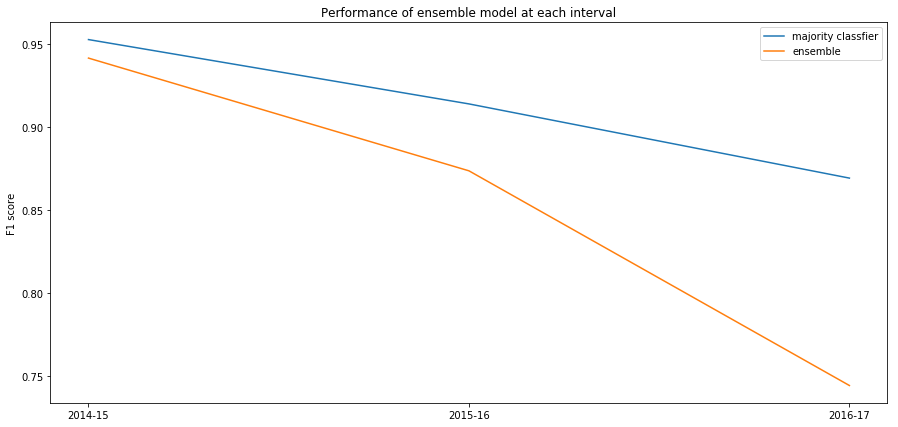

In [31]:
ensemble = [ele[0] for ele in ensemble_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
# plt.plot(years,maj_score_pos,label="majority classfier")
plt.plot(years,maj_score_neg,label="majority classfier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval")
plt.ylabel("F1 score")
plt.legend()
plt.show()

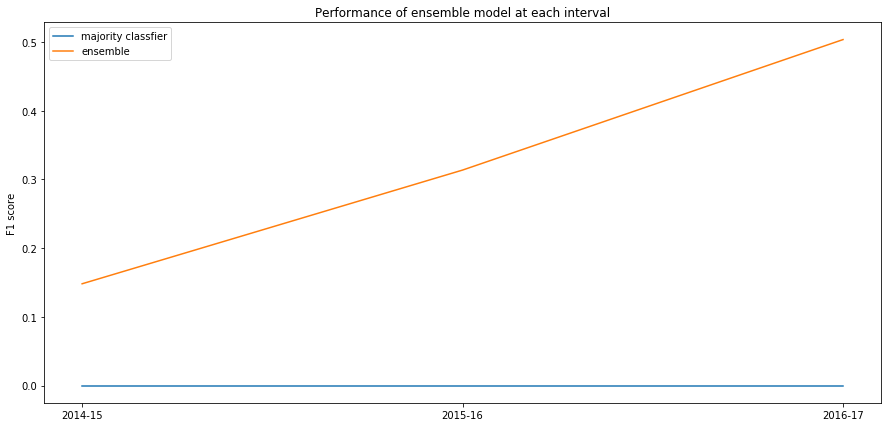

In [32]:
ensemble = [ele[1] for ele in ensemble_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority classfier")
# plt.plot(years,maj_score_neg,label="majority classfier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval")
plt.ylabel("F1 score")
plt.legend()
plt.show()

## majority voting

In [74]:
ensemble_scores = pickle.load(open(os.path.join(model_dir,"ensemble_scores_maj.pkl"),"rb"))

In [75]:
ensemble_scores

[array([0.93814433, 0.25      ]),
 array([0.8540146 , 0.25925926]),
 array([0.82874491, 0.49447582])]

In [ ]:
for scores 

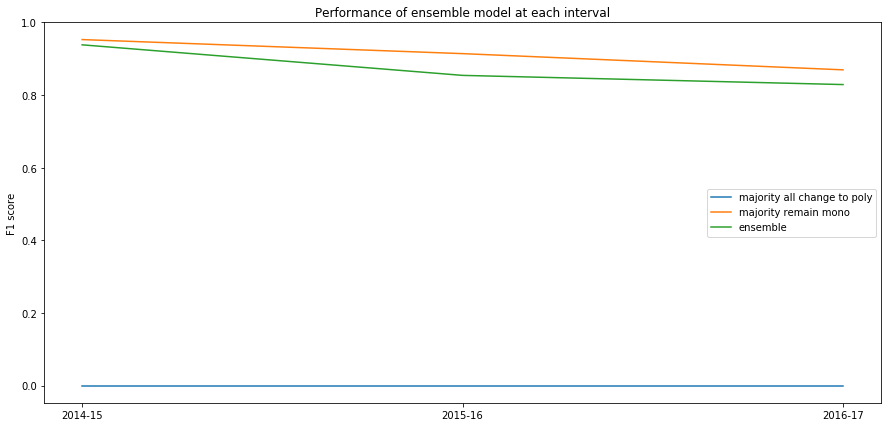

In [65]:
## majority voting
ensemble = [ele[0] for ele in ensemble_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17",]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval")
plt.ylabel("F1 score")
plt.legend()
plt.show()

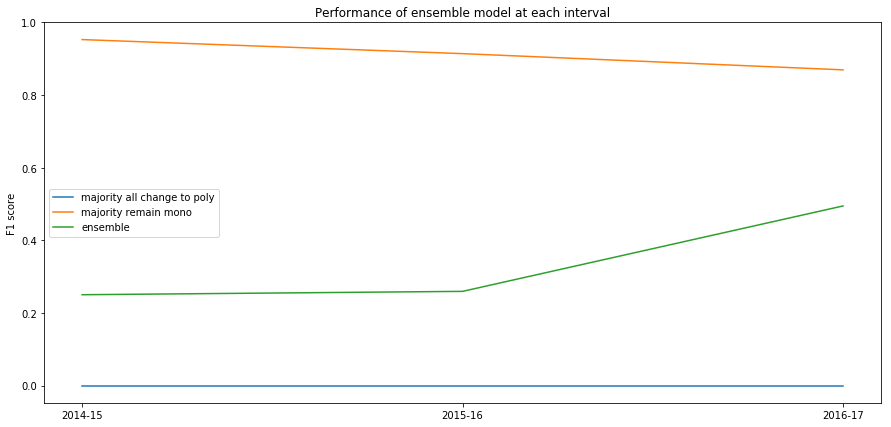

In [66]:
ensemble = [ele[1] for ele in ensemble_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,maj_score_pos,label="majority all change to poly")
plt.plot(years,maj_score_neg,label="majority remain mono")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of ensemble model at each interval")
plt.ylabel("F1 score")
plt.legend()
plt.show()

[0.53485125 0.04940957 0.08564474 0.06018534 0.08759014 0.07345726
 0.06082027 0.04804144]


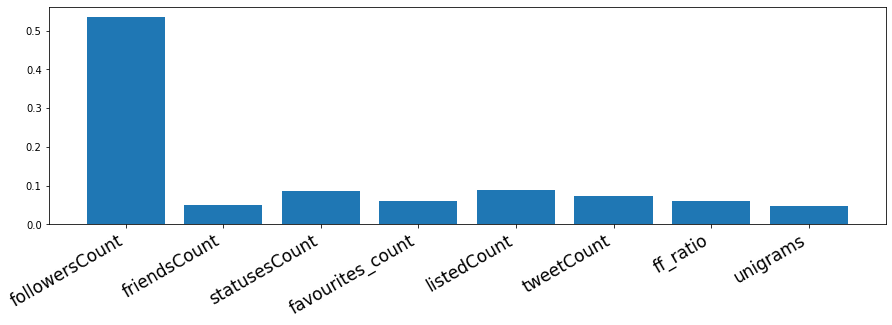

In [523]:
## feature importance for each of the feature
import matplotlib.pyplot as plt
plt.title("feature importance of each of the user features")
print(xgb.feature_importances_)
# plot
plt.figure(figsize=(15,4))
plt.bar(df_test.columns, xgb.feature_importances_)
plt.xticks(rotation='30',ha='right',fontsize=17)
plt.show()

## Sequential prediction using LSTM and baseline classfier for 2018 data

## Month level

In [16]:
## sequence of tweets for user
## output prediction would be for the users so teh lstm layer would need to flatten to a single user..

## poly_turned : if users tweets weed after september (>=9 months) 
## remain_mono :
## seeing the data in different buckets:
#   1  [jan - mar )
#   2  [mar- may )
#   3  [May - july]
#   4  [July - sept]

## use lstm
## use svm
## majority
## xg boost

In [28]:
import util
import driver
import preprocessing
import lstm as lstm_module
import baselines
import pickle
import matplotlib.pyplot as plt

In [29]:
## so we are taking the users that start on Jan 2018 and change in the month of september, 
# and we change the threshold of input data to see how accurately we can predict that

In [259]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [433]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [434]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [435]:
pd.isnull(list(first_data.loc[first_data.userID == 2534]["weed_first"])[0])

True

In [436]:
## get the users who start at jan 2018 
users_2018 = list(first_data["userID"][ 
    (first_data.juul_first.dt.year == 2018)
    & ((first_data.weed_first.dt.year == 2018) | (pd.isnull(first_data.weed_first)))
    & (first_data.juul_first.dt.month== 1)   ## selecting 2018, Jan data
    & (((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date)) | (pd.isnull(first_data.weed_first)))
    & ((first_data.weed_first.dt.month >= 9) | (pd.isnull(first_data.weed_first)))]) # users who will change after september

poly_lbl = list(first_data["userID"].loc[(first_data.juul_first.dt.year == 2018)  
                                        & (first_data.juul_first.dt.month== 1) 
                                        & ((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date))
                                        & ((first_data.weed_first.dt.month >= 9))
                                        & ((first_data.weed_first.dt.year == 2018))
                                        ])
                                            ## users that will change
print("total users", len(users_2018))
print("users will change",len(poly_lbl))


total users 10760
users will change 929


In [437]:
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018) & (juul_data.tweetCreatedAt.dt.year == 2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

## sanity check -- all users start in 2018 year..
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

total data 24018
users 10760
total data 24018
users 10760


In [438]:
## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_2018.userID.unique()
users_labelled = pd.DataFrame(users_,columns=["userID"])
users_labelled["label"] = 0  ## initialize
users_labelled.loc[users_labelled.userID.isin(poly_lbl) , "label"] = 1
len(users_labelled.loc[users_labelled.label == 1])  ## sanity check

929

In [439]:
bucket_data = []

In [440]:
bucket_data.append(preprocessing.get_month_data(data_2018,1,2))
bucket_data.append(preprocessing.get_month_data(data_2018,1,4))
bucket_data.append(preprocessing.get_month_data(data_2018,1,6))
bucket_data.append(preprocessing.get_month_data(data_2018,1,8))

length of the data 13087
total users 10760
length of the data 15477
total users 10760
length of the data 18204
total users 10760
length of the data 20383
total users 10760


## user are not changing in the month interval so need to get the text features scores..

## text features

In [441]:
# oversampling
dimension = 100
epoch = 20
svm_scores = []
rf_scores = []
xgb_scores = []
lstm_scores = []
Y_tests = []
for data in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    
    ## lstm model
    lstm_score, lstm_pred, lstm_model, keras_tkzr, max_len= driver.run_lstm(
                                        train_data["tweetText"],test_data["tweetText"],Y_train, Y_test,
                                        dimension,epoch,cross_splits=5,option="over",cross_val=True)
    
    baseline models
    baseline_models, tfidf, svd =  driver.run_text_features(train_data["tweetText"], 
                                            test_data["tweetText"], Y_train, Y_test,
                                                            option="over",svd=True,cross_val=True)
    
    svm_scores.append(baseline_models['svm'][1])
    rf_scores.append(baseline_models['rf'][1])
    xgb_scores.append(baseline_models['xgb'][1])
    lstm_scores.append(lstm_score)

    Y_tests.append(Y_test)


100%|██████████| 10760/10760 [00:02<00:00, 3673.61it/s]

train-test split



100%|██████████| 10760/10760 [00:03<00:00, 3327.06it/s]

train-test split



100%|██████████| 10760/10760 [00:03<00:00, 2892.47it/s]

train-test split



100%|██████████| 10760/10760 [00:04<00:00, 2607.32it/s]

train-test split


In [ ]:
# dump_scores
scores_over = {"svm_scores" : svm_scores,
               "rf_scores" : rf_scores,
               "lstm" : lstm_scores,
               "xgb" : xgb_scores}

with open(os.path.join(model_dir,"text_over_month_scores.pkl"),"wb") as f:
    pickle.dump(scores_over,f)

## plotting

In [444]:
scores = pickle.load(open(os.path.join(model_dir,"text_over_month_scores.pkl"),"rb"))

In [445]:
scores["lstm"]

[(0.8353255669336013, 0.7257933157285448),
 (0.8605957500202066, 0.7894061533207751),
 (0.8832808252925256, 0.8278279740054486),
 (0.8937535734314093, 0.8469521195514453)]

In [424]:
for score in scores["lstm"]:
    print(np.mean(score))

0.780559441331073
0.8250009516704908
0.8555543996489872
0.8703528464914273


In [446]:
#### @TODO look at the plots
scores_under = pickle.load(open(os.path.join(model_dir,"text_over_month_scores.pkl"),"rb"))
svm_scores =  scores_under["svm_scores"]
rf_scores = scores_under["rf_scores"]
xgb_scores = scores_under["xgb"]
lstm_scores = scores_under["lstm"]

In [442]:
from sklearn.metrics import precision_recall_fscore_support
maj_scores_neg = []
maj_scores_pos = []
for Y_test in Y_tests:
    y_pred_neg = [0 for x in range(len(Y_test))]
    y_pred_pos = [1 for x in range(len(Y_test))]
    print("length of Y_test",len(Y_test))
    print("positives in Y_test", (util.get_postives(Y_test)))
    maj_pos = precision_recall_fscore_support(Y_test,y_pred_pos,average=None)[2][0]
    maj_scores_pos.append(maj_pos)
    maj_neg = precision_recall_fscore_support(Y_test,y_pred_neg,average=None)[2][0]
    maj_scores_neg.append(maj_neg) 

length of Y_test 2152
positives in Y_test 186
length of Y_test 2152
positives in Y_test 186
length of Y_test 2152
positives in Y_test 186
length of Y_test 2152
positives in Y_test 186


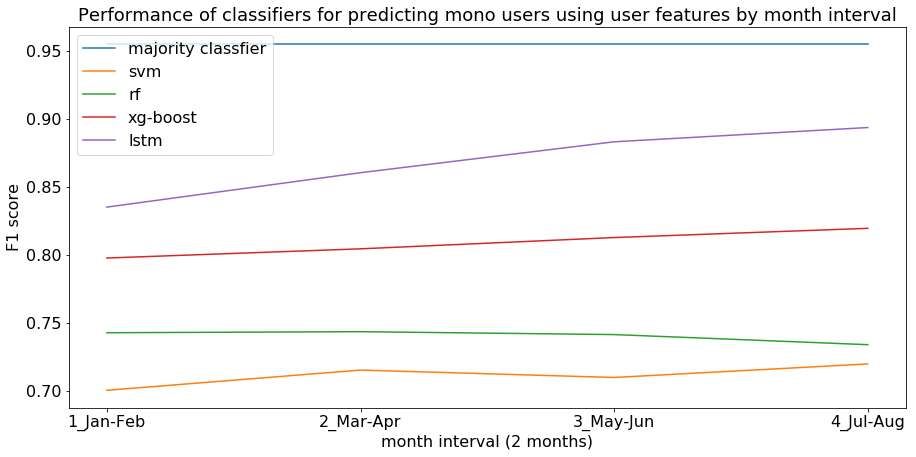

In [458]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
lstm = [ele[0] for ele in lstm_scores]
# maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
months = ["1_Jan-Feb","2_Mar-Apr","3_May-Jun","4_Jul-Aug"]
# plt.plot(months,maj_score_pos,label="majority all change to poly")
plt.plot(months,maj_score_neg,label="majority classfier")
plt.plot(months,svm,label="svm")
plt.plot(months,rf,label="rf")
plt.plot(months,xgb,label="xg-boost")
plt.plot(months,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using user features by month interval",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("month interval (2 months)",fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

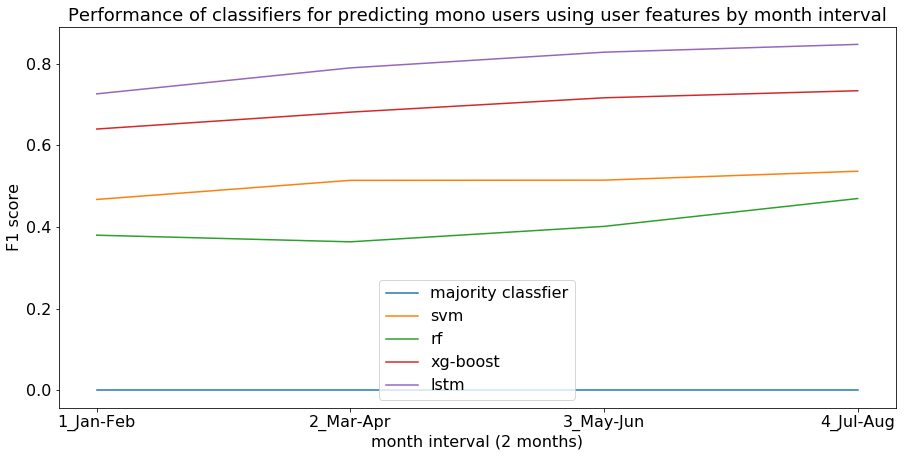

In [457]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
lstm = [ele[1] for ele in lstm_scores]
maj_score_pos = [ele for ele in maj_scores_pos]
maj_score_neg = [ele for ele in maj_scores_neg]
## plotting user features
plt.figure(figsize=(15,7))
months = ["1_Jan-Feb","2_Mar-Apr","3_May-Jun","4_Jul-Aug"]
plt.plot(months,maj_score_pos,label="majority classfier")
# plt.plot(months,maj_score_neg,label="majority classfier")
plt.plot(months,svm,label="svm")
plt.plot(months,rf,label="rf")
plt.plot(months,xgb,label="xg-boost")
plt.plot(months,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using user features by month interval",fontsize=18)
plt.ylabel("F1 score",fontsize=16)
plt.xlabel("month interval (2 months)",fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## old way-- not cross validated

In [164]:
dimension = 100
epoch = 20
data_list = []
for year,data,users_labelled in bucket_data:
    train_data,test_data,Y_train, Y_test = preprocessing.prepare_data(data,users_labelled)
    lstm_scores, lstm_pred, lstm_model, keras_tkzr, max_len= driver.run_lstm(
                                        train_data["tweetText"],test_data["tweetText"],
                                    Y_train, Y_test,dimension,epoch,cross_splits= 2,option="over",cross_val=False)
    all_models = driver.run_user_features(train_data, test_data, Y_train, Y_test)
    
    baseline_models, tfidf, svd =  driver.run_text_features(train_data["tweetText"], test_data["tweetText"], 
                                                            Y_train, Y_test)
    
    ## predicting using the ensemble method for all text and user
        data_pred = {
#                 'svm_user': all_models["svm"][0], 
#                  'rf_user': all_models["rf"][0], 
                 "xgb_user" : all_models["xgb"][0] ,  
#                  'lstm': lstm_pred,
#                 "svm_text":baseline_models["svm"][0], 
#                  "rf_text":baseline_models["rf"][0],
                "xgb":baseline_models["xgb"][0]}
    
    ## saving the model and configs
    all_models["lstm"] = [lstm_pred,lstm_scores,lstm_model,keras_tkzr,max_len]
    all_models["svm_text"] = baseline_models["svm"]
    all_models["rf_text"] = baseline_models["rf"]
    all_models["xgb_text"] = baseline_models["xgb"]
    all_models["tfidf"] = tfidf
    all_models["svd"] = svd
    
    df_data = pd.DataFrame(data= data_pred)
    data_list.append((test_data,Y_test,df_data,all_models))

100%|██████████| 1049/1049 [00:00<00:00, 2669.54it/s]


train-test split
text_data (1904, 100) Y 1904
user_data (1904, 8) Y 1904
at split


In [70]:
ensemble_scores = []
for val_data,test_data,Y_val,Y_test,data_pred,all_models in data_list:
    
#     switching with different models
    data_pred = {
#             'svm_user': data_pred["svm_user"], 
#              'rf_user': data_pred["rf_user"], 
         "xgb_user" : data_pred["xgb_user"] ,  
    #                  'lstm': lstm_pred,
        "svm_text":  data_pred["svm_text"], 
#              "rf_text":data_pred["rf_text"],
#             "xgb_text":data_pred["xgb_text"] 
                   }
    
    df_data = pd.DataFrame(data= data_pred)
    X = df_data.values   ## all model predictions
    y = Y_val
    print("ensemble y val",X.shape)
    print("ensemble y val",len(y))
    
    ## training with validation data
    lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X,y)
    print(lr.coef_)
    weights = lr.coef_[0]
    print(len(weights))
    #     best_idx = np.argmax(lr.coef_[0])
    ## will use the weighst to make prediction on test set

    ## unpacking all of the models
#     _,_,lstm_model,keras_tkzr,max_len = all_models["lstm"]
    _,_,svm_text = all_models["svm_text"]
    _,_,rf_text  = all_models["rf_text"] 
    _,_,xgb_text = all_models["xgb_text"] 
    _,_,svm_user = all_models["svm"]
    _,_,rf_user  = all_models["rf"]
    _,_,xgb_user = all_models["xgb"]
    tfidf = all_models["tfidf"]
    svd  = all_models["svd"] 

    ## getting predicting on test data
    ## text predictions
#     lstm_pred = lstm_module.cal_lstm_pred(test_data,lstm_model,keras_tkzr,max_len)
#     print("lstm prediction",len(lstm_pred))
    
    svm_text_pred = baselines.cal_text_pred(test_data,svm_text,tfidf,svd)
    rf_text_pred = baselines.cal_text_pred(test_data,rf_text,tfidf,svd)
    xgb_text_pred = baselines.cal_text_pred(test_data,xgb_text,tfidf,svd)
    
    ## user predictions
    svm_pred  = baselines.cal_user_pred(test_data, svm_user)
    rf_pred = baselines.cal_user_pred(test_data, rf_user)
    xgb_pred = baselines.cal_user_pred(test_data, xgb_user)
    
    
    ## predicting with test data
    ## predicting using the ensemble method
    data_pred = {
#                 "svm_user": svm_pred, 
#                  "rf_user": rf_pred, 
                 "xgb_user" : xgb_pred ,
#                  "lstm": lstm_pred , 
#                  "svm_text": svm_text_pred,
#                  "rf_text":rf_text_pred,
#                  "xgb_text":xgb_text_pred,               
                      }
    print("data pred length", len(data_pred))
    df_pred = pd.DataFrame(data= data_pred)
    print("pred shape",df_pred.shape)
    
    # weighted idea
    df_pred = df_pred.mul(list(weights))
    pred = list(df_pred.sum(axis=1))  # weighted ensemble
    final_pred = [1 if p >= 0.5 else 0 for p in pred ]  ## threshold as 0.5

    #      majority voting , simple..
#     df_pred["pred"] = df_pred.sum(axis=1)
#     pred = list(df_pred["pred"])
#     final_pred = [1 if p == 2 else 0 for p in pred] ## simple amjority 
    
#     df_data["pred"] = df_data.iloc[:,best_idx]  ## selecting based on max weight
#     print("best index = ",best_idx)
#     final_pred = list(df_data["pred"])
    
    
    print('  Classification Report ensemble:\n',classification_report(Y_test,xgb_pred),'\n')
    ensemble_score = precision_recall_fscore_support(Y_test,final_pred,average=None)[2]
    ensemble_scores.append(ensemble_score)

ensemble y val (210, 1)
ensemble y val 210
[[0.6653179]]
1


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


data pred length 1
pred shape (210, 1)
  Classification Report ensemble:
              precision    recall  f1-score   support

          0       0.94      0.83      0.88       191
          1       0.22      0.47      0.30        19

avg / total       0.88      0.80      0.83       210
 

ensemble y val (327, 1)
ensemble y val 327
[[0.64961953]]
1


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


data pred length 1
pred shape (328, 1)
  Classification Report ensemble:
              precision    recall  f1-score   support

          0       0.89      0.77      0.83       276
          1       0.30      0.52      0.38        52

avg / total       0.80      0.73      0.76       328
 

ensemble y val (8047, 1)
ensemble y val 8047
[[0.8672755]]
1


/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


data pred length 1
pred shape (8048, 1)
  Classification Report ensemble:
              precision    recall  f1-score   support

          0       0.87      0.72      0.79      6187
          1       0.42      0.65      0.51      1861

avg / total       0.77      0.71      0.73      8048
 



/home/xavlock2345/anaconda3/envs/metis-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## user features are not captured as users are not chnaging in the month interval

In [ ]:
for svm,tf_idf,month in zip(svm_models,tfidf_list,months):
    print(month)
    plot_coeff(20,svm,tf_idf.get_feature_names())

In [229]:
## might need to use it
dr = (cleaned_data_list)[3]
dr.loc[dr["tweetText"].apply(get_length) > 70]

,userID,tweetText,label
2,22363298,"i don't exactly know what a JUUL is but it's probably what ur man is putting around my neck ??????;crying in bed bc my cheating husband is brain dead and can't JUUL all over my tiddies anymore 😞; ok but is this what everyone talks about when they say JUUL? i don't know what it is; omg i just expanded the video and saw that u cited the fact that it's JUUL in the text...sorry to ask that redundant clarification before 😞;in the middle of working one of the single worst bar shifts i have ever worked last night, at one point i went to the backyard to hunt down someone who dipped on their tab and some random girl walks up and shoves a charger in my hand and says “CHARGE MY JUUL THXX” my goooooddddd; my ass is a temple i would not sully with a fucking JUUL",1
9,36601913,We will all get punished for juul i just don’t know how or when;I guess the bright side is the juul is very very clean now ... ya we washed our juul;Sometimes ... every so often ... you may find yourself blessed with a miracle when you don’t deserve one. Thing is ... we all need to remember that the universe may be cruel but is also serendipitously merciful. We found the juul.;My mom cleaned my apt but also slurped up all my juul juice.... trade offs,1
10,40020666,"I saw a dude charging a Juul using a Wii's USB port so that's how my Genesis is going;its weird mango chose his tag after that juul pod;I got drunk and bought a Juul last night so that's where I'm at in life;can I get juul to sponsor me for melee;shout out to this kid wearing a ""buchholz high school class of 2019"" shirt at this coffee shop ripping a juul as he counts quarters to buy a small coffee;Tbh I should just run up and steal this kid's juul. Like who is he gonna tattle to?;I know I talk a lot about the first juul rip of the day and how I like the crackle but goddamn it starts the day off right;i bought bootleg juul pods at a store next to my brunch and they're fuego;Just ripped the fattest Juul rip walking past an ABC7 camera so watch for that later",0
32,84390643,"I don’t do Juul. I have Jesus. ;The green light from the great gatsby was from a juul;disrespect is putting chapstick on and then hitting someone else’s juul right after;Yeah sex is cool and all, but have you ever ripped a Juul first thing in the morning?;ur mcm missed the birth of his first child because he was buying juul pods at the gas station across the street;When you rip the juul and hear mama comin down the hall...lmao ;Please bro lemme hit your juul bro please bro just one hit bro cmon bro lemme take a fat rip off your juul bro please bro I need your juul bro please lemme hit that juul bro please just one hit bro please bro I gottta have my juul fix bro please just one hit please bro juul me;what if the green light that gatsby saw across the water was daisy hitting her juul;Overheard in the quad, “yeah man, I almost forget I have a juul when I’m around her.” Ladies and gentlemen, chivalry is far from dead.;I was your juul but you ran out of pods - Rupi Kaur;saw this rando hitting his juul and the bond was made. bringing america together one cloud at a time ;WHY DID MY PARENTS LET ME ON THE INTERNET ALONE WHEN I WAS 8!!!!!! they broke me i didn't have to be like this.. i could be using a juul and listening to post malone with all the locals right now.... this life i live is just so messed up;Is 3 (three) juul hits a valid meal replacement yes or no;them: “you need to have more fruit” me: *gets mango juul pods instead of mint* “that should do it”;the green light from great gatsby was from a juul;The green light from Gatsby was just Daisy’s juul;this dude just hit a weed vape and a juul at the same time and called it a “silicon valley spliff” oh my god;*at thanksgiving dinner Mom: so your bf is a professional jeweler, that’s so interesting Daughter: no he’s a professional juuler Me: rips juul, blows out smoke to form the word “nice”;Today's list: ✅wake up rip juul ✅lip sync to Drake's new album a

## End

********************
length of users 10760
length of the data 13087
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 13087
users before 10760
after data 2410
after users 1858
preparing the tokenizer
vocalb 2825
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 45, 100)           282500    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 9000)       

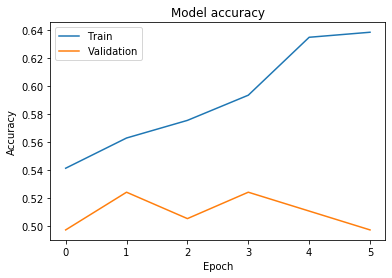

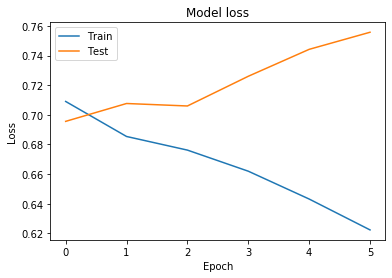

generating classfication report
Accuracy: 59.408602
  Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.52      0.56       186
           1       0.58      0.67      0.62       186

    accuracy                           0.59       372
   macro avg       0.60      0.59      0.59       372
weighted avg       0.60      0.59      0.59       372
 

job finished
********************
length of users 10760
length of the data 15477
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 15477
users before 10760
after data 3021
after users 1858
preparing the tokenizer
vocalb 3254
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 45, 100)           325400    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_2 (Flatten)          (None, 9000)       

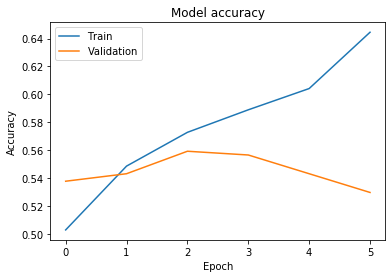

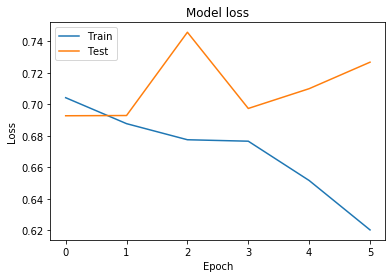

generating classfication report
Accuracy: 56.720430
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.48      0.53       186
           1       0.56      0.65      0.60       186

    accuracy                           0.57       372
   macro avg       0.57      0.57      0.56       372
weighted avg       0.57      0.57      0.56       372
 

job finished
********************
length of users 10760
length of the data 18204
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 18204
users before 10760
after data 3767
after users 1858
preparing the tokenizer
vocalb 3753
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 45, 100)           375300    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_3 (Flatten)          (None, 9000)       

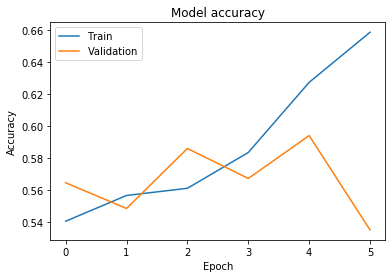

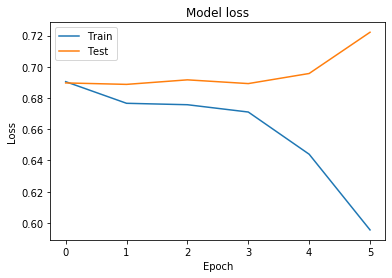

generating classfication report
Accuracy: 61.021505
  Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59       186
           1       0.60      0.66      0.63       186

    accuracy                           0.61       372
   macro avg       0.61      0.61      0.61       372
weighted avg       0.61      0.61      0.61       372
 

job finished
********************
length of users 10760
length of the data 20383
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 20383
users before 10760
after data 4389
after users 1858
preparing the tokenizer
vocalb 4151
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 45)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 45, 100)           415100    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 45, 200)           160800    
_________________________________________________________________
flatten_4 (Flatten)          (None, 9000)       

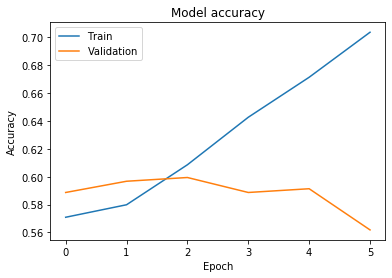

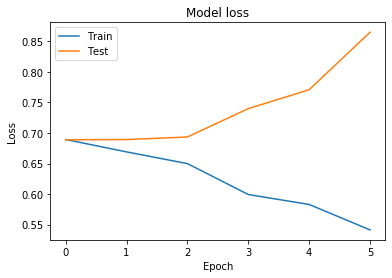

generating classfication report
Accuracy: 58.870968
  Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.41      0.50       186
           1       0.57      0.77      0.65       186

    accuracy                           0.59       372
   macro avg       0.60      0.59      0.57       372
weighted avg       0.60      0.59      0.57       372
 

job finished


In [65]:
## without sequencing lstm
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for data in bucket_data:
    print("********************")
    print("length of users",len(users_labelled))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_labelled)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

In [777]:
## dump the scores
# with open(os.path.join(input_dir,"sequence_score.pkl"),"wb") as f:
#     pickle.dump(sequence_scores,f)

# with open(os.path.join(input_dir,"sequence_models.pkl"),"wb") as f:
#     pickle.dump(sequence_models,f)
    
# with open(os.path.join(input_dir,"svm_models.pkl"),"wb") as f:
#     pickle.dump(svm_models,f)

# with open(os.path.join(input_dir,"tf_idfs.pkl"),"wb") as f:
#     pickle.dump(tfidf_list,f)

In [526]:
sequence_scores = pickle.load(open(os.path.join(input_dir,"sequence_score.pkl"),"rb"))

## Sequence models

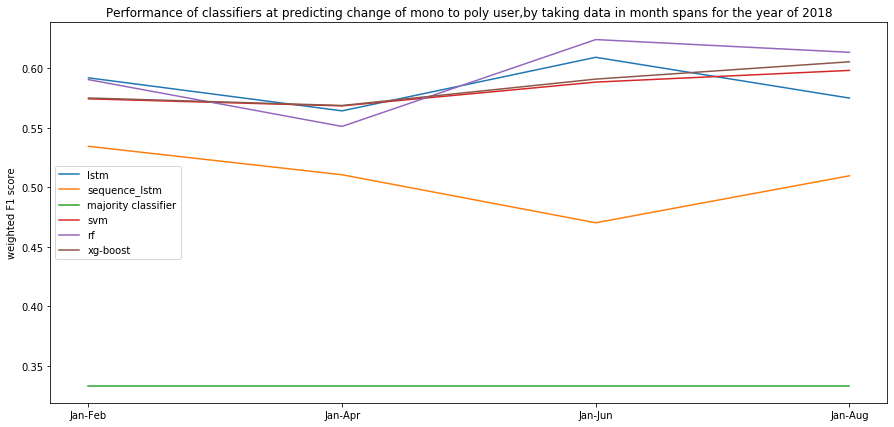

In [67]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

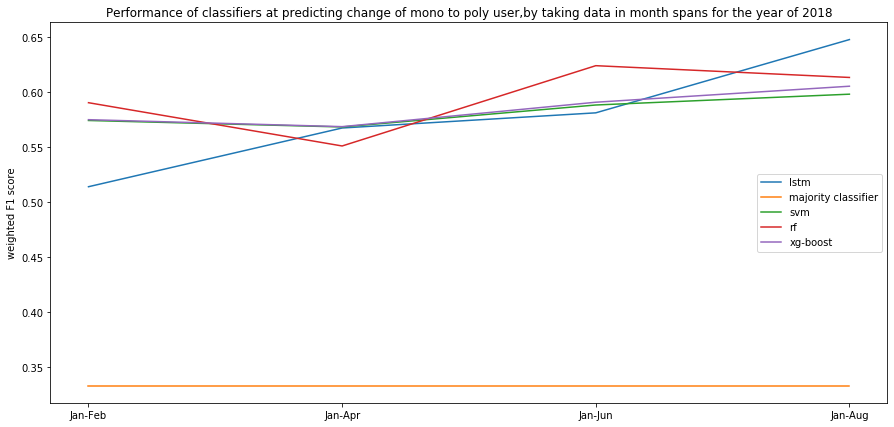

In [135]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data


max_length 16
window_size 8
preparing the tokenizer
vocalb 5653
creating glove embeddign matrix
encoding the data
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
getting the output label
sequencing data


train-test split
X-train (116, 8, 16)
X-test (39, 8, 16)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 8, 16)             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 8, 16, 100)        565300    
_________________________________________________________________
reshape_10 (Reshape)         (None, 8, 1600)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 200)               1360800   
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 402       
Total params: 1,926,502
Trainable params: 1,926,502
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for each

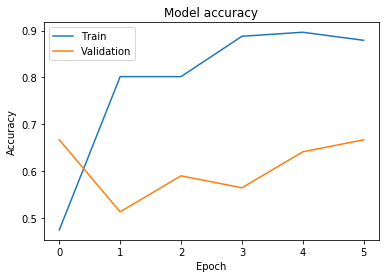

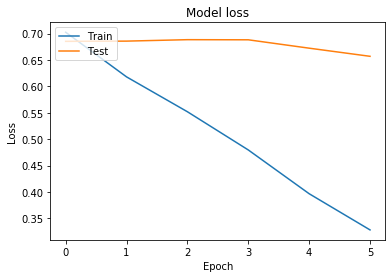

generating classfication report
Accuracy: 53.846154
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.50      0.53        20
           1       0.52      0.58      0.55        19

    accuracy                           0.54        39
   macro avg       0.54      0.54      0.54        39
weighted avg       0.54      0.54      0.54        39
 

job finished
********************
year 2016
length of users 1636
length of the data 6475
users 1636
cleanining the data


max_length 17
window_size 10
preparing the tokenizer
vocalb 7226
creating glove embeddign matrix
encoding the data
total users before 1636
length of positive samples before 259
length of positive samples after 259
total users after 518
before data 6475
users before 1636
after data 2386
after users 518
getting the output label
sequencing data


train-test split
X-train (310, 10, 17)
X-test (104, 10, 17)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 10, 17)            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 10, 17, 100)       722600    
_________________________________________________________________
reshape_11 (Reshape)         (None, 10, 1700)          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               1440800   
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 402       
Total params: 2,163,802
Trainable params: 2,163,802
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for e

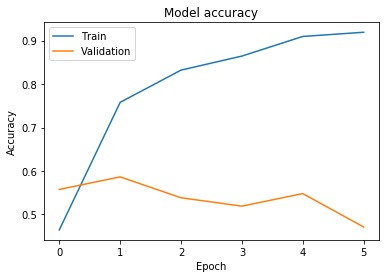

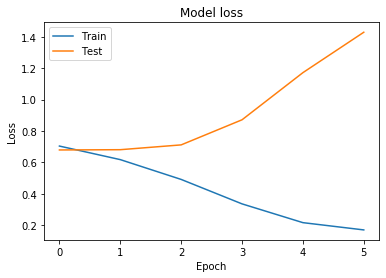

generating classfication report
Accuracy: 52.884615
  Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.40      0.46        52
           1       0.52      0.65      0.58        52

    accuracy                           0.53       104
   macro avg       0.53      0.53      0.52       104
weighted avg       0.53      0.53      0.52       104
 

job finished
********************
year 2017
length of users 40236
length of the data 111735
users 40236
cleanining the data


max_length 27
window_size 9
preparing the tokenizer
vocalb 20598
creating glove embeddign matrix
encoding the data
total users before 40236
length of positive samples before 9306
length of positive samples after 9306
total users after 18612
before data 111735
users before 40236
after data 62085
after users 18612
getting the output label
sequencing data


train-test split
X-train (11166, 9, 27)
X-test (3723, 9, 27)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 9, 27)             0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 9, 27, 100)        2059800   
_________________________________________________________________
reshape_12 (Reshape)         (None, 9, 2700)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 200)               2240800   
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 402       
Total params: 4,301,002
Trainable params: 4,301,002
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for 

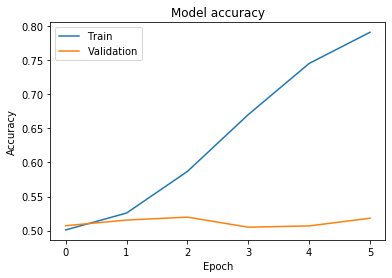

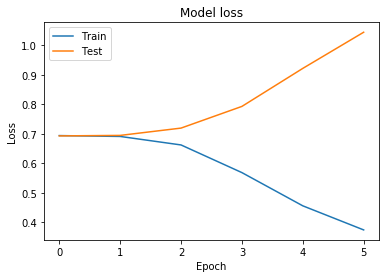

generating classfication report
Accuracy: 50.282031
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.46      0.48      1862
           1       0.50      0.55      0.52      1861

    accuracy                           0.50      3723
   macro avg       0.50      0.50      0.50      3723
weighted avg       0.50      0.50      0.50      3723
 

job finished


In [82]:
# will run lstm and other baseline models
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
sequence_scores = []
sequence_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,window,max_len,vocalb_size  = prepare_data_rnn(data,users_lbl)
    model,score = run_sequence_model(X,y,embedding_matrix,window,max_len,vocalb_size,epoch= 6,metrics=metrics)
    sequence_scores.append(score)
    sequence_models.append(model)
    cleaned_data_list.append(df)

In [ ]:
## without sequencing
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_lbl)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data


max_length 16
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
preparing the tokenizer
vocalb 2393
creating glove embeddign matrix


#### basline models

In [ ]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
maj_scores = []
tfidf_list = []
xgb_scores = []
xgb_models = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    final = run_baslines(data,users_lbl,)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    tf_idf = final["tf-idf"]
    maj_score = final["maj"]
    tfidf_list.append(tf_idf)
    svm_scores.append(svm_score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)
    xgb_scores.append(xgb_score)
    xgb_models.append(xgb_model)
    maj_scores.append(maj_score)

In [ ]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,sequence_scores,label="sequence_lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

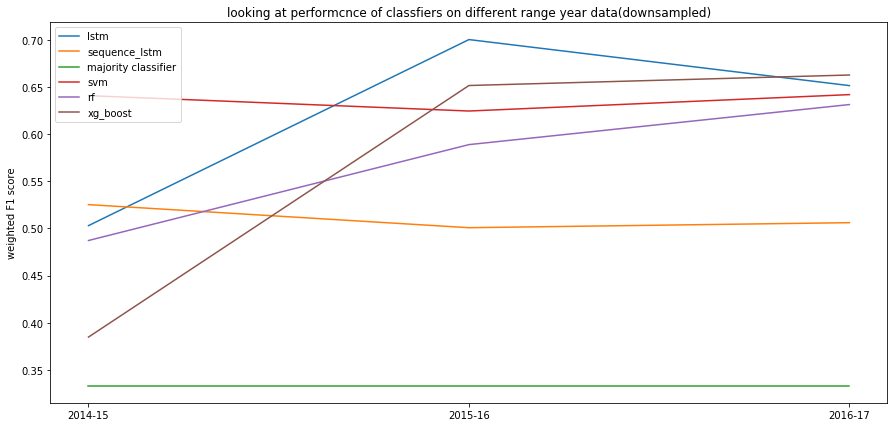

In [77]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,sequence_scores,label="sequence_lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

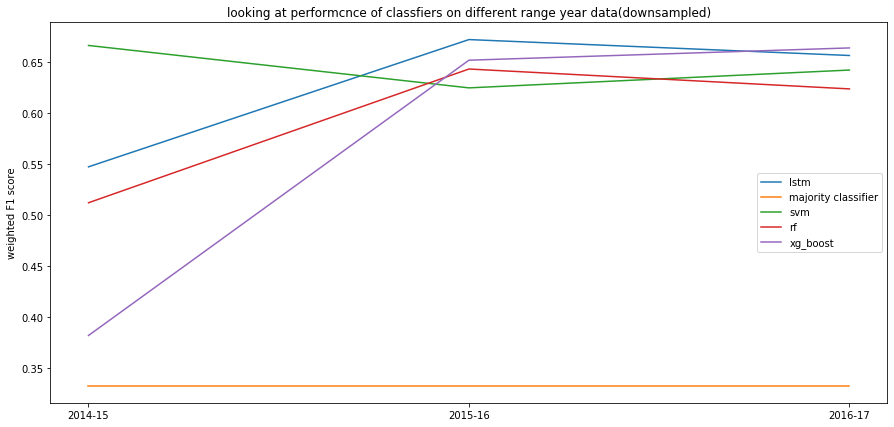

In [91]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

In [ ]:
## most descriptive words by year
for svm,tf_idf,year in zip(svm_models,tfidf_list,spans):
    print(year)
    plot_coeff(20,svm,tf_idf.get_feature_names())

### looking at cumulative range of data

In [92]:
bucket_list = []
## bucket 1
## 2014 -15 --
year = 2015
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2015
users that will change 97
total users 1049
length of data 2944


In [93]:
## bucket 1
## 2014 -16 --
year = 2016
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2016
users that will change 313
total users 2642
length of data 9456


In [94]:
## bucket 1
## 2014 -17 --
year = 2017
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2017
users that will change 9525
total users 42784
length of data 120873


********************
year 2015
length of users 1049
length of the data 2944
users 1049
cleanining the data



max_length 16
total users before 1049
length of positive samples before 97
length of positive samples after 97
total users after 194
before data 2944
users before 1049
after data 727
after users 194
preparing the tokenizer
vocalb 2393
creating glove embeddign matrix
encoding the data
X (194, 16)
y (194,)
train-test split
X-train (116, 16)
X-test (39, 16)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 16, 100)           239300    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16, 200)           160800    
_________________________________________________________________
flatten_5 (Flatten)          (None, 3200)              0   

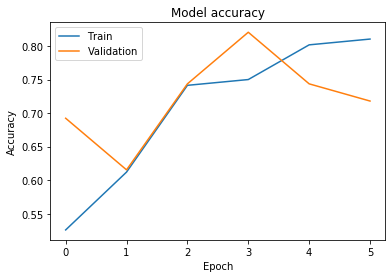

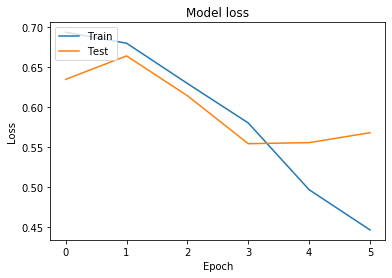

generating classfication report
Accuracy: 58.974359
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.75      0.65        20
           1       0.62      0.42      0.50        19

    accuracy                           0.59        39
   macro avg       0.60      0.59      0.58        39
weighted avg       0.60      0.59      0.58        39
 

job finished
********************
year 2016
length of users 2642
length of the data 9456
users 2642
cleanining the data



max_length 17
total users before 2642
length of positive samples before 313
length of positive samples after 313
total users after 626
before data 9456
users before 2642
after data 2878
after users 626
preparing the tokenizer
vocalb 4669
creating glove embeddign matrix
encoding the data
X (626, 17)
y (626,)
train-test split
X-train (375, 17)
X-test (126, 17)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 17)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 17, 100)           466900    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 17, 200)           160800    
_________________________________________________________________
flatten_6 (Flatten)          (None, 3400)              

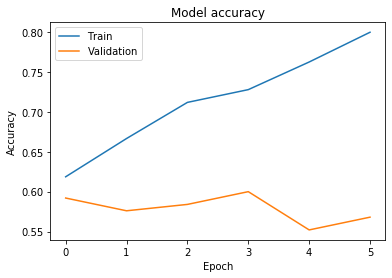

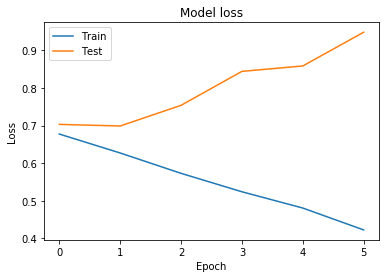

generating classfication report
Accuracy: 65.873016
  Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68        63
           1       0.69      0.59      0.63        63

    accuracy                           0.66       126
   macro avg       0.66      0.66      0.66       126
weighted avg       0.66      0.66      0.66       126
 

job finished
********************
year 2017
length of users 42784
length of the data 120873
users 42784
cleanining the data



max_length 26
total users before 42784
length of positive samples before 9525
length of positive samples after 9525
total users after 19050
before data 120873
users before 42784
after data 63890
after users 19050
preparing the tokenizer
vocalb 16490
creating glove embeddign matrix
encoding the data
X (19050, 26)
y (19050,)
train-test split
X-train (11430, 26)
X-test (3810, 26)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 26, 100)           1649000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 26, 200)           160800    
_________________________________________________________________
flatten_7 (Flatten)          (None, 

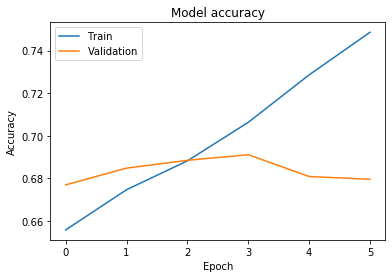

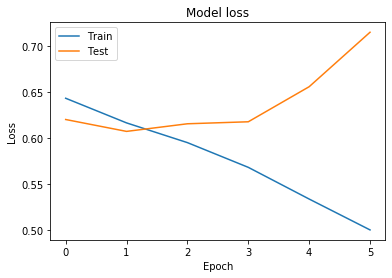

generating classfication report
Accuracy: 66.902887
  Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.68      1905
           1       0.68      0.63      0.66      1905

    accuracy                           0.67      3810
   macro avg       0.67      0.67      0.67      3810
weighted avg       0.67      0.67      0.67      3810
 

job finished


In [95]:
## RNN (LSTM)
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_lbl)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

#### basline models

In [96]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
maj_scores = []
tfidf_list = []
xgb_scores = []
xgb_models = []
for year,data,users_lbl in bucket_list:
    print("********************")
    print("year",year)
    print("length of users",len(users_lbl))
    final = run_baslines(data,users_lbl,)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    tf_idf = final["tf-idf"]
    maj_score = final["maj"]
    tfidf_list.append(tf_idf)
    svm_scores.append(svm_score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)
    xgb_scores.append(xgb_score)
    xgb_models.append(xgb_model)
    maj_scores.append(maj_score)

********************
year 2015
length of users 1049



preparing the tokenizer
downsampling
downsampled data length (194, 5572)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65        20
           1       0.63      0.63      0.63        19

    accuracy                           0.64        39
   macro avg       0.64      0.64      0.64        39
weighted avg       0.64      0.64      0.64        39
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        20
           1       0.47      0.47      0.47        19

    accuracy                           0.49        39
   macro avg       0.49      0.49      0.49        39
weighted avg       0.49      0.49      0.49        39
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.40     


preparing the tokenizer
downsampling
downsampled data length (626, 9745)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.57        63
           1       0.57      0.54      0.55        63

    accuracy                           0.56       126
   macro avg       0.56      0.56      0.56       126
weighted avg       0.56      0.56      0.56       126
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.86      0.68        63
           1       0.70      0.33      0.45        63

    accuracy                           0.60       126
   macro avg       0.63      0.60      0.57       126
weighted avg       0.63      0.60      0.57       126
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.54     


preparing the tokenizer
downsampling
downsampled data length (19050, 23748)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66      1905
           1       0.66      0.57      0.61      1905

    accuracy                           0.64      3810
   macro avg       0.64      0.64      0.64      3810
weighted avg       0.64      0.64      0.64      3810
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.77      0.68      1905
           1       0.68      0.50      0.57      1905

    accuracy                           0.63      3810
   macro avg       0.64      0.63      0.63      3810
weighted avg       0.64      0.63      0.63      3810
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.65  

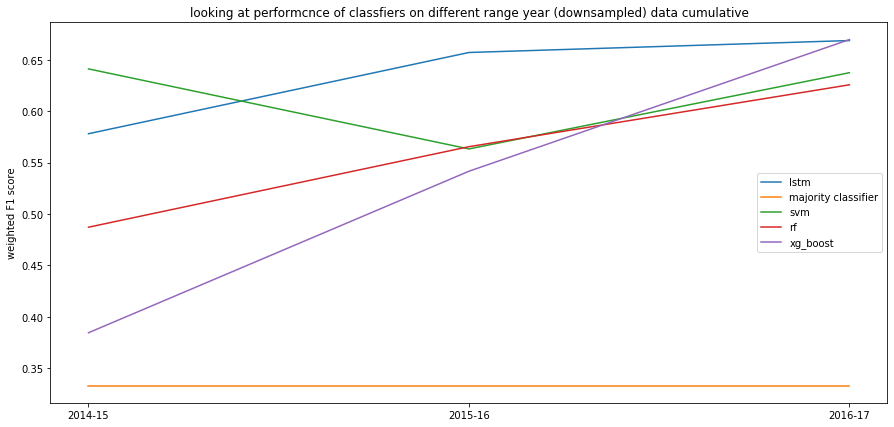

In [97]:
### plot with cumulative data
plt.figure(figsize=(15,7))
spans = ["2014-15","2014-16","2014-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year (downsampled) data cumulative")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

In [ ]:
## most descriptive words by year
for svm,tf_idf,year in zip(svm_models,tfidf_list,spans):
    print(year)
    plot_coeff(20,svm,tf_idf.get_feature_names())

In [ ]:
## without downsampling of data
fig, ax = plt.subplots(figsize = (10,6))
x_label = ["2015","205-16","2015-17"]
ax.plot(x_label,lstm_scores,label="lstm")
ax.plot(x_label,svm_scores,label="svm")
ax.plot(x_label,rf_scores,label="rf")
ax.plot(x_label,majority,label="majority classifier")
plt.title("Change of accuarcy of classifier to recongnize mono- > poly on different range of data",fontsize=14)
plt.xlabel("date range",fontsize=12)
plt.ylabel("f1 score of the classifier",fontsize=12)
plt.legend()
plt.show()